# Data Overview

Feature Meaning:
<ul>
    <li>Sample_ID:  A TCGA barcode representing the metadata of the participants and their samples.</li>
    <li>gene: Gene Name</li>
    <li>chrom: the type of chorome (1,2,X,Y,...)</li>
    <li>start: the start coordinate of the gene. It is counted by the index number of the base it starts with.</li>
    <li>end: the end coordinate of the gene. It is counted by the index number of the base it ends with.</li>
    <li>ref: are base letters. The reference base, or allele, which is what the human genome normally has. "-" This value can be missing values or just the tumour is inserting new bases without changing basis.</li>
    <li>alt: are base letters. The alternate base or allele, which found in the tumour, representing the mutation</li>
    <li>Amino_Acid_Change: An amino acid change refers to a variation in the sequence of amino acids within a protein, often caused by a mutation in the DNA. This change can impact the protein's structure and function, potentially leading to altered biological activity or disease. </li>
    <li>effect: The functional consequence of the mutation on the coding sequence</li>
    <li>filter: whether the mutation passed all tests to verify it's actually a mutation not an artifact, recurrent sequencing noise,...</li>
    <li>dna_vaf: Variant allele frequency in tumor DNA</li>
</ul>ues later on


# NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr, spearmanr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import silhouette_score

import blosum as bl

data_directory = "data/"
graph_directory = "Data Analysis Graphs/"


bio_palette = [
    "#8c564b",  # Rich brown
    "#c44e52",  # Blood red
    "#dd8452",  # Terracotta orange
    "#8172b2",  # Lavender purple
    "#ccb974",  # Pollen yellow
]
sns.set_palette(bio_palette)

# IMPORTANT FUNCTIONS

In [2]:
# Visualizes the distribution of a feature and displays it in order.
def visualize_distribution(dataframe: pd.DataFrame, feature: str, annotate):
    # Get ordered categories by frequency
    df = dataframe.copy()
    ordered_chroms = dataframe[feature].value_counts().index.tolist()
    # Create a reordered categorical column
    df["ordered"] = pd.Categorical(df[feature], categories=ordered_chroms, ordered=True)
    plt.figure(figsize=(15, 7))
    ax = sns.histplot(data=df, x="ordered", bins=len(ordered_chroms), alpha=0.7, kde=False)
    if annotate:
        for patch in ax.patches:
            height = patch.get_height()
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, height, f'{int(height)}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualizes the distribution of frequent values
def frequent_distribution(dataframe: pd.DataFrame, feature:str, annotate):
    df = dataframe.copy()
    total_rows = df.shape[0]
    threshold = 0.05
    value_counts = df[feature].value_counts()
    infrequent_values = value_counts[value_counts < total_rows * threshold].index
    df["edited"] = df[feature].apply(lambda x: "other" if x in infrequent_values else x)
    visualize_distribution(df, "edited", annotate)

def visualize_numerical_frequent(df, feature, bins=50, size=(15,5), color="#8c564b"):
    sns.set_palette([color])
    plt.figure(figsize=size)
    sns.histplot(data=df[feature], bins=bins, zorder=3)
    plt.title(f"Distribution of {feature}")
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.3, zorder=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ##plt.savefig(graph_directory + f"distribution_of_{feature}.png", dpi=300)
    plt.show()

def visualize_numerical_bar(df, feature, size=(15,5), color="#8c564b"):
    sns.set_palette([color])
    plt.figure(figsize=size)
    # df[feature].plot(kind="bar", zorder=3)
    bars = plt.bar(df["gene"], df[feature], zorder=3)
    for bar in bars:
        height = int(bar.get_height())
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height}", ha="center", va="bottom")
    plt.title(f"Bar plot of {feature}")
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, alpha=0.3, zorder=0)
    ##plt.savefig(graph_directory + f"numerical_bar_{feature}", dpi=300)
    plt.show()

def visualize_categorical_frequent(df, feature, nbr=10, size=(15,5), color="#8c564b"):
    sns.set_palette([color])
    plt.figure(figsize=size)
    top_items = df[feature].value_counts().head(nbr)
    ax = top_items.plot(kind='bar', zorder=3)
    total = int(df.shape[0])
    for patch in ax.patches:
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        ax.text(x, height, f'{int(height)} - {(int(height) / total) * 100:.2f}%', ha='center', va='bottom', fontsize=12)
    if nbr < 5:
        plt.xticks(rotation=0)
    ax.tick_params(axis="both",labelsize=12)
    plt.xlabel("Item")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.grid(True, alpha=0.3, zorder=0)
    ##plt.savefig(graph_directory + f"top_{nbr}_most_frequent_{feature}.png", dpi=300)
    plt.show()

#Calculte the outer or inner fences for outlier identification
#dataframe: dataframe to be used
#feature: to look up the outliers of a certain feature
#coef: 1.5 or 3 for inner fences and outter fences respectively
#return the lower and upper values of the fences in a list
def calculate_fence(dataframe, feature, coef):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    fences = [Q1 - coef*IQR, Q3 + coef*IQR]
    return fences

def apply_pca(dataframe, title, alpha=1):
    pca = PCA(n_components=2) 
    pca_components = pca.fit_transform(dataframe) 
    dataframe['PCA1'] = pca_components[:, 0] 
    dataframe['PCA2'] = pca_components[:, 1] # Plotting the clusters 
    plt.figure(figsize=(10, 6)) 
    sns.scatterplot(data=dataframe, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', alpha=alpha)
    plt.grid(True, alpha=0.3, zorder=0)
    handles, labels = plt.gca().get_legend_handles_labels()
    for handle in handles: #to make the legends completely visible
        handle.set_alpha(1.0)
    plt.legend(frameon=True, loc='best', fontsize=12, title='Cluster')
    plt.title(title) 
    plt.show()

def optimal_k(dataframe):
    inertia = []
    for k in range(1,11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto", init="k-means++")
        kmeans.fit(dataframe)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10,6))
    sns.lineplot(x=range(1,11), y=inertia, marker="o")
    plt.grid(True, alpha=0.3, zorder=0)
    plt.title("Optimal K - Elbow Method")
    plt.xlabel("K - Number of Clusters")
    plt.ylabel("Explained Variane Ratio")
    plt.show()

#Applied kmeans clustering
#dataframe: a dataframe for clustering analysis
#optimal_k: int, optimal number of k neighbors
def apply_kmean(dataframe, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42,n_init='auto')
    clusters = kmeans.fit_predict(dataframe)
    dataframe['Cluster'] = clusters
    return kmeans

def apply_tsne(dataframe, title, alpha=1):
    tsne = TSNE(n_components=2, random_state=42) 
    tsne_components = tsne.fit_transform(dataframe) 
    dataframe['TSNE1'] = tsne_components[:, 0] 
    dataframe['TSNE2'] = tsne_components[:, 1]
    plt.figure(figsize=(10, 6)) 
    sns.scatterplot(data=dataframe, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', alpha=alpha) 
    plt.grid(True, alpha=0.3, zorder=0)
    handles, labels = plt.gca().get_legend_handles_labels()
    for handle in handles: #to make the legends completely visible
        handle.set_alpha(1.0)
    plt.title(title) 
    plt.show()

def apply_undersampling(dataframe, target, sampling_strategy="auto"):
    undersample = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    X_smote, y_smote = undersample.fit_resample(X,y)
    new_df = pd.concat([X_smote, y_smote], axis=1)
    return new_df


def chunk(x, n):
    for i in range(0, len(x), n):
        yield x[i : i + n]

# Data Analysis PART I

In [3]:
df_mut = pd.read_csv(data_directory + "GDC-PANCAN Mutation Data.tsv", sep="\t")
df_mut.head()

Sample_ID   gene chrom     start       end ref  \
0  TCGA-P6-A5OH-01A   RER1  chr1   2402218   2402219   -   
1  TCGA-P6-A5OH-01A  WASF2  chr1  27410171  27410171   G   
2  TCGA-P6-A5OH-01A  MACF1  chr1  39455094  39455094   T   
3  TCGA-P6-A5OH-01A  KDM4A  chr1  43669220  43669220   G   
4  TCGA-P6-A5OH-01A   NFIA  chr1  61088433  61088433   T   

                                             alt  \
0  CAAGGGCATCCTTGTGGCTATGGTCTGTACTTTCTTCTACGCTTT   
1                                              A   
2                                              A   
3                                              A   
4                                              A   

               Amino_Acid_Change              effect            filter  \
0  p.F138_D139insYAFKGILVAMVCTFF   inframe_insertion              PASS   
1                        p.A287V    missense_variant              PASS   
2                       p.H6923Q    missense_variant              PASS   
3                        p.T428T  synonymous_variant  panel_of_normals   
4                        p.V104V  synonymous_variant              PASS   

    dna_vaf  
0  0.172414  
1  0.255319  
2  0.072072  
3  0.209622  
4  0.155556

In [4]:
df_mut[df_mut["gene"] == "TTN"]

Sample_ID gene chrom      start        end ref alt  \
720      TCGA-OR-A5LO-01A  TTN  chr2  178717193  178717193   G   A   
1003     TCGA-OU-A5PI-01A  TTN  chr2  178562502  178562502   C   T   
1053     TCGA-OR-A5J4-01A  TTN  chr2  178756703  178756703   G   T   
1897     TCGA-PK-A5HB-01A  TTN  chr2  178536514  178536514   C   A   
1898     TCGA-PK-A5HB-01A  TTN  chr2  178545617  178545617   A   T   
...                   ...  ...   ...        ...        ...  ..  ..   
3173720  TCGA-N9-A4Q7-01A  TTN  chr2  178768074  178768074   G   A   
3175020  TCGA-VD-A8KM-01A  TTN  chr2  178718746  178718746   C   T   
3175464  TCGA-YZ-A985-01A  TTN  chr2  178558524  178558524   C   T   
3175465  TCGA-YZ-A985-01A  TTN  chr2  178566447  178566447   C   T   
3175466  TCGA-YZ-A985-01A  TTN  chr2  178770077  178770077   G   A   

        Amino_Acid_Change              effect            filter   dna_vaf  
720              p.T8197I    missense_variant              PASS  0.500000  
1003            p.R26236H    missense_variant              PASS  0.679487  
1053                  NaN      intron_variant              PASS  0.072917  
1897            p.V31770V  synonymous_variant              PASS  0.452830  
1898            p.P30190P  synonymous_variant              PASS  0.457565  
...                   ...                 ...               ...       ...  
3173720          p.S3082F    missense_variant              PASS  0.111111  
3175020          p.V7835I    missense_variant              PASS  0.203390  
3175464         p.V27338I    missense_variant  panel_of_normals  0.125000  
3175465         p.R24921Q    missense_variant  panel_of_normals  0.274336  
3175466          p.A2875V    missense_variant              PASS  0.518519  

[13497 rows x 11 columns]

In [5]:
df_mut.shape

(3175929, 11)

In [6]:
df_mut.dtypes

Sample_ID             object
gene                  object
chrom                 object
start                  int64
end                    int64
ref                   object
alt                   object
Amino_Acid_Change     object
effect                object
filter                object
dna_vaf              float64
dtype: object

In [7]:
df_mut.isnull().sum()

Sample_ID                 0
gene                      0
chrom                     0
start                     0
end                       0
ref                       0
alt                       0
Amino_Acid_Change    575969
effect                    0
filter                    0
dna_vaf                   1
dtype: int64

In [8]:
df_mut.dropna(subset=["dna_vaf"], inplace=True)

## Feature Values Understanding

#### chrom feature

In [9]:
df_mut["chrom"].isnull().sum()

np.int64(0)

In [10]:
df_mut[["chrom"]].value_counts()

chrom
chr1     325479
chr2     236950
chr19    204286
chr11    186819
chr3     183362
chr12    166660
chr17    165149
chr6     162740
chr7     161837
chr5     159460
chrX     143588
chr4     127459
chr10    124492
chr8     117208
chr9     115196
chr16    115125
chr14     99489
chr15     99317
chr20     78031
chr13     59846
chr22     58768
chr18     51526
chr21     32172
chrY        969
Name: count, dtype: int64

Refer to know function of each chromosome: https://www.geeksforgeeks.org/biology/23-chromosomes-functions-and-types-of-chromosomes/

**Feature importance for chrom must be done!**

#### alt feature

In [11]:
df_mut["alt"].isnull().sum()

np.int64(0)

In [12]:
df_mut[["alt"]].value_counts()

alt            
T                  1147339
A                  1140289
G                   353540
C                   353259
-                   143455
                    ...   
TTTTTTTCA                1
TTTTTTTCATTT             1
TTTTTTTCATTTCT           1
TTTTTTTCTTAAA            1
TTTTTTTCTTTTTGT          1
Name: count, Length: 23524, dtype: int64

98.8% of the data in alt column is single letters. T, A, G, C are the alterations.<br />
The rest are a series of letters.
<ul>
    <li><b>What is the meaning of the more than one letter? --- DONE</b></li>
    <li><b>What is the meaning of "-"? Can this mean that there are not mutations or missing values, or simply removed? --- DONE</b></li>
</ul>

Types of alt:
- Insertion
- Deletion
- Single-Nucleotide Polymorphism
- Multiple-nucleotide polymorphism
- Mixed or Multiple-nucleotide and an InDel


For types of alterations: https://hbctraining.github.io/In-depth-NGS-Data-Analysis-Course/sessionVI/lessons/03_annotation-snpeff.html

In [13]:
df_mut[df_mut["alt"] == "-"]

Sample_ID    gene  chrom      start        end  \
6        TCGA-P6-A5OH-01A  FAM72C   chr1  143975118  143975120   
40       TCGA-P6-A5OH-01A    CMBL   chr5   10288491   10288506   
41       TCGA-P6-A5OH-01A   HMGCR   chr5   75343871   75343873   
46       TCGA-P6-A5OH-01A  PCDHA8   chr5  140842267  140842267   
65       TCGA-P6-A5OH-01A  VPS13A   chr9   77318323   77318325   
...                   ...     ...    ...        ...        ...   
3175330  TCGA-YZ-A984-01A    BAP1   chr3   52403883   52403883   
3175379  TCGA-WC-A87Y-01A    GATS   chr7  100271928  100271944   
3175486  TCGA-YZ-A985-01A    BAP1   chr3   52403173   52403201   
3175517  TCGA-YZ-A985-01A    ESM1   chr5   54985236   54985257   
3175829  TCGA-YZ-A985-01A   SF3A2  chr19    2243427    2243427   

                                   ref alt Amino_Acid_Change  \
6                                  AGG   -               NaN   
40                    CAAGGCTCTTGCCCTA   -       p.V80Gfs*14   
41                                 ATT   -          p.I64del   
46                                   T   -      p.Y316Tfs*22   
65                                 CTA   -        p.T1683del   
...                                ...  ..               ...   
3175330                              T   -       p.K421Rfs*9   
3175379              GTGCTCCAGGATGTGGA   -       p.S14Rfs*38   
3175486  CAGGCCTCACCATCCCCGTCTTCTCTCTG   -      p.S609Rfs*24   
3175517         TTCACCAAAAGGATCCTCCCCA   -       p.N87Kfs*37   
3175829                              C   -        p.Q4Sfs*44   

                                            effect filter   dna_vaf  
6                            upstream_gene_variant   PASS  0.271523  
40                              frameshift_variant   PASS  0.089552  
41                                inframe_deletion   PASS  0.141414  
46                              frameshift_variant   PASS  0.215385  
65                                inframe_deletion   PASS  0.166667  
...                                            ...    ...       ...  
3175330                         frameshift_variant   PASS  0.782609  
3175379  frameshift_variant;NMD_transcript_variant   PASS  0.181818  
3175486                         frameshift_variant   PASS  0.800000  
3175517                         frameshift_variant   PASS  0.084507  
3175829                         frameshift_variant   PASS  0.391304  

[143455 rows x 11 columns]

About 4.5% of the data has "-" alt values. However, they exhibit mutation effects and dna_vaf values indicating a mutation has occured. **This is a removed alteration.**

Maybe there should be some encoding? If it is not important the values of bases but only the type, then we just need to encode to types of alterations:

- One base: Single-Nucleotide Polymorphism
- More than one base: Multiple-Nucleotide Polymorphism
- From one to more: Insertion
- Decreasing number of letters: Deletion
- Decreasing or inserting and changing: Multiple-nucleotide and InDel

**There are duplicates in the sample ID check them!!! Check what they mean as well!**

In [14]:
df_mut.duplicated().value_counts()

False    3175928
Name: count, dtype: int64

**No Duplicates**

In [15]:
print(df_mut.duplicated(subset=["Sample_ID","gene","chrom","start","end","ref"]).value_counts())
print()
print(df_mut.duplicated(subset=["Sample_ID","gene","chrom","start","end","ref","effect"]).value_counts())
print()
print(df_mut.duplicated(subset=["Sample_ID","gene","chrom","start","end","ref","alt"]).value_counts())

False    3175917
True          11
Name: count, dtype: int64

False    3175922
True           6
Name: count, dtype: int64

False    3175928
Name: count, dtype: int64


In [16]:
df_mut[df_mut.duplicated(subset=["Sample_ID","gene","chrom","start","end","ref"], keep=False)].sort_values(by="Sample_ID")

Sample_ID     gene  chrom      start        end ref alt  \
433247   TCGA-A6-2686-01A      QKI   chr6  163566669  163566669   C   -   
433248   TCGA-A6-2686-01A      QKI   chr6  163566669  163566669   C   T   
2640232  TCGA-AJ-A2QO-01A     YAP1  chr11  102231838  102231838   C   -   
2640233  TCGA-AJ-A2QO-01A     YAP1  chr11  102231838  102231838   C   T   
2138957  TCGA-BR-6452-01A   HS6ST2   chrX  132957136  132957136   G   -   
2138958  TCGA-BR-6452-01A   HS6ST2   chrX  132957136  132957136   G   A   
2130907  TCGA-CG-5726-01A  TMEM256  chr17    7403020    7403020   A   -   
2130908  TCGA-CG-5726-01A  TMEM256  chr17    7403020    7403020   A   T   
615469   TCGA-CM-5861-01A    CCSAP   chr1  229325110  229325110   A   -   
615470   TCGA-CM-5861-01A    CCSAP   chr1  229325110  229325110   A   T   
2643440  TCGA-D1-A0ZV-01A     PTEN  chr10   87933148   87933148   G   -   
2643441  TCGA-D1-A0ZV-01A     PTEN  chr10   87933148   87933148   G   A   
2987627  TCGA-DF-A2KN-01A     HPS1  chr10   98434080   98434080   G   A   
2987626  TCGA-DF-A2KN-01A     HPS1  chr10   98434080   98434080   G   -   
2685668  TCGA-DF-A2KZ-01A    WIPF1   chr2  174560578  174560578   T   A   
2685667  TCGA-DF-A2KZ-01A    WIPF1   chr2  174560578  174560578   T   -   
3025376  TCGA-EY-A549-01A     SRPR  chr11  126267192  126267192   T   C   
3025375  TCGA-EY-A549-01A     SRPR  chr11  126267192  126267192   T   -   
336266   TCGA-VS-A94Z-01A    AP1G1  chr16   71731426   71731426   A   G   
336265   TCGA-VS-A94Z-01A    AP1G1  chr16   71731426   71731426   A   -   
1556979  TCGA-XK-AAIW-01A      ABR  chr17    1125307    1125307   G   A   
1556978  TCGA-XK-AAIW-01A      ABR  chr17    1125307    1125307   G   -   

        Amino_Acid_Change                   effect            filter   dna_vaf  
433247                NaN           intron_variant              PASS  0.265625  
433248                NaN           intron_variant              PASS  0.171875  
2640232               NaN      3_prime_UTR_variant              PASS  0.294118  
2640233               NaN      3_prime_UTR_variant              PASS  0.342857  
2138957      p.R207Afs*13       frameshift_variant              PASS  0.098361  
2138958           p.R207C         missense_variant              PASS  0.253968  
2130907               NaN      3_prime_UTR_variant              PASS  0.437500  
2130908               NaN      3_prime_UTR_variant              PASS  0.360000  
615469                NaN      3_prime_UTR_variant  panel_of_normals  0.217391  
615470                NaN      3_prime_UTR_variant              PASS  0.585714  
2643440       p.R130Qfs*4       frameshift_variant              PASS  0.283784  
2643441           p.R130Q         missense_variant              PASS  0.270270  
2987627           p.P137L         missense_variant              PASS  0.095238  
2987626      p.P137Qfs*38       frameshift_variant              PASS  0.225000  
2685668               NaN  downstream_gene_variant              PASS  0.310345  
2685667               NaN  downstream_gene_variant              PASS  0.407407  
3025376           p.K170R         missense_variant              PASS  0.237288  
3025375      p.K170Rfs*33       frameshift_variant  panel_of_normals  0.327731  
336266                NaN      3_prime_UTR_variant              PASS  0.337079  
336265                NaN      3_prime_UTR_variant              PASS  0.126437  
1556979            p.P41L         missense_variant  panel_of_normals  0.494845  
1556978       p.P41Rfs*51       frameshift_variant              PASS  0.305263

There are 11 duplicates that have the same identifiers: Sample_ID, gene, chrom, start, end, ref. The majority of the entries have missing values in the Amino_Acid_Change column. The duplicates can indicate multiple alterations happened to same base. The alterations here are either Deletions or Single-Nucleotide Polymorphism. Some different alterations for those duplicates reveal the same effect, Amino_Acid_Change, and filter but different dna_vaf. This reveals that 6 pair alterations leads to the same effect but different dna_vaf in these entries. However those 6 pairs have **missing Amino_Acid_Change** values.

#### Amino_Acid_Change feature

In [17]:
df_mut["Amino_Acid_Change"].value_counts()

Amino_Acid_Change
p.M1?                 2375
p.V600E                548
p.R132H                482
p.E545K                301
p.A2A                  252
                      ... 
p.G1686S                 1
p.G251Kfs*53             1
p.I187_R193delinsM       1
p.S1661_R1668del         1
p.G134Lfs*40             1
Name: count, Length: 448743, dtype: int64

In [18]:
df_mut[["Amino_Acid_Change"]].isnull().sum()

Amino_Acid_Change    575969
dtype: int64

There are 575969 rows of missing values in the Amino_Acid_Change.
According to https://docs.gdc.cancer.gov/Data/PDF/Data_UG.pdf, the amino_acid values are only given if the variation affects the protein-coding sequence. 

As a result, **those missing values represent mutations not affecting the protein-coding sequence. Verify this through checking the rest of the columns**

In [19]:
df_mut[df_mut["Amino_Acid_Change"].notna()][["Amino_Acid_Change"]]

Amino_Acid_Change
0        p.F138_D139insYAFKGILVAMVCTFF
1                              p.A287V
2                             p.H6923Q
3                              p.T428T
4                              p.V104V
...                                ...
3175923                         p.D41D
3175924                        p.P234L
3175925                         p.G35G
3175926                        p.T291T
3175927                        p.D116N

[2599959 rows x 1 columns]

This annotation is the HGVS(Human Genome Variation Society) protein nomenclature to describe amino acid substitutions or changes.
- p: the change is at the protein-level
- X: one-letter for the original amino acid
- 123: position of the amino acid in the protein sequence
- Y: one-letter code for the new (mutated) amino acid.

The letters are molecules not bases. Those molecules make up the Amino Acid. You might notice that some letters are like the DNA bases thats because DNA is converted into mRNA which uses codons(triples of bases) which in turn translates into amino acids.

In [20]:
uncertain_df = df_mut[df_mut["Amino_Acid_Change"].str.contains(r"\?", regex=True, na=False)]

In [21]:
uncertain_df.shape

(3130, 11)

In [22]:
uncertain_df

Sample_ID      gene  chrom      start        end ref alt  \
811      TCGA-OR-A5L1-01A     ZRSR1   chr5  112891641  112891641   T   C   
1380     TCGA-OR-A5LR-01A  HIST1H3D   chr6   26197250   26197250   T   C   
1466     TCGA-OR-A5K0-01A    MAGEB2   chrX   30218583   30218583   G   T   
2519     TCGA-PK-A5HB-01A      SDHD  chr11  112086909  112086909   T   A   
2552     TCGA-PK-A5HB-01A      WNT1  chr12   48981381   48981381   C   -   
...                   ...       ...    ...        ...        ...  ..  ..   
3172052  TCGA-ND-A4WC-01A    NDUFV2  chr18    9134279    9134279   A   C   
3172749  TCGA-ND-A4WC-01A     KDM5C   chrX   53224887   53224887   C   T   
3173213  TCGA-N6-A4V9-01A      NCDN   chr1   35558191   35558191   A   G   
3173419  TCGA-NA-A4R1-01A      ATL3  chr11   63671333   63671333   C   T   
3174374  TCGA-VD-AA8P-01A      ALG1  chr16    5071850    5071850   A   G   

        Amino_Acid_Change              effect filter   dna_vaf  
811                 p.M1?          start_lost   PASS  0.340206  
1380                p.M1?          start_lost   PASS  0.057034  
1466                p.M1?          start_lost   PASS  0.036281  
2519                p.M1?          start_lost   PASS  0.750000  
2552          p.H287Tfs*?  frameshift_variant   PASS  0.435484  
...                   ...                 ...    ...       ...  
3172052      p.*250Yext*?           stop_lost   PASS  0.340426  
3172749             p.M1?          start_lost   PASS  0.545455  
3173213             p.M1?          start_lost   PASS  0.952756  
3173419             p.M1?          start_lost   PASS  0.136364  
3174374             p.M1?          start_lost   PASS  0.444444  

[3130 rows x 11 columns]

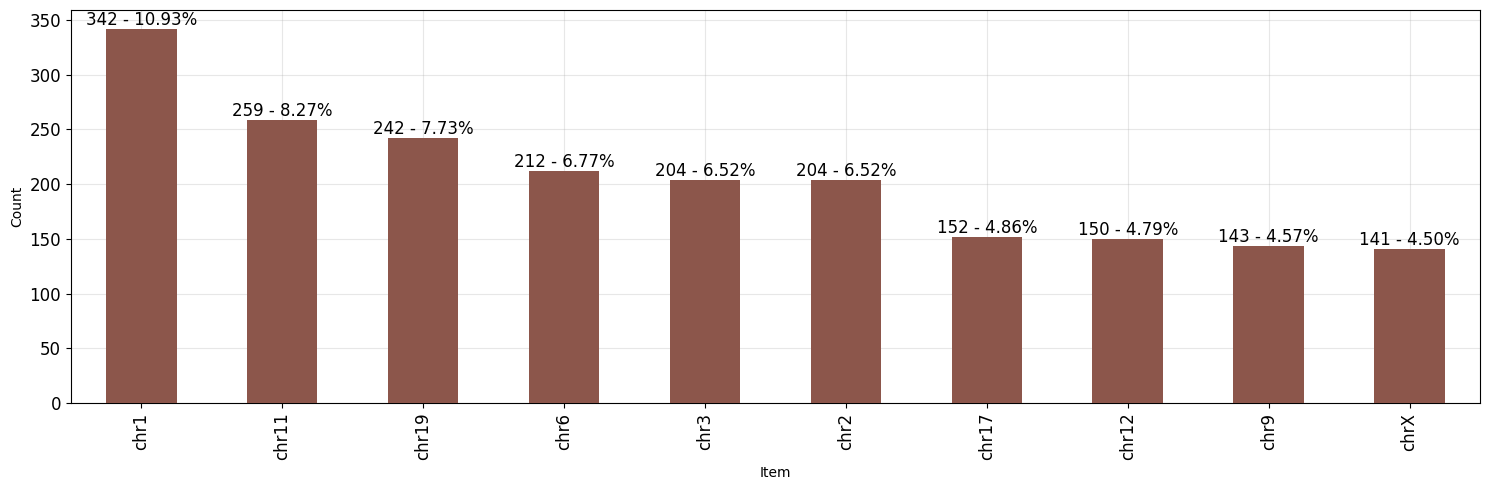

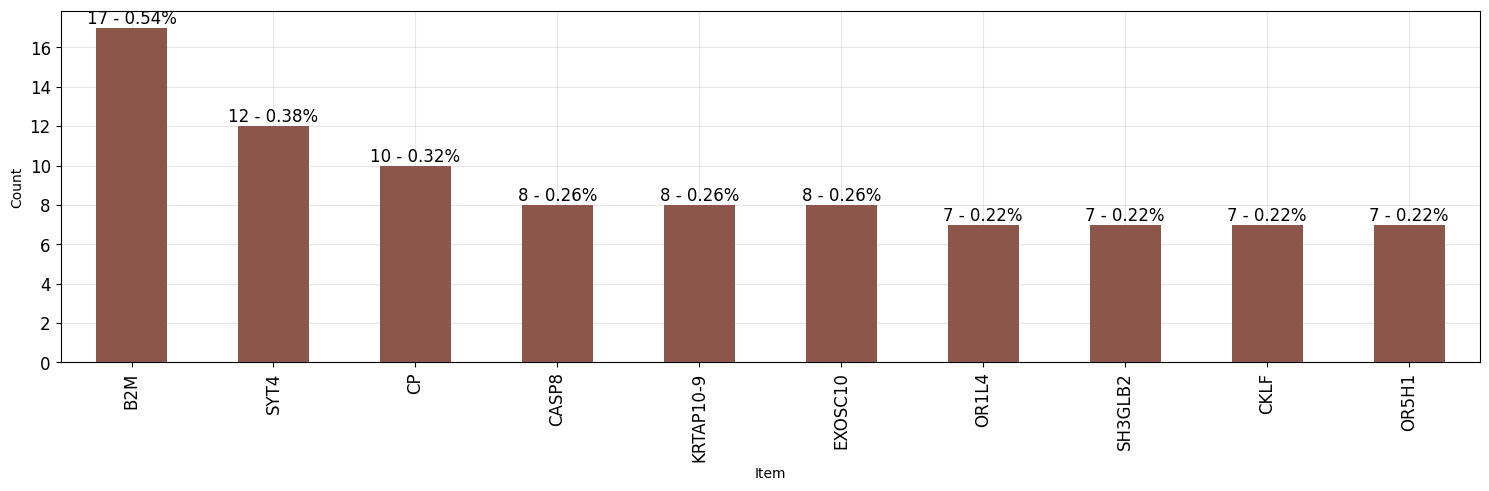

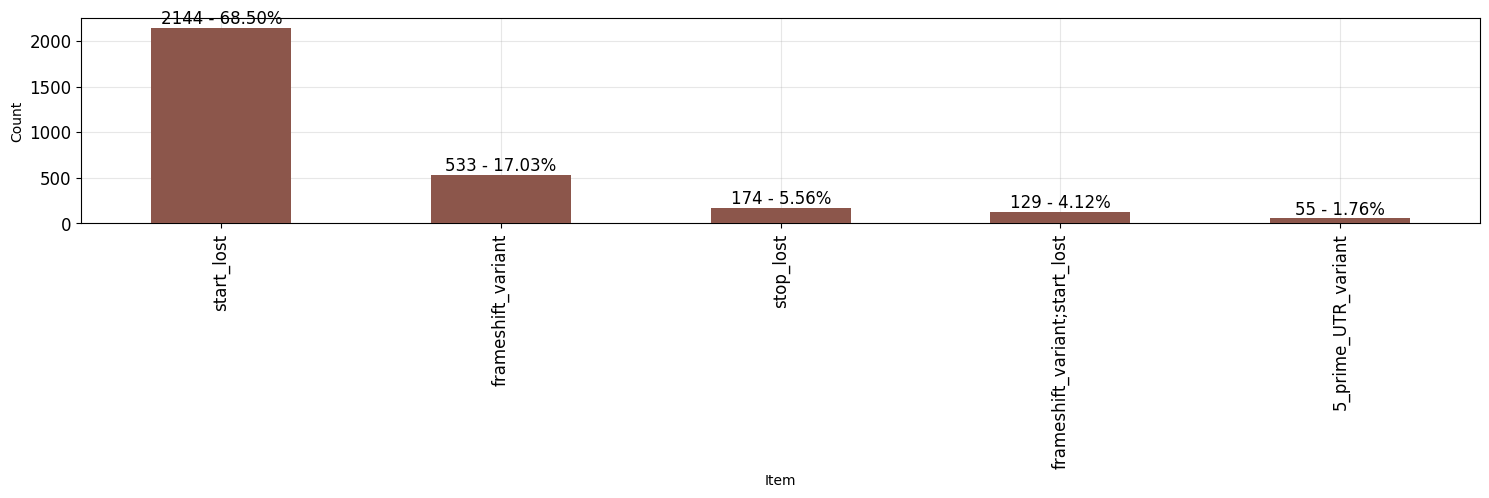

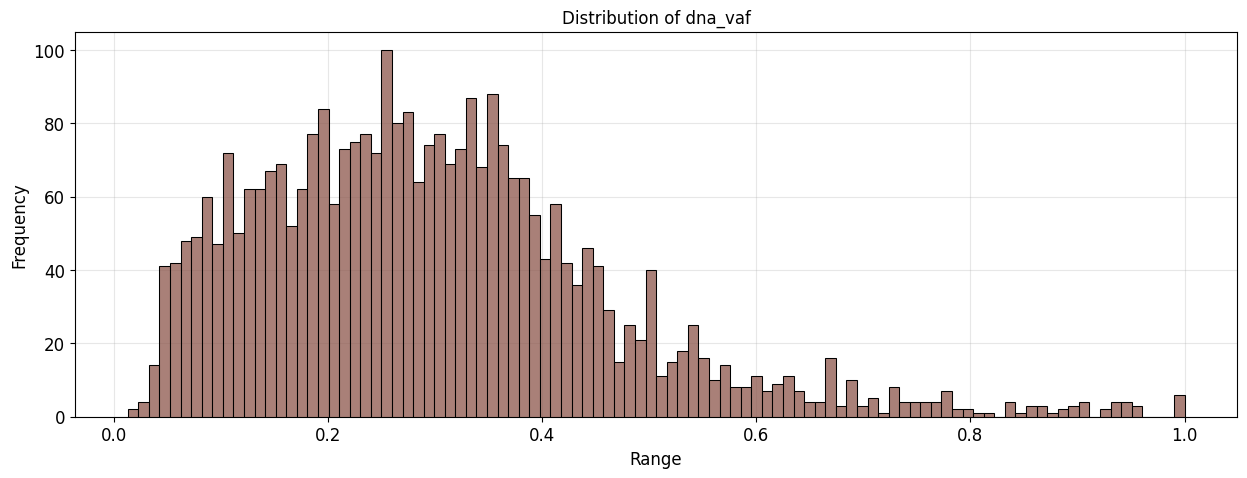

dna_vaf
count  3130.000000
mean      0.297095
std       0.165885
min       0.012821
25%       0.176571
50%       0.277778
75%       0.382270
max       1.000000

In [23]:
visualize_categorical_frequent(uncertain_df, "chrom", 10)
visualize_categorical_frequent(uncertain_df, "gene", 10)
#visualize_categorical_frequent(uncertain_df, "type", 3)
visualize_categorical_frequent(uncertain_df, "effect", 5)
visualize_numerical_frequent(uncertain_df, "dna_vaf", 100)
uncertain_df[["dna_vaf"]].describe()

- **According to the HGVS Nomenclature, the "?" question mark refers to uncertainty indicating unknown positions or experimentally not confirmed.**


Source: https://hgvs-nomenclature.org/stable/recommendations/general/

#### Verifying null value meaning of Amino_Acid_Change

In [24]:
df_missing = df_mut[df_mut["Amino_Acid_Change"].isnull()]
df_missing.head()

Sample_ID    gene chrom      start        end  ref alt  \
6   TCGA-P6-A5OH-01A  FAM72C  chr1  143975118  143975120  AGG   -   
8   TCGA-P6-A5OH-01A   DCST1  chr1  155050883  155050883    C   G   
15  TCGA-P6-A5OH-01A   H3F3A  chr1  226065832  226065832    T   G   
16  TCGA-P6-A5OH-01A   GREB1  chr2   11640545   11640545    G   C   
18  TCGA-P6-A5OH-01A    MSH6  chr2   47783223   47783223    C   T   

   Amino_Acid_Change                 effect filter   dna_vaf  
6                NaN  upstream_gene_variant   PASS  0.271523  
8                NaN    3_prime_UTR_variant   PASS  0.247899  
15               NaN         intron_variant   PASS  0.280543  
16               NaN    3_prime_UTR_variant   PASS  0.250000  
18               NaN    5_prime_UTR_variant   PASS  0.069231

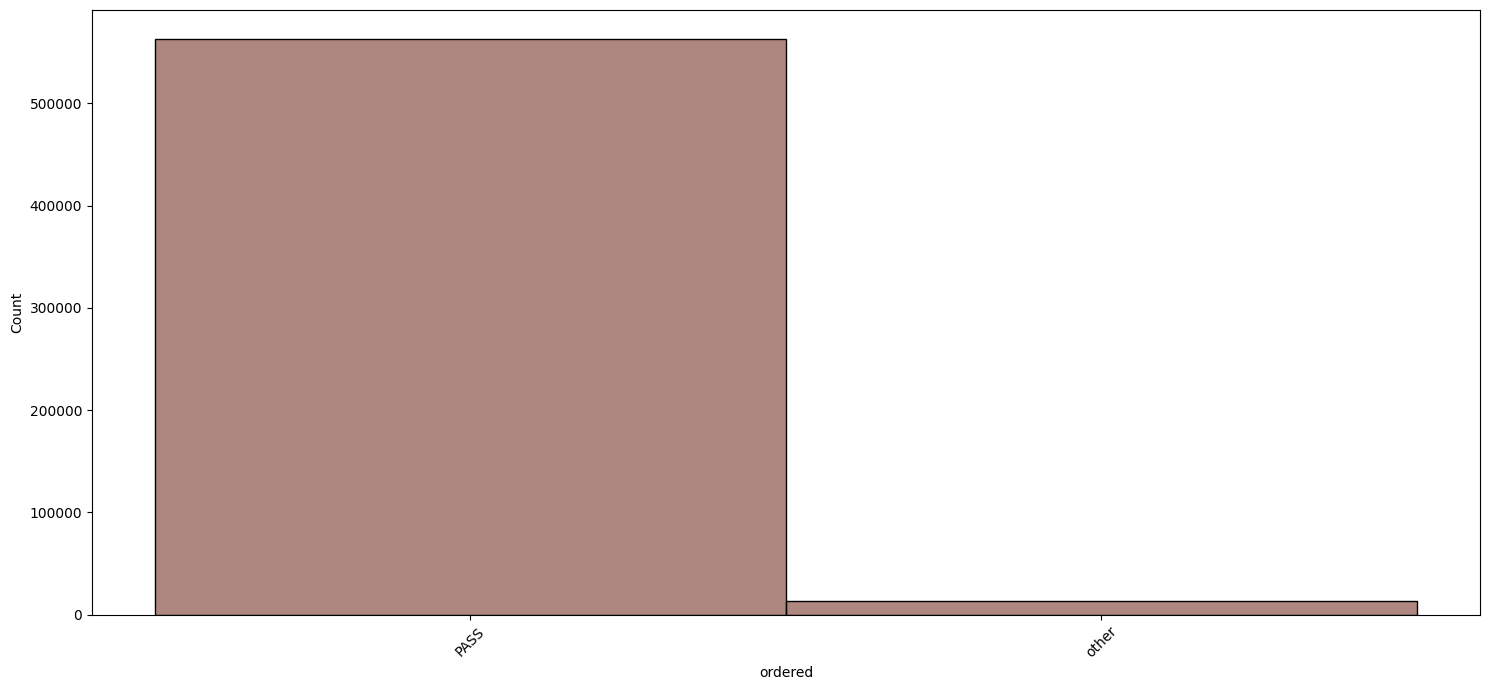

In [25]:
frequent_distribution(df_missing, "filter", False)

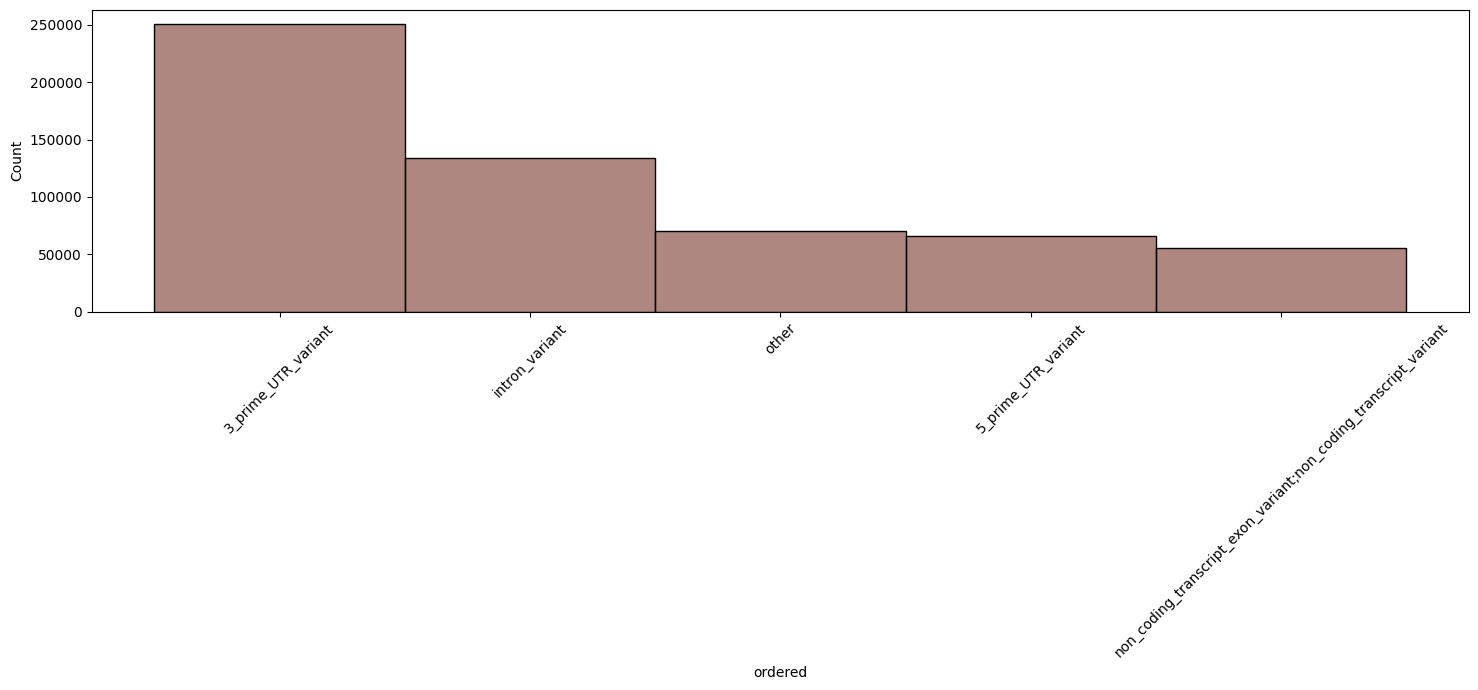

In [26]:
frequent_distribution(df_missing, "effect", False)

In [27]:
# Get the unique effects
effects = df_missing["effect"].value_counts().index.tolist()
unique_effect = []
for effect in effects:
    effect_split = effect.split(";")
    for i in effect_split:
        if i not in unique_effect:
            unique_effect.append(i)

print(len(unique_effect))
print(unique_effect)

22
['3_prime_UTR_variant', 'intron_variant', '5_prime_UTR_variant', 'non_coding_transcript_exon_variant', 'non_coding_transcript_variant', 'downstream_gene_variant', 'upstream_gene_variant', 'splice_region_variant', 'NMD_transcript_variant', 'mature_miRNA_variant', 'splice_acceptor_variant', 'intergenic_variant', 'frameshift_variant', 'coding_sequence_variant', 'splice_donor_variant', 'regulatory_region_variant', 'stop_lost', 'inframe_insertion', 'stop_retained_variant', 'stop_gained', 'inframe_deletion', 'protein_altering_variant']


**Protein-level effects:**
<ul>
    <li><b>splice_region_variant</b>: Splice region variants occur near intron–exon boundaries and can disrupt normal splicing.
If splicing changes, it may alter the mRNA reading frame, remove or add exons, and thus change the resulting protein sequence.</li>
    <li><b>NMD_transcript_variant</b>: NMD stands for Nonsense-Mediated Decay. Variants causing premature stop codons trigger NMD, leading to degradation of the transcript and reduced protein production. While it may not change the amino acid sequence directly, it affects the protein level by lowering or eliminating protein expression.</li>
    <li><b>splice_acceptor_variant</b>: This variant affects the splice acceptor site at the 3′ end of an intron. It can disrupt normal splicing, potentially causing exon skipping, intron retention, or frameshifts, which alter the resulting protein’s amino acid sequence or produce a truncated protein.</li>
    <li><b>frameshift_variant</b>: A frameshift changes the reading frame of the coding sequence, which alters all downstream amino acids and often introduces a premature stop codon. This directly impacts the protein’s sequence and structure.</li>
    <li><b>coding_sequence_variant</b>: It occurs within the coding sequence of a gene, meaning it can directly change the amino acid sequence (missense, nonsense, or silent) or otherwise affect the protein product.</li>
    <li><b>splice_donor_variant</b>: It affects the splice donor site at the 5′ end of an intron. Disruption here can cause incorrect splicing, leading to exon skipping, intron retention, or frameshifts — all of which can directly change the protein sequence.</li>
    <li><b>stop_lost</b>: This variant removes the normal stop codon, causing translation to continue beyond the intended end. The protein becomes elongated, with additional amino acids at the C-terminus, which can change its structure and function.</li>
    <li><b>inframe_deletion</b>: An inframe deletion removes one or more codons without shifting the reading frame, leading to the loss of specific amino acids in the protein. This directly alters the protein’s sequence and potentially its function.</li>
    <li><b>stop_gained</b>: This variant introduces a premature stop codon, leading to a truncated protein. The shorter sequence can lose essential domains or functions and may also trigger nonsense-mediated decay.</li>
    <li><b>protein_altering_variant</b>: This is a general term for variants that change the amino acid sequence of the protein, such as missense mutations or inframe indels. It directly impacts the protein’s structure and function</li>
</ul>

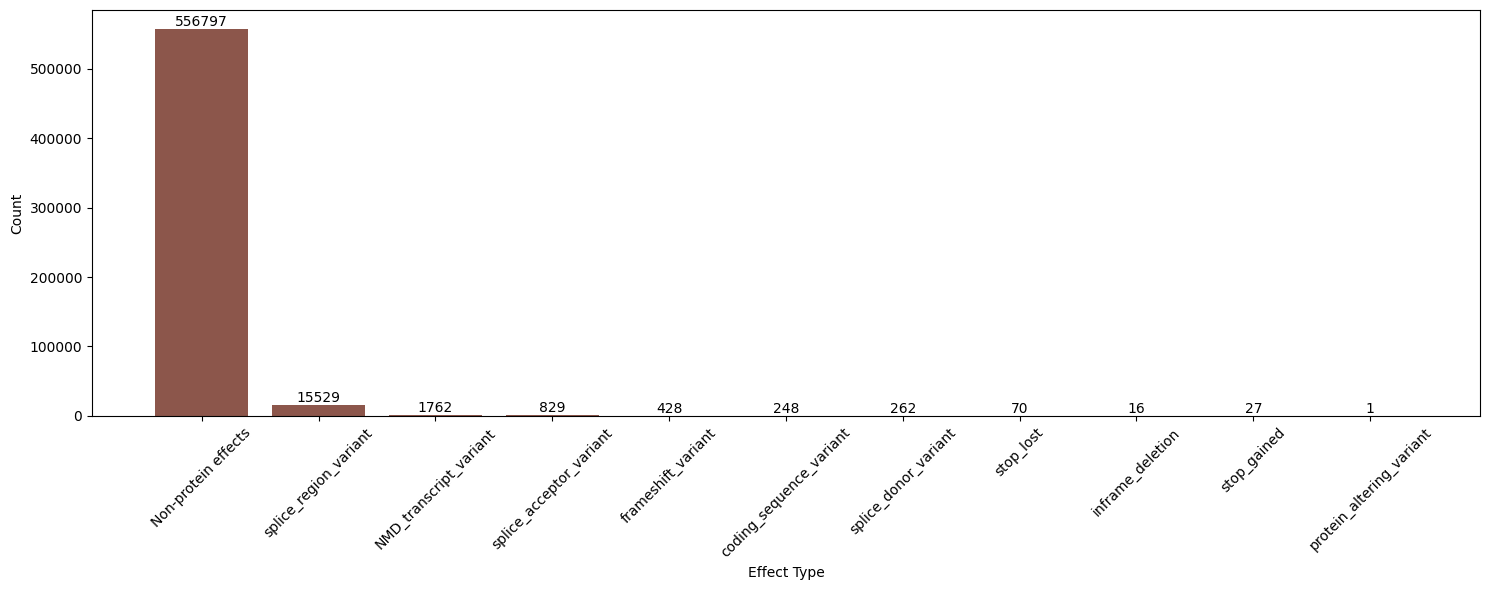

In [28]:
def protein_effect_frequency(dataframe, effect):
    df = dataframe.copy()
    frequency = 0
    dict_effect = df["effect"].value_counts().to_dict()
    for key in dict_effect:
        if(effect in key):
            frequency += dict_effect[key]
    return frequency

protein_effects = ["splice_region_variant","NMD_transcript_variant","splice_acceptor_variant","frameshift_variant","coding_sequence_variant","splice_donor_variant","stop_lost","inframe_deletion","stop_gained","protein_altering_variant"]
data = [protein_effect_frequency(df_missing, effect) for effect in protein_effects]
all_data = sum(data)

protein_effects.insert(0, "Non-protein effects")
data.insert(0, df_missing.shape[0] - all_data)

plt.figure(figsize=(15,6))
bars = plt.bar(protein_effects, data)
for bar, value in zip(bars, data):
    plt.text(
        bar.get_x() + bar.get_width() / 2, # x position
        value, # y position
        value,
        ha="center", va="bottom", fontsize=10
    )
#plt.title("Protein Effect Frequency")
plt.xlabel("Effect Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(graph_directory + "amino_acid_change_missing_values_verification.png", dpi=300)
plt.show()



In [29]:
print(f"{all_data / df_missing.shape[0] * 100:.2f}%")

3.33%


**Only 3.33% of the effects are attributable to protein-level or near protein-level changes, supporting the interpretation that the null values in the Amino_Acid_Change field reflect a genuine absence of protein-level impact from the mutations, rather than missing data due to error.**

In [30]:
df_missing["dna_vaf"].describe()

count    575969.000000
mean          0.320523
std           0.162685
min           0.000000
25%           0.200000
50%           0.309524
75%           0.416667
max           1.000000
Name: dna_vaf, dtype: float64

In [31]:
length_gene = len(df_missing["gene"].unique().tolist())
length_id = len(df_missing["Sample_ID"].unique().tolist())

print(f"Unique values of genes is {length_gene}")
print(f"Unique values of genes is {length_id}")

Unique values of genes is 21187
Unique values of genes is 9866


In [32]:
df_pass = df_mut[df_mut["filter"] == "PASS"]
print(df_pass.shape)

(3035379, 11)


In [33]:
df_pass["chrom"].describe()

count     3035379
unique         24
top          chr1
freq       310436
Name: chrom, dtype: object

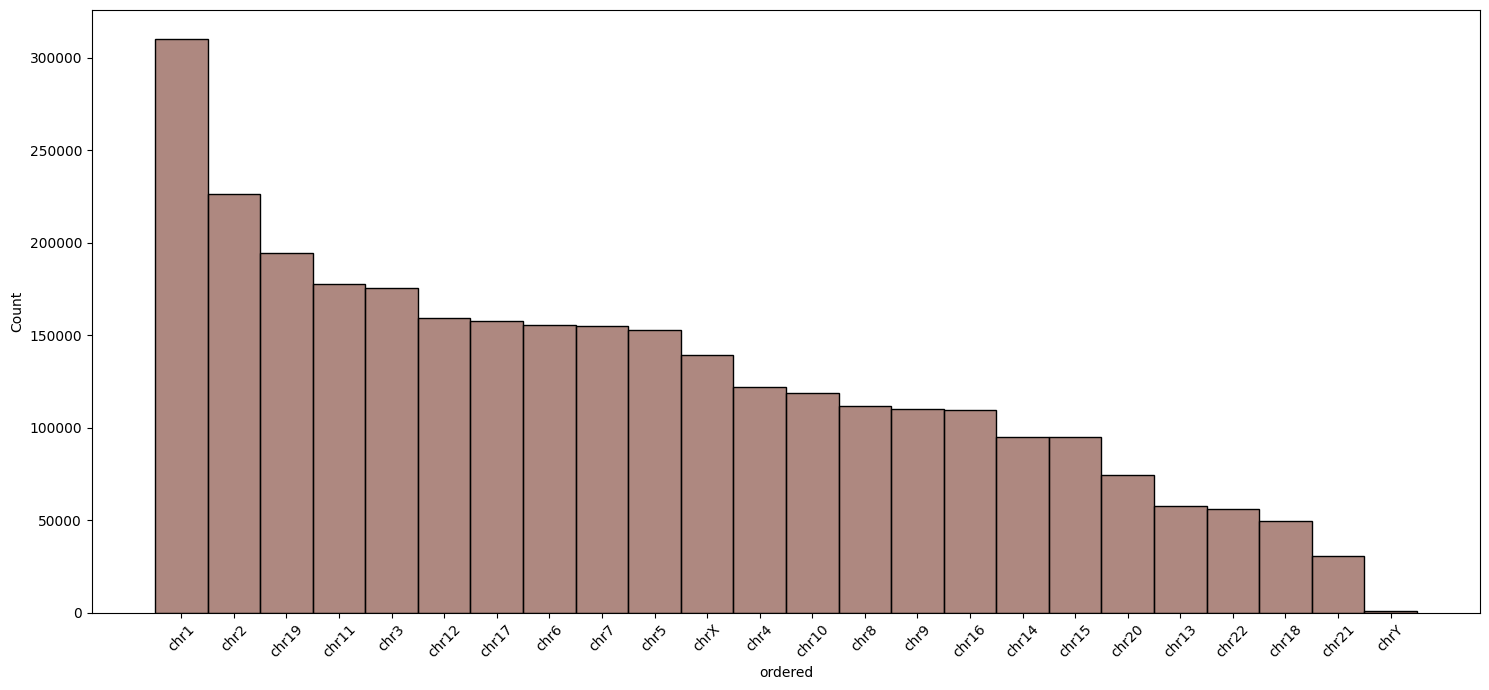

In [34]:
visualize_distribution(df_pass, "chrom", False)

In [35]:
df_mut["gene"].duplicated().sum()

np.int64(3153876)

#### effect column

In [36]:
df_mut["effect"].isnull().sum()

np.int64(0)

**No Missing Values**

In [37]:
df_mut["effect"].describe()

count              3175928
unique                 123
top       missense_variant
freq               1581987
Name: effect, dtype: object

In [38]:
# value_counts = df_mut["effect"].value_counts()
# rare_values = value_counts[value_counts == 1].index.tolist()
# pass_ = "PASS"
# print(pass_ in(rare_values))
# print()
# print(rare_values)


# This block was used to investigate the first row

In [39]:
df_mut["effect"].unique()

array(['inframe_insertion', 'missense_variant', 'synonymous_variant',
       'upstream_gene_variant', 'stop_gained', '3_prime_UTR_variant',
       'intron_variant', '5_prime_UTR_variant',
       'synonymous_variant;NMD_transcript_variant',
       'missense_variant;splice_region_variant', 'frameshift_variant',
       'inframe_deletion', 'inframe_deletion;splice_region_variant',
       'non_coding_transcript_exon_variant;non_coding_transcript_variant',
       'downstream_gene_variant', 'stop_gained;splice_region_variant',
       'splice_acceptor_variant', 'splice_region_variant;intron_variant',
       'splice_region_variant;synonymous_variant',
       'frameshift_variant;splice_region_variant', 'splice_donor_variant',
       '3_prime_UTR_variant;NMD_transcript_variant',
       'stop_gained;frameshift_variant',
       'stop_gained;protein_altering_variant', 'stop_lost', 'start_lost',
       'missense_variant;NMD_transcript_variant',
       'protein_altering_variant', 'stop_gained;inframe_

To know the meaning of the effect values: https://rgd.mcw.edu/rgdweb/ontology/annot.html?acc_id=SO:0001583

#### filter column

In [40]:
df_mut["filter"].isnull().sum()

np.int64(0)

**No missing values**

In [41]:
df_mut["filter"].describe()

count     3175928
unique         94
top          PASS
freq      3035379
Name: filter, dtype: object

In [42]:
df_mut[df_mut["filter"] == "PASS"].shape

(3035379, 11)

In [43]:
df_mut["filter"].unique()

array(['PASS', 'panel_of_normals',
       'clustered_events;homologous_mapping_event',
       'clustered_events;homologous_mapping_event;t_lod_fstar',
       'alt_allele_in_normal', 'bSeq', 'clustered_events', 't_lod_fstar',
       'bSeq;panel_of_normals', 'panel_of_normals;str_contraction',
       'str_contraction', 'bSeq;t_lod_fstar',
       'alt_allele_in_normal;panel_of_normals', 'germline_risk',
       'bSeq;clustered_events',
       'clustered_events;multi_event_alt_allele_in_normal',
       'alt_allele_in_normal;bSeq', 'germline_risk;panel_of_normals',
       'clustered_events;germline_risk',
       'bSeq;germline_risk;panel_of_normals',
       'clustered_events;panel_of_normals',
       'bSeq;clustered_events;multi_event_alt_allele_in_normal',
       'bSeq;germline_risk;t_lod_fstar', 'panel_of_normals;t_lod_fstar',
       'bSeq;germline_risk',
       'alt_allele_in_normal;bSeq;panel_of_normals;t_lod_fstar',
       'germline_risk;t_lod_fstar', 'oxog', 'oxog;t_lod_fstar',
       

- oxog: This variant is an oxog artifact. It's a type of DNA damage that occurs when a guanine base is oxidized, typically caused by reactive oxygen species (ROS) or oxidative stress. This damage can lead to mutations in the DNA sequence if not repaired properly. This causes sequencing errors, where you may see a mismatch in the sequence compared to the actual DNA, leading to incorrect results.
- bPcr: artifact of bias on the PCR template strand. bPcr refers to a bias or error introduced during the PCR amplification process, specifically on the template strand of the DNA. Bias here means that certain regions of the DNA are amplified more efficiently than others. This can occur due to various reasons, such as DNA secondary structures, GC content, or template sequence itself. This bias can lead to over-representation or under-representation of certain parts of the DNA in the final sequencing data. This could distort the results of experiments, such as in metagenomics or transcriptomics, where you may end up with a skewed representation of the original DNA template.
- bSeq: artifact of bias on the forward/reverse strand. This artifact refers to a bias introduced during the sequencing process on the forward or reverse strands of DNA. During sequencing, DNA is read from both the forward and reverse strands. However, sequencing platforms or protocols may sometimes show a bias towards one strand over the other. This bias can be due to factors like Differences in how the strands are amplified or read... The result is that one strand may appear more accurately sequenced, while the other strand may show errors or incomplete coverage, potentially distorting the overall sequence.


PCR stands for Polymerase Chain Reaction, which is a common method used to amplify specific DNA sequences.

These values suggest that the alterations is due to any of the aforementioned cases making them unreliable alterations or simply artifacts as written.
"PASS" means they pass all quality control and are true mutations or variants and reliable to use for studies and model learning.

**Any entries not having PASS as a value in the Filter column should be neglected**

#### dna_vaf

**$dna\_vaf = \frac{t\_alt\_count}{t\_depth}$**:

- The allele frequency is calculated as a fraction of the number of times the allele of interest is observed in a population and the population size.
- If the allele frequency of a variant is above a certain threshold, often above 1%, the variant is assumed to be a single nucleotide polymorphism (SNP) and not a pathognomonically relevant variant. This means that it is not assumed to be a characteristic of a particular disease.
- At such low VAFs, it is difficult to distinguish whether the variant is a tumorderived variant or due to the intrinsic error rate of standard NGS procedures, such as library preparation, cluster formation, or sequencing. However there a paper by Adela Rodriguez-Hernandez et al. that explores how low DNA VAF may indicate constitutional mosaicism, rather than technical error or clonal hematopoiesis. **This dataset however is huge, then maybe removing mutation with low_dna vaf for exploration may help decrease the bias? To-be explored.**
Another paper called *Varient allele frequency: a decision-making tool in precision oncology?* emphasizes that while high VAF is often more actionable, there’s no standardized threshold across cancers or genes. Clinical interpretation must consider context, assay sensitivity, and tumor heterogeneity.


| Term                                | Meaning                                                   | Example                   |
| ------------------------------------|-----------------------------------------------------------|---------------------------|
| Total Read Depth (t_depth)          | Total number of reads covering the locus in tumor BAM     |100 reads at position 12345|
| Reference Allele Depth (t_ref_count)| Reads showing the reference base                          |70 reads show A            |
| Variant Allele Depth (t_alt_count)  | Reads showing the mutated base                            |30 reads show T            |

- **Low variant depth** might mean the mutation is subclonal or sequencing noise.
- **High variant depth** increases confidence that the mutation is real.


**Source**:
- **https://cegat.com/variant-allele-frequency/**
- **https://doi.org/10.1158/1078-0432.CCR-24-4105**
- **https://www.sciencedirect.com/science/article/abs/pii/S2405803323001711**

In [44]:
print(df_mut["dna_vaf"].isnull().sum())
df_mut[df_mut["dna_vaf"].isnull()]

0


Empty DataFrame
Columns: [Sample_ID, gene, chrom, start, end, ref, alt, Amino_Acid_Change, effect, filter, dna_vaf]
Index: []

In [45]:
df_mut["dna_vaf"].dtype

dtype('float64')

In [46]:
df_mut[["dna_vaf"]].describe()

dna_vaf
count  3.175928e+06
mean   2.959866e-01
std    1.594190e-01
min    0.000000e+00
25%    1.746032e-01
50%    2.834646e-01
75%    3.921569e-01
max    1.000000e+00

VAF = [(number of reads with a pathogenic variant) / (number of reads with a pathogenic variant + number of reads without variant)] * 100

**A high VAF value suggests that a high percentage of tumor cells carry a particular genomic alteration. Conversely, low VAF values suggest the low clonality of the genomic alteration. Moreover, VAF may allow distinguishing driver mutations from passenger mutations since driver mutations refer to genomic alterations that directly contribute to the development and progression of cancer. In this situation, high VAF occurs in genes that confer a selective clonal selection of cancer cells. By contrast, passenger mutations represent genetic alterations that occur randomly in cancer cells, resulting from genetic instability. For decades it was considered that passenger mutations do not directly contribute to the progression of cancer. 
However, previous comprehensive pan-cancer studies have indicated that passenger mutations may have important functional roles in driving cancer, as well as playing roles in tumor progression.**

**A clone is a group of cells that all descend from a single ancestral cell and share the same mutation.**
**If a mutation occurs early in tumor development and gives the cell a growth advantage, that cell divides and expands—forming a clonal population.** 



https://pmc.ncbi.nlm.nih.gov/articles/PMC10887123/#sec3-cancers-16-00782

In [47]:
df_mut[df_mut["dna_vaf"] >= 0.5].shape

(309568, 11)

In [48]:
df_mut.columns

Index(['Sample_ID', 'gene', 'chrom', 'start', 'end', 'ref', 'alt',
       'Amino_Acid_Change', 'effect', 'filter', 'dna_vaf'],
      dtype='object')

#### duplicates with different dna_vaf

In [49]:
df_test_duplicats = df_mut[df_mut[["gene", "Amino_Acid_Change"]].duplicated(keep=False)].sort_values(by=["gene","Amino_Acid_Change"])
df_test_duplicats

Sample_ID  gene  chrom      start        end ref alt  \
545092   TCGA-D5-6531-01A  A1BG  chr19   58352325   58352325   C   T   
584308   TCGA-AZ-4315-01A  A1BG  chr19   58352325   58352325   C   T   
2284391  TCGA-AJ-A23O-01A  A1BG  chr19   58352325   58352325   C   T   
143275   TCGA-FD-A3SJ-01A  A1BG  chr19   58351491   58351491   G   A   
2339200  TCGA-EY-A1GU-01A  A1BG  chr19   58351491   58351491   G   T   
...                   ...   ...    ...        ...        ...  ..  ..   
3093659  TCGA-BG-A222-01A    pk   chr2  173222411  173222411   G   A   
3105956  TCGA-AP-A051-01A    pk   chr2  173221491  173221491   C   T   
3126236  TCGA-EO-A22U-01A    pk   chr2  173091031  173091031   G   A   
3126238  TCGA-EO-A22U-01A    pk   chr2  173222183  173222183   G   A   
3126239  TCGA-EO-A22U-01A    pk   chr2  173222554  173222554   T   C   

        Amino_Acid_Change               effect filter   dna_vaf  
545092            p.A191T     missense_variant   PASS  0.331633  
584308            p.A191T     missense_variant   PASS  0.384615  
2284391           p.A191T     missense_variant   PASS  0.428571  
143275            p.A270A   synonymous_variant   PASS  0.137931  
2339200           p.A270A   synonymous_variant   PASS  0.157895  
...                   ...                  ...    ...       ...  
3093659               NaN       intron_variant   PASS  0.371429  
3105956               NaN       intron_variant   PASS  0.268657  
3126236               NaN  5_prime_UTR_variant   PASS  0.230769  
3126238               NaN       intron_variant   PASS  0.428571  
3126239               NaN       intron_variant   PASS  0.466667  

[1055690 rows x 11 columns]

In [50]:
columns = df_mut.columns.tolist()
to_remove = ["dna_vaf", "Sample_ID"]
columns = list(filter(lambda x : x not in to_remove, columns))
df_duplicates_no_id = df_mut[df_mut[columns].duplicated(keep=False)].sort_values(by=["gene","Amino_Acid_Change"])
df_duplicates_unique_no_id = df_duplicates_no_id.drop_duplicates(subset=columns) 

In [51]:
df_duplicates_unique_no_id.shape

(214275, 11)

In [52]:
df_duplicates_no_id.shape

(523842, 11)

In [53]:
df_duplicates_no_id

Sample_ID  gene  chrom      start        end ref alt  \
545092   TCGA-D5-6531-01A  A1BG  chr19   58352325   58352325   C   T   
584308   TCGA-AZ-4315-01A  A1BG  chr19   58352325   58352325   C   T   
2284391  TCGA-AJ-A23O-01A  A1BG  chr19   58352325   58352325   C   T   
468252   TCGA-AA-3877-01A  A1BG  chr19   58353114   58353114   G   A   
808122   TCGA-CV-7568-01A  A1BG  chr19   58353114   58353114   G   A   
...                   ...   ...    ...        ...        ...  ..  ..   
269573   TCGA-UC-A7PF-01A    pk   chr2  173221480  173221480   G   A   
274280   TCGA-DR-A0ZM-01A    pk   chr2  173221480  173221480   G   A   
2111180  TCGA-BR-8680-01A    pk   chr2  173198122  173198122   C   T   
2510861  TCGA-A5-A0G1-01A    pk   chr2  173198122  173198122   C   T   
3026299  TCGA-AX-A0IU-01A    pk   chr2  173198122  173198122   C   T   

        Amino_Acid_Change            effect            filter   dna_vaf  
545092            p.A191T  missense_variant              PASS  0.331633  
584308            p.A191T  missense_variant              PASS  0.384615  
2284391           p.A191T  missense_variant              PASS  0.428571  
468252             p.H52Y  missense_variant  panel_of_normals  0.260870  
808122             p.H52Y  missense_variant  panel_of_normals  0.431193  
...                   ...               ...               ...       ...  
269573                NaN    intron_variant              PASS  0.235294  
274280                NaN    intron_variant              PASS  0.250000  
2111180               NaN    intron_variant              PASS  0.281046  
2510861               NaN    intron_variant              PASS  0.151163  
3026299               NaN    intron_variant              PASS  0.163636  

[523842 rows x 11 columns]

In [54]:
df_mut.duplicated(subset=columns).sum()

np.int64(309567)

- removing them would decrease the seen frequency of the genes which can change bias, frequent itemset, survival analysis since am removing samples as well.
- **if dna_vaf matters, then maybe keeping those with the highest dna_vaf would be the best. This should be decided after checking how much these entries contribute to the seen gene bias.**
- Check the frequency of genes across unique samples, not repeated with the same sample.

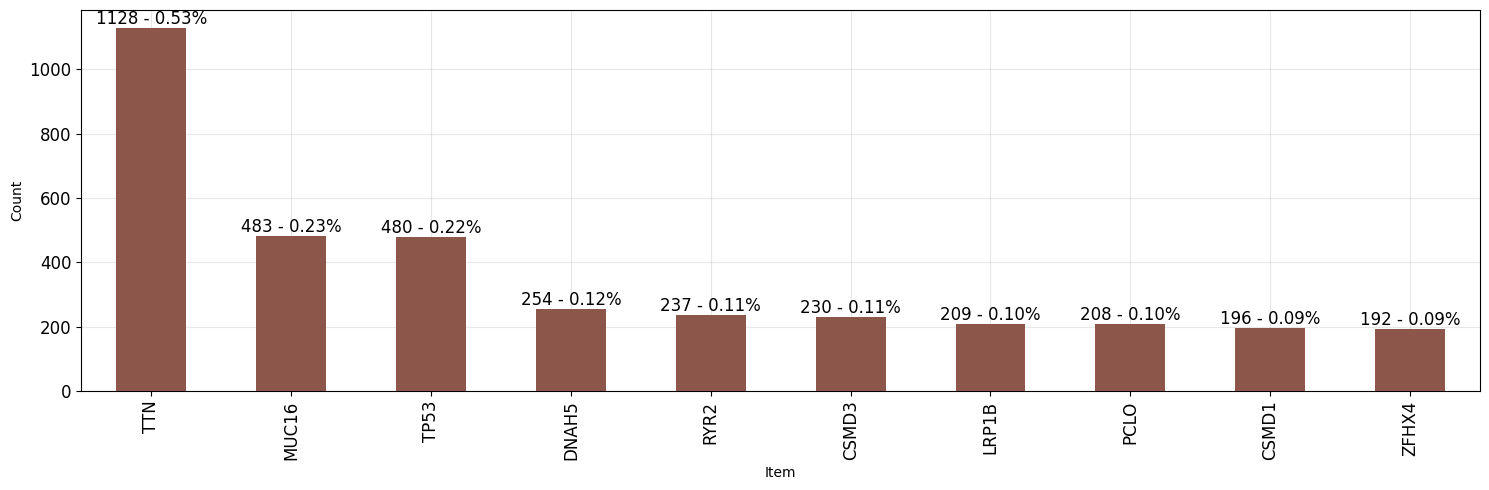

In [55]:
visualize_categorical_frequent(df_duplicates_unique_no_id,"gene",10)

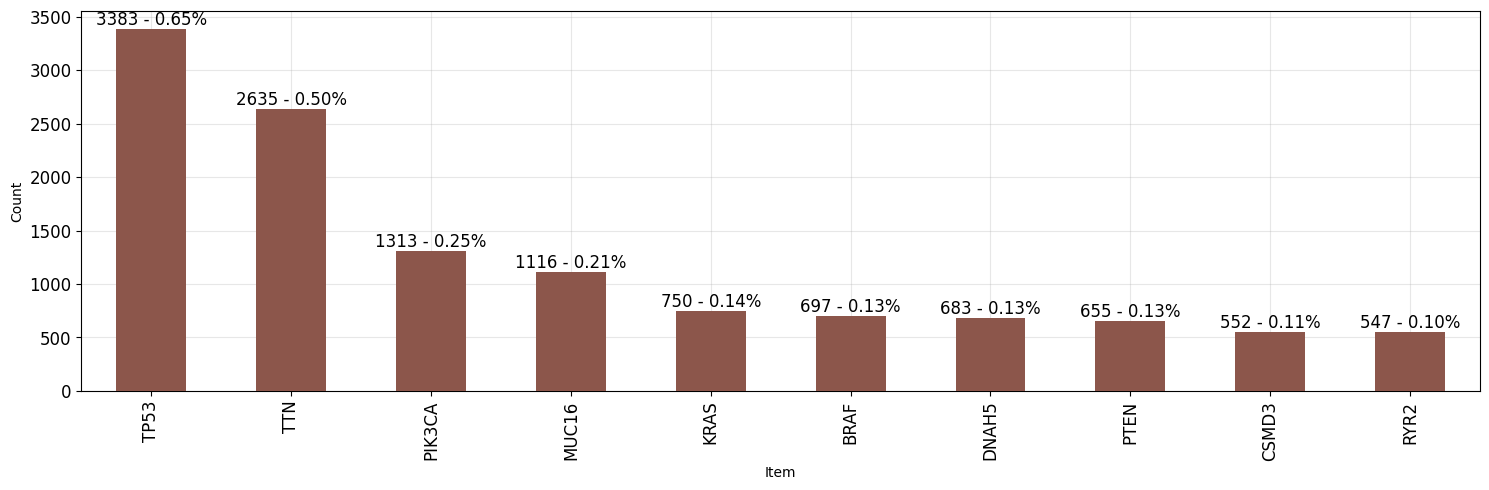

In [56]:
visualize_categorical_frequent(df_duplicates_no_id,"gene",10)

- The same gene bias is found here. Is it repeated across samples? or what
- **Remove these duplicates and keep the one with high dna_vaf but check if these samples still exist or not.**

In [57]:
duplicated = df_mut[df_mut.duplicated(subset=columns, keep="last")]
duplicated.shape

(309567, 11)

In [58]:
df_mut.shape

(3175928, 11)

In [59]:
df_mut = df_mut.sort_values(by="dna_vaf", ascending=True)
df_mut_test = df_mut.drop_duplicates(subset=columns, keep="last")

In [60]:
ids_to_check = duplicated["Sample_ID"].unique().tolist()
ids_rest = df_mut_test["Sample_ID"].unique().tolist()
not_in = []
for id in ids_to_check:
    if id not in ids_rest:
        not_in.append(id)
        print(f"{id} not found")
print(f"Total ids not found are {len(not_in)}")

TCGA-AC-A2FK-01A not found
TCGA-F2-7276-01A not found
Total ids not found are 2


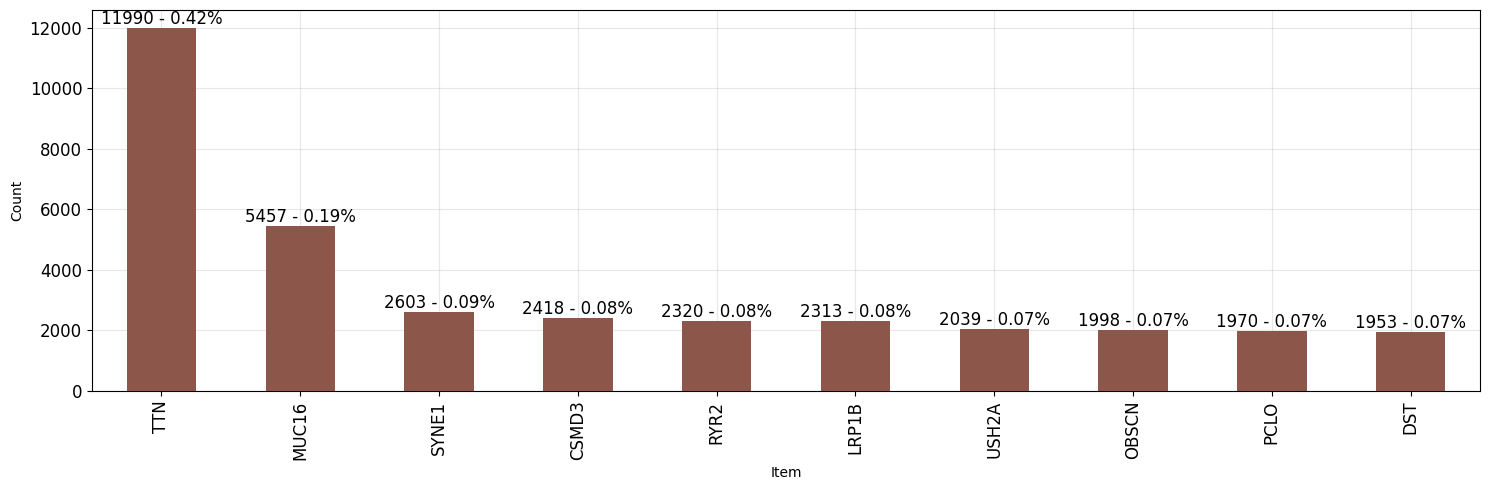

In [61]:
visualize_categorical_frequent(df_mut_test, "gene", 10)

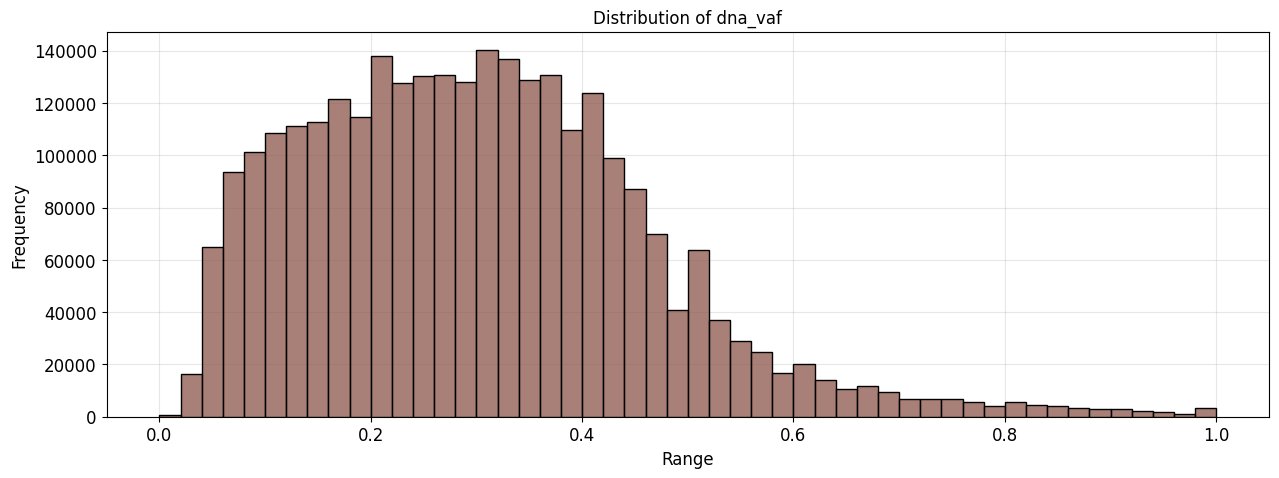

            dna_vaf
count  3.175928e+06
mean   2.959866e-01
std    1.594190e-01
min    0.000000e+00
25%    1.746032e-01
50%    2.834646e-01
75%    3.921569e-01
max    1.000000e+00


dna_vaf
count  2.866361e+06
mean   3.008320e-01
std    1.617661e-01
min    0.000000e+00
25%    1.775701e-01
50%    2.888889e-01
75%    4.000000e-01
max    1.000000e+00

In [62]:
visualize_numerical_frequent(df_mut_test, "dna_vaf", bins=50)
print(df_mut[["dna_vaf"]].describe())
df_mut_test[["dna_vaf"]].describe()

## Encoding

In [63]:
df_mut["type"] = ""

#Encoding alt - ref feature
# when ref is "-" and alt has anything except "-"
# when the letters in ref are in alt with ore letters after it. This condition does not exist in our dataset
df_mut.loc[(df_mut["ref"].str.len()) == 1 & (df_mut["alt"].str.len() == 1) & (df_mut["ref"] != "-") & (df_mut["alt"] != "-"), "type"] = "SNP"
df_mut.loc[(df_mut["ref"] == "-") | ((df_mut["alt"].str.startswith(str(df_mut["ref"]))) &(df_mut["alt"].str.len() > df_mut["ref"].str.len())), "type"] = "Insertion"
# When alt is "-"
# when alt is a substring of ref. This is not our case because when len(ref) > 1 alt equals "-" so we care about cases when alt is "-"
df_mut.loc[df_mut["alt"] == "-", "type"] = "Deletion"

In [64]:
df_mut["type"].value_counts()

type
SNP          2956550
Deletion      143455
Insertion      75923
Name: count, dtype: int64

In [65]:
# bio_palette = [
#     "#1f77b4",  # SNP
#     "#2ca02c",  # Deletion
#     "#d62728",  # Insertion
#     "#9467bd",  # Duplication – Purple
#     "#8c564b",  # Translocation – Brown
#     "#e377c2",  # Fusion – Pink
# ]
# sns.set_palette(bio_palette)
# fig, ax = plt.subplots(figsize=(15, 5), subplot_kw=dict(aspect="equal"))
# wedges, texts, autotexts = ax.pie(counts, autopct="%1.1f%%")
# ax.legend(wedges, counts.index,
#           title="Mutation Type",
#           loc="center left",
#           fontsize=13,
#           bbox_to_anchor=(1, 0, 0.5, 1))
# #plt.setp(autotexts, size=15, weight="bold")
# for autotext in autotexts:
#     autotext.set_fontsize(20)
# fig.tight_layout()
# ##plt.savefig(graph_directory + "mutation_type_frequency_pie_graph.png", dpi=300)
# plt.show()

## Bias Diagnostic

In [66]:
df_bias = df_mut.copy()
df_bias.head()

Sample_ID    gene  chrom      start        end ref  \
644278   TCGA-FA-8693-01A    MUC4   chr3  195781031  195781032   -   
2464416  TCGA-AP-A059-01A    MUC4   chr3  195781035  195781036   -   
593279   TCGA-AA-3510-01A    MUC4   chr3  195784343  195784344   -   
2894714  TCGA-BG-A0VW-01A    MUC4   chr3  195781031  195781032   -   
620006   TCGA-AM-5820-01A  PTGES3  chr12   56666188   56666189   -   

                                                       alt  \
644278   ACCGGTGGATGCCGAGGAAGCGTCGGTGACAGGAAGAGGGGTGGTG...   
2464416  GTGGATGCCGAGGAAGCGTCGGTGACAGGAAGAGGGGTGGTGTCAC...   
593279    ACCTGTGGATGCTGAGGAAGTGTCGGTGACAGGAAGAGGGGTGGTGTC   
2894714  ACCGGTGGATGCCGAGGAAGCGTCGGTGACAGGAAGAGGGGTGGTG...   
620006                     AATTTTTAGACTTAACATCATTTTTAAAACT   

                                         Amino_Acid_Change             effect  \
644278   p.G3516_H3517insDTTTLPVTDTSSVSTGHATPLPVTSFSSVS...  inframe_insertion   
2464416  p.G3516_H3517insDTTTLPVTDTSSVSTGHATPLPVTSFSSVS...  inframe_insertion   
593279                                    p.D2397_G2412dup  inframe_insertion   
2894714  p.G3516_H3517insDTTTLPVTDTSSVSTGHATPLPVTSFSSVS...  inframe_insertion   
620006                                                 NaN     intron_variant   

        filter  dna_vaf       type  
644278    PASS      0.0  Insertion  
2464416   PASS      0.0  Insertion  
593279    PASS      0.0  Insertion  
2894714   PASS      0.0  Insertion  
620006    PASS      0.0  Insertion

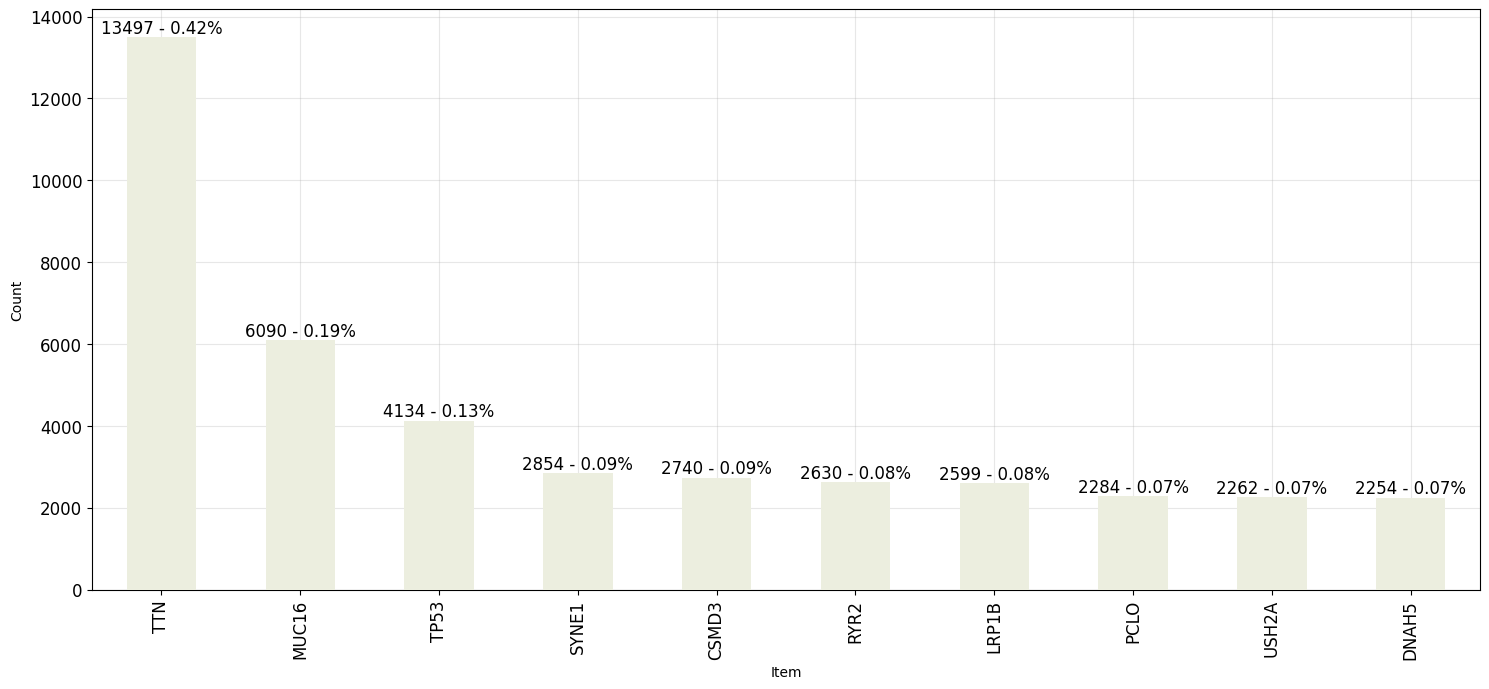

In [67]:
visualize_categorical_frequent(df_bias, "gene", 10, (15,7), color="#ECEEDF")

In [68]:
df_bias[df_bias["gene"] == "TTN"].head()

Sample_ID gene chrom      start        end ref  \
3048498  TCGA-B5-A11I-01A  TTN  chr2  178572205  178572205   C   
3048502  TCGA-B5-A11I-01A  TTN  chr2  178682810  178682811   -   
3004031  TCGA-B5-A11Y-01A  TTN  chr2  178723503  178723504   -   
3004025  TCGA-B5-A11Y-01A  TTN  chr2  178583044  178583045   -   
2964971  TCGA-B5-A11V-01A  TTN  chr2  178561545  178561546   -   

                                                       alt Amino_Acid_Change  \
3048498                                                  G         p.D23002H   
3048502              CTTCATATTCCTAAAATTATTCAATGTCTTTGACGTA     p.E10677Vfs*6   
3004031     ATATTAAATCATTTGCATTCTTCTAACATGTAGCATAGTTTCTTTG     p.D6883Kfs*14   
3004025  TGCACAGCTACTGGCCTAGAAGAGAAAGCTCAGTATCAATTTAGAG...    p.T20279Nfs*12   
2964971                                                 AG    p.R26555Tfs*20   

                                 effect filter   dna_vaf       type  
3048498                missense_variant   PASS  0.008475        SNP  
3048502  stop_gained;frameshift_variant   PASS  0.010417  Insertion  
3004031  stop_gained;frameshift_variant   PASS  0.012658  Insertion  
3004025  stop_gained;frameshift_variant   PASS  0.013699  Insertion  
2964971              frameshift_variant   PASS  0.017544  Insertion

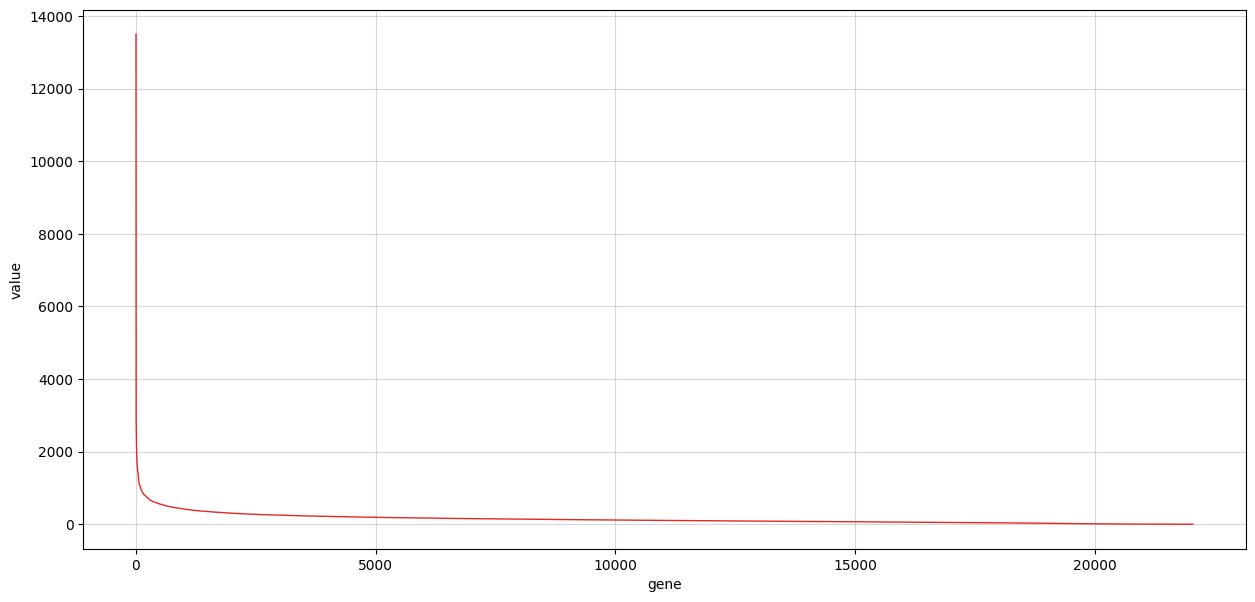

In [69]:
bio_palette = [
    "#E62727",  # Rich brown
    "#c44e52",  # Blood red
    "#dd8452",  # Terracotta orange
    "#8172b2",  # Lavender purple
    "#ccb974",  # Pollen yellow
]
sns.set_palette(bio_palette)


gene_frequency = df_mut["gene"].value_counts().tolist()
x = np.arange(len(gene_frequency))
plt.figure(figsize=(15,7))
plt.plot(x, gene_frequency, linewidth=1)
plt.xlabel("gene")
plt.ylabel("value")
#plt.title("Gene Distribution")
plt.grid(True, alpha=0.5)
##plt.savefig(graph_directory + "gene_long_tail_distribution.png", dpi=300)
plt.show()

- **The genes exhibit a long-tail distribution where the frequent genes are clustered in the head of the graph. The head, represented by the first five features, are the dominant ones. However, this cannot depict a data imbalance because the percentage is very small. This indicates that all genes are rarely exhibited in the dataset. Interestingly, out of these genes, TP53 is one of the most studied and researched gene for Synthetic Lethality.**
- **While the percentage is very low, the models might suffer from generalization due to the obvious long-tail distribution of the above plot.**
- **The large entries of the dataset along with the diversity of the genes and their low frequency compared to the number of rows introduces the concept of rare events. The model might not generalize well or might be a case of bias. It might end up being biased toward the TTN, MUC16, and TP53 genes for these mutations especially the model we are making is a classification predictive model.**
- **The behavior of the plots is the same for all different samples taken, merged, original, with pass = filter only...**
- **A solution for this can be grouping items together along with undersampling the dominant group if needed. Synthetic data is not a solution for this due to the sensivity of the project.**


**Hypothesis: The most frequent genes are due to their high length so they have more chance of having a mutation than other genes.**

In [70]:
gene_normalized_df = pd.read_csv(data_directory + "dict_gene_normalization.csv")
gene_normalized_df.dropna(subset=["gene"], inplace=True)

In [71]:
gene_normalized_df

gene     length
0               TTN   304813.0
2             MUC16   161546.0
4              TP53    25767.0
6             SYNE1   516114.0
8             CSMD3  1214011.0
...             ...        ...
44094       ARMCX7P      561.0
44096      PSMC1P10     1326.0
44098        OR4C2P     1063.0
44100      IGHV3-50      438.0
44102  RP11-495K9.3        NaN

[22052 rows x 2 columns]

In [72]:
df_bias = df_bias.merge(gene_normalized_df,on="gene")

In [73]:
df_hyp = df_bias.copy()
df_hyp["count"] = df_hyp.groupby("gene")["gene"].transform("count")
df_hyp = df_hyp.sort_values("count", ascending=False)
df_hyp_no_dup = df_hyp.drop_duplicates(subset=["gene"])
df_hyp_no_dup = df_hyp_no_dup.dropna(subset=["length"], inplace=False)

In [74]:
print(df_hyp_no_dup.isnull().sum())
df_hyp_no_dup.head()

Sample_ID               0
gene                    0
chrom                   0
start                   0
end                     0
ref                     0
alt                     0
Amino_Acid_Change    5196
effect                  0
filter                  0
dna_vaf                 0
type                    0
length                  0
count                   0
dtype: int64


Sample_ID   gene  chrom      start        end ref alt  \
2904970  TCGA-IN-A6RR-01A    TTN   chr2  178563172  178563172   C   T   
1904924  TCGA-66-2769-01A  MUC16  chr19    8937847    8937847   A   T   
1905103  TCGA-S9-A7R7-01A   TP53  chr17    7674220    7674220   C   T   
3159490  TCGA-D1-A3DG-01A  SYNE1   chr6  152455980  152455980   C   A   
456719   TCGA-B5-A1MR-01A  CSMD3   chr8  112650252  112650252   A   C   

        Amino_Acid_Change              effect            filter   dna_vaf  \
2904970         p.V26013I    missense_variant              PASS  0.507042   
1904924         p.P11036P  synonymous_variant              PASS  0.325758   
1905103           p.R248Q    missense_variant  panel_of_normals  0.325843   
3159490           p.S878I    missense_variant              PASS  0.890909   
456719           p.F1034L    missense_variant              PASS  0.123077   

        type     length  count  
2904970  SNP   304813.0  13497  
1904924  SNP   161546.0   6090  
1905103  SNP    25767.0   4134  
3159490  SNP   516114.0   2854  
456719   SNP  1214011.0   2740

- Make a graph to visualize the relationship between gene length and gene frequency. It should be a positive relationship somehow.

In [75]:
gene_length = df_hyp_no_dup["length"].tolist()
gene_count = df_hyp_no_dup["count"].tolist()

In [76]:
pearson_corr, pearson_p = pearsonr(gene_count, gene_length)
print("Pearson correlation:", pearson_corr)
print("p-value:", pearson_p)

Pearson correlation: 0.37899728643716235
p-value: 0.0


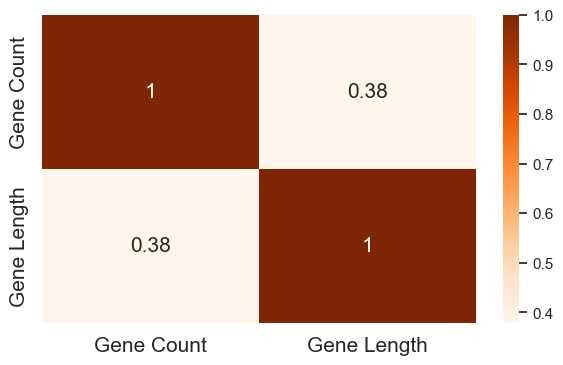

In [77]:
data = np.array([gene_count, gene_length])
plt.figure(figsize=(7,4))
corr_matrix = np.corrcoef(data)
sns.set_theme(style="white")
sns.heatmap(corr_matrix, annot=True, cmap="Oranges", xticklabels=["Gene Count", "Gene Length"], yticklabels=["Gene Count", "Gene Length"], annot_kws={"size":15})
#plt.title("Correlation Heatmap")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig(graph_directory + f"correlation_heatmap_geneLength_geneCount.png", dpi=300)
plt.show()

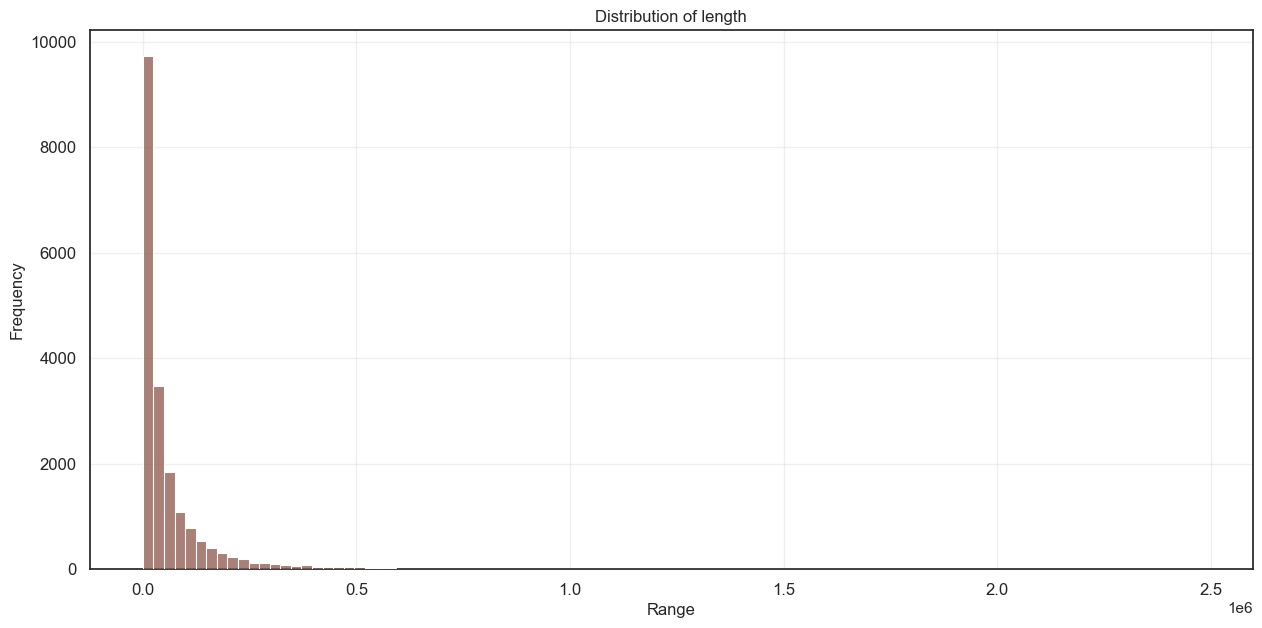

In [78]:
visualize_numerical_frequent(df_hyp_no_dup, "length", size=(15,7), bins=100)

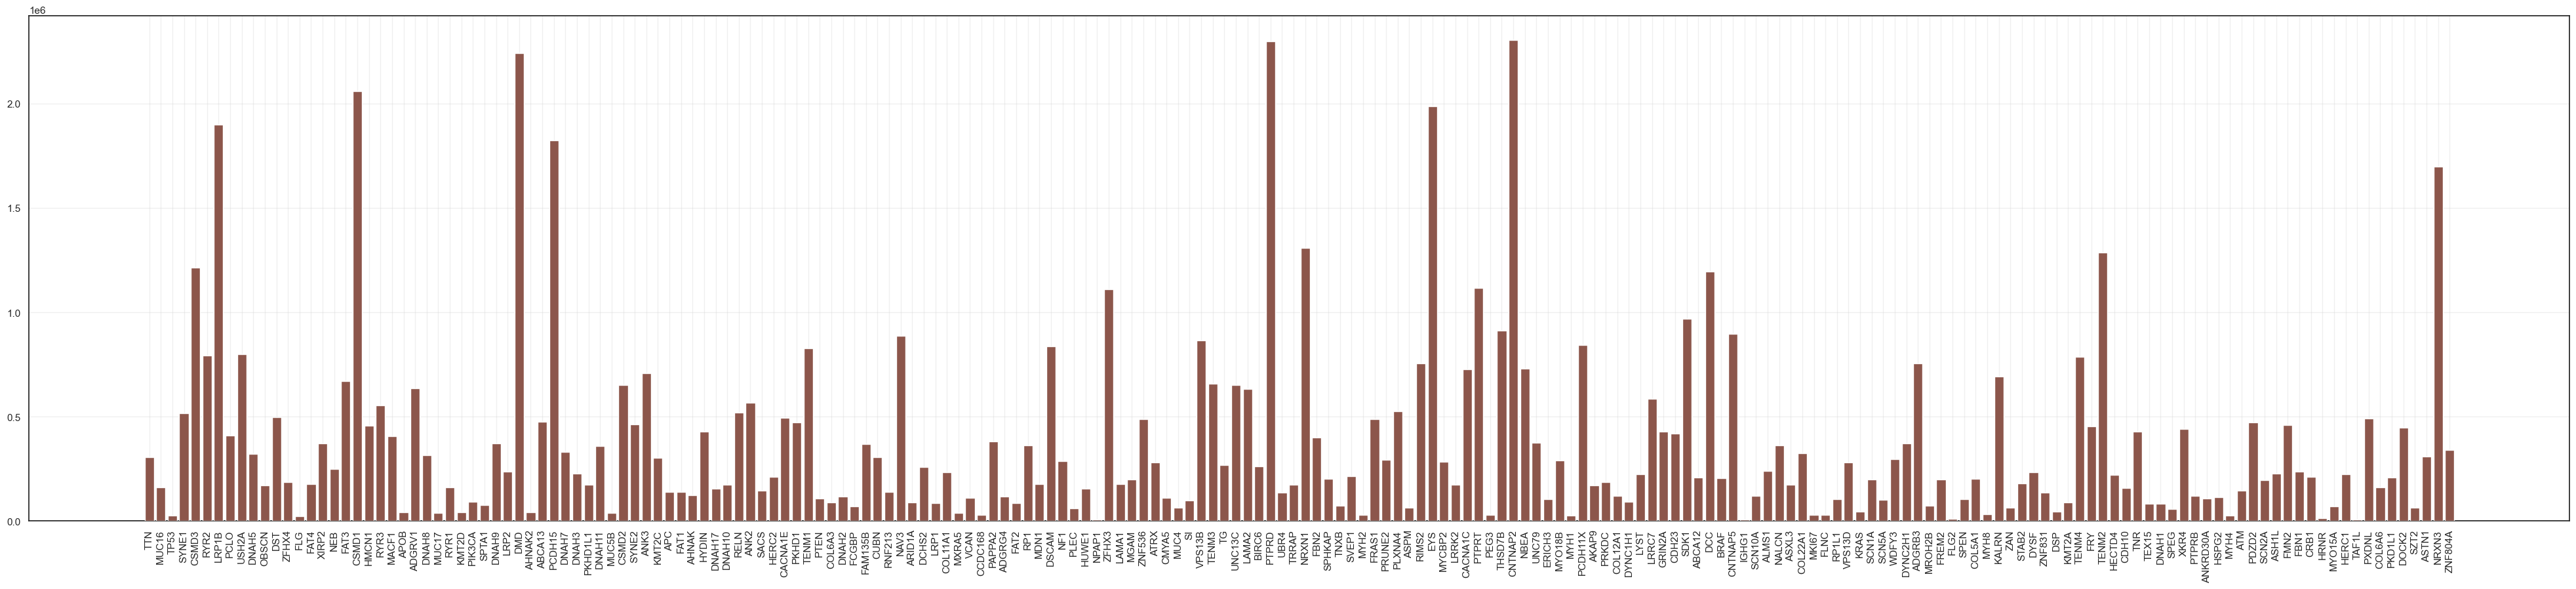

In [79]:
dfff = df_hyp_no_dup.head(200)
plt.figure(figsize=(50,10))
bars = plt.bar(dfff["gene"], dfff["length"], zorder=3)
#plt.tick_params(axis='x', which='both', labelbottom=False)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)
##plt.savefig(graph_directory + "200_most_frequent_genes_length_distribution.png", dpi=300)
plt.show()

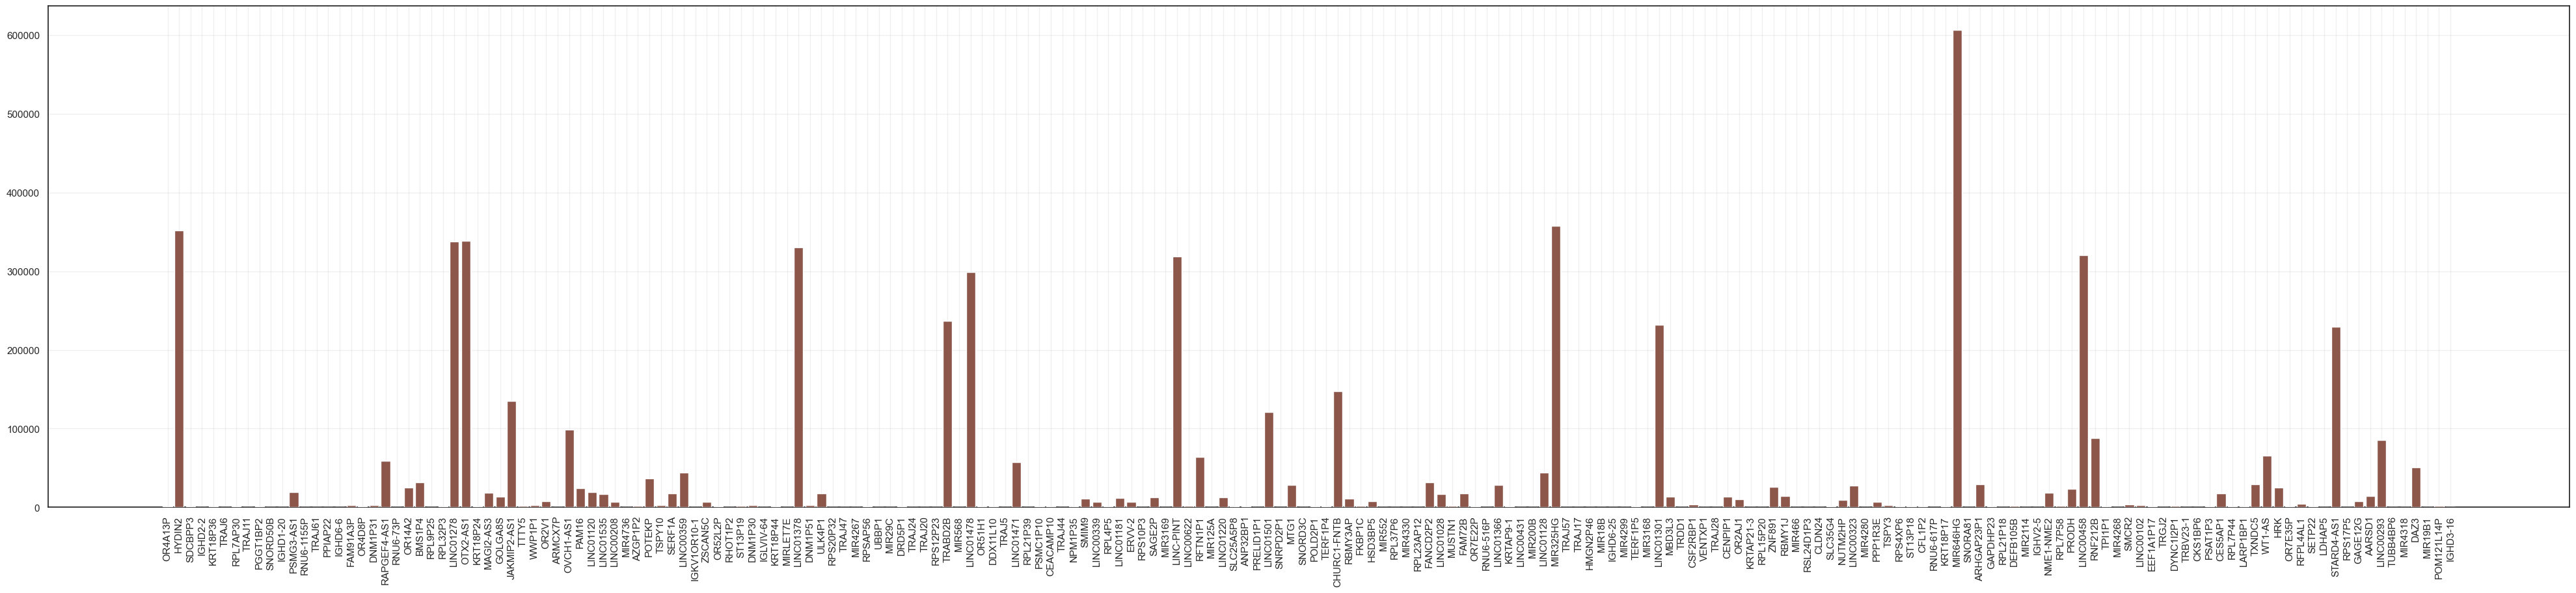

In [80]:
dfff = df_hyp_no_dup.tail(200)
plt.figure(figsize=(50,10))
bars = plt.bar(dfff["gene"], dfff["length"], zorder=3)
#plt.tick_params(axis='x', which='both', labelbottom=False)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)
#plt.savefig(graph_directory + "200_least_frequent_genes_length_distribution.png", dpi=300)
plt.show()

**Hypothesis Proved**

- **The distribution is skewed to the left. The distribution is in the same order as the most frequent genes. As genes are less frequent as their gene length decrease. This pattern is rarely not followed as there are some higher peaks than the previous ones, however, the general pattern suggests that the most frequent mutations happen in genes with the highest gene length. If mutations are length-dependent, this should be taken into account for SL labeling to avoid falsely prioritizing long genes as SL candidates. Maybe Gene Normalization should be considered?** ***Ask Dr.Gulden.***
- **When the distribution is zoomed in, there are some deviations however. For example TTN and MUC16 are the most frequent genes, yet CSMD3 and LRP1B are the largest genes.**

In [81]:
# def normalize(dataframe):
#     counts = dataframe["gene"].value_counts().to_dict()
#     genes = [*counts]
#     #result = {}
#     genes_length = {}
#     for _, gene in enumerate(genes):
#         r = requests.get(f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?content-type=application/json")
#         if r.ok:
#             print(_, end=" ")
#             #mutation_count = counts[gene]
#             data = r.json()
#             #gene_length = data["end"] - data["start"] 
#             #result[gene] = mutation_count / gene_length
#             genes_length[gene] = data["end"] - data["start"] 
#         else:
#             print(f"Failed:{_}-{gene}")
#             #result[gene] = None
#             genes_length[gene] = None
#             continue
#     return genes_length

# result = normalize(df_mut)

In [82]:
# result

In [83]:
# df_mut["mut/kb"] = df_mut["gene"].map(result)
# df_mut.head()

In [84]:
# df_mut.drop_duplicates(subset=["gene"]).isnull().sum()

**The website did not have the information of 2425 genes.**

In [85]:
# df_mut_kb = df_mut.dropna(subset=["mut/kb"])
# df_mut_kb["mut/kb"] = df_mut_kb["mut/kb"] * 1000
# print(df_mut_kb.isnull().sum())
# df_mut_kb.head()

In [86]:
# visualize_numerical_frequent(df_mut_kb, "mut/kb")
# df_mut_kb[["mut/kb"]].describe()

In [87]:
# df_mut_kb_no_duplicates_genes = df_mut.drop_duplicates(subset=["gene"]).sort_values(by="mut/kb", ascending=False)
# df_mut_kb_no_duplicates_genes[["gene"]].head(10)

- **The results do not make much sense to me especially that the mutations present in the original dataset are not spread all over the gene length so that should be taken into account. This normalization assumes that the mutation are all over the genes.**

**Conclusion: NOT RELIABLE**

In [88]:
# with open(data_directory + "dict_gene_normalization.csv", "w") as csv_file:
#     writer = csv.writer(csv_file)
#     for key, value in result.items():
#         writer.writerow([key, value])

### Mutation type

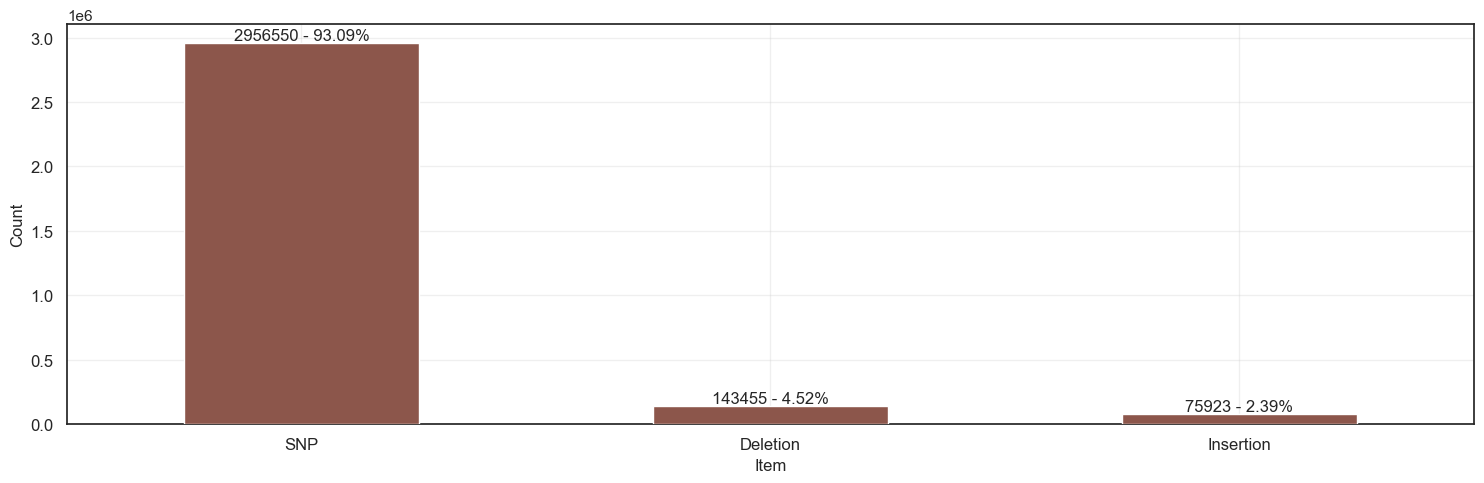

In [89]:
visualize_categorical_frequent(df_mut, "type", 3)

- **The majority of the mutations are Single-Nucleotide Polymorphism mutations.**
- **They are the most common type of genetic variation in humans. Most SNPs have no effect on health or development but they are important in the study of human health. They help to predict a patient's response to drugs, risk of developing diseases and so on.**
- **93% of the data are SNP mutations and the rest approximate 7% are more serious mutations through insertions and deletions. Insertion is very low that it can be regarded as an outlier compared to the rest of the frequencies. However, it should not be removed. Maybe downsampling is the solution.** <br /><br />
- **Is this considered a bias? What kind of effects do these SNPs exhibit in this dataset?**
- **Are deletions and insertions more reliable than SNPs?**
- **What about the dna_vaf of the SNPs?**


Source: https://medlineplus.gov/genetics/understanding/genomicresearch/snp/

In [90]:
df_mut_snp = df_mut[df_mut["type"] == "SNP"].drop(columns=["type", "ref","alt","start","end"])
print(df_mut_snp[df_mut_snp["dna_vaf"] > 0.6].shape)
df_mut_snp[["dna_vaf"]].describe()

(115893, 7)


dna_vaf
count  2.956550e+06
mean   2.970849e-01
std    1.584269e-01
min    0.000000e+00
25%    1.764706e-01
50%    2.851406e-01
75%    3.922652e-01
max    1.000000e+00

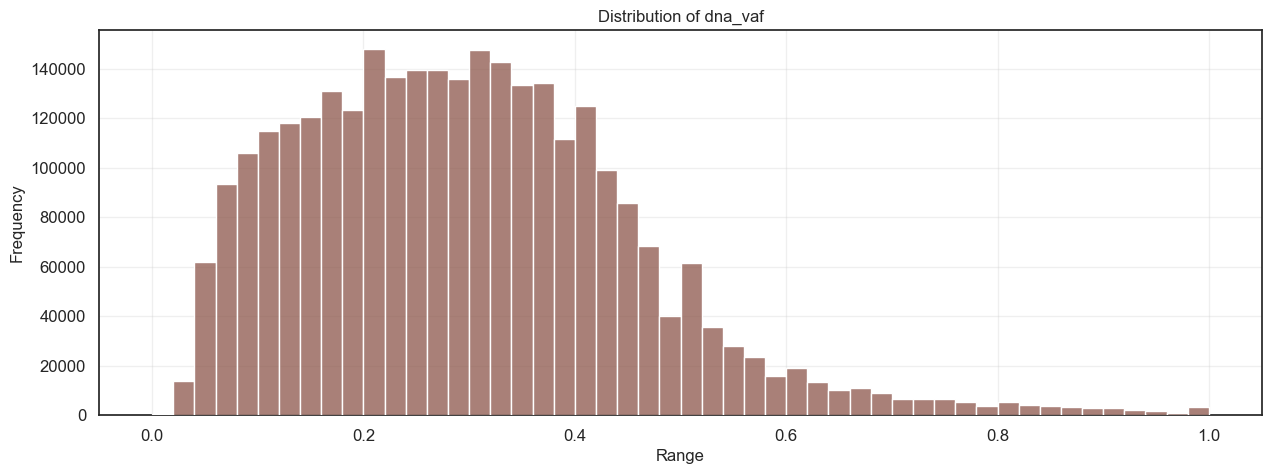

In [91]:
visualize_numerical_frequent(df_mut_snp, "dna_vaf", 50)

In [92]:
df_mut_ins = df_mut[df_mut["type"] == "Insertion"].drop(columns=["type"])
print(df_mut_ins[df_mut_ins["dna_vaf"] > 0.6].shape)
df_mut_ins[["dna_vaf"]].describe()

(1864, 11)


dna_vaf
count  75923.000000
mean       0.218759
std        0.166016
min        0.000000
25%        0.076923
50%        0.171053
75%        0.333333
max        1.000000

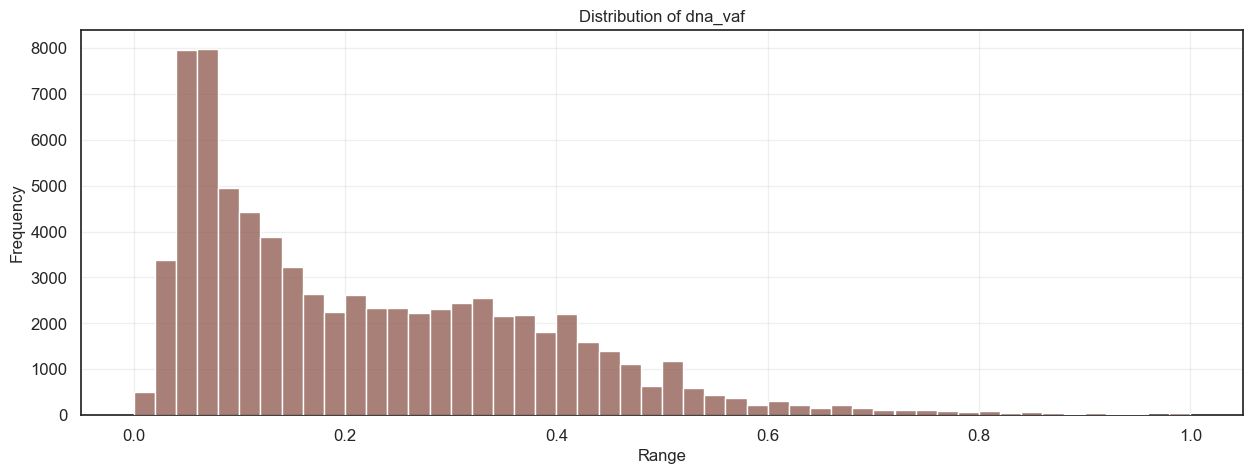

In [93]:
visualize_numerical_frequent(df_mut_ins,"dna_vaf",50)

In [94]:
df_mut_del = df_mut[df_mut["type"] == "Deletion"].drop(columns=["type"])
print(df_mut_del [df_mut_del ["dna_vaf"] > 0.6].shape)
df_mut_del [["dna_vaf"]].describe()

(7124, 11)


dna_vaf
count  143455.000000
mean        0.314222
std         0.165118
min         0.000000
25%         0.191176
50%         0.303704
75%         0.411765
max         1.000000

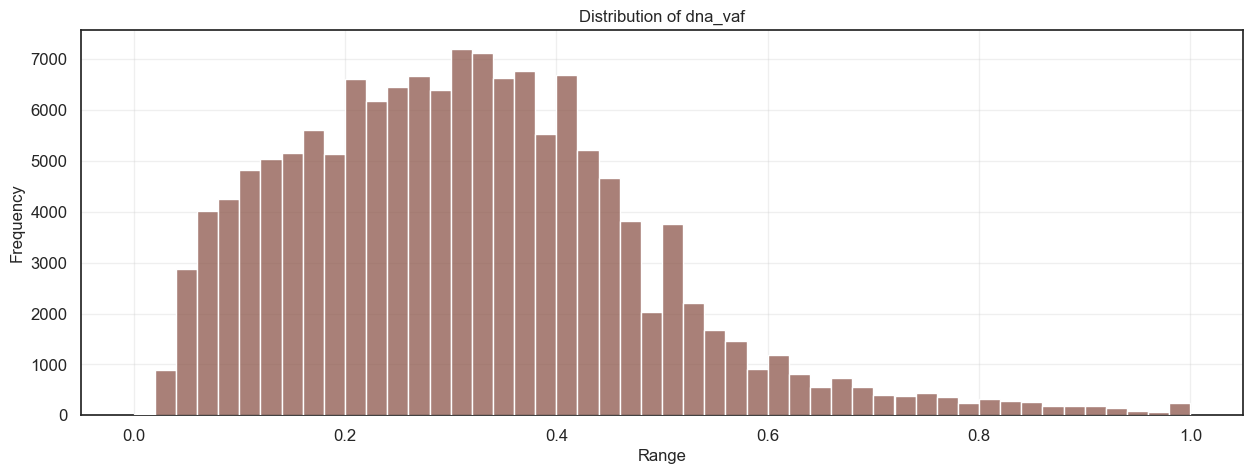

In [95]:
visualize_numerical_frequent(df_mut_del,"dna_vaf",50)

- **The three histograms reveal distinct VAF profiles across SNPs, insertions, and deletions mutation types. All distributions are right-skewed with the dominant group being in the low range of dna_vaf.**
- **SNP histogram has a peak between in the [0.2, 0.4] range. It has about 112907 entries with high dna_vaf > 0.6. The 75% percentile is approximately 0.4 indicating that most SNPs have low variant allele frequencies, suggesting they are subclonal. There is a sparsity in the high dna_vaf suggesting they are rare events.**
- **Insertion histogram exhibit stronger subclonality than the rest. 499 entries only has a high dna_vaf value. The concetration at ultra low values in insertions dna_vaf is alarming. Why? Is it related only to the insertion mutation?**
- **Deletion histogram follow the same behavior as SNP mutations.**

**Some of the low dna_vaf might be due to noise, artifacts, and so on. Outlier detection must be applied and a final filter must be set. This can reduce the bias towards the low dna_vaf.**

Source: https://pubmed.ncbi.nlm.nih.gov/29178133/

### high dna_vaf vs. low dna_vaf

In [96]:
inner_low, inner_high = calculate_fence(df_mut, "dna_vaf", 1.5)
outer_low, outer_high = calculate_fence(df_mut, "dna_vaf", 3)
print(f"The fences of mild and extreme outliers are inner_low: {inner_low}, inner_high: {inner_high}, outer_low:{outer_low}, outer_high: {outer_high}")
outlier_df = df_mut[(df_mut["dna_vaf"] < inner_low) | (df_mut["dna_vaf"] > inner_high)]
outlier_df.head()

The fences of mild and extreme outliers are inner_low: -0.1517273576097105, inner_high: 0.7184873949579831, outer_low:-0.4780578898225956, outer_high: 1.0448179271708682


Sample_ID      gene  chrom      start        end ref alt  \
1662662  TCGA-GN-A267-06A    HOMER2  chr15   82859119   82859119   C   T   
1941590  TCGA-EE-A2MF-06A  ARHGAP10   chr4  147939822  147939822   T   A   
736663   TCGA-19-1787-01B    TMEM95  chr17    7355910    7355910   C   -   
2036483  TCGA-D3-A8GI-06A      GGA1  chr22   37631088   37631088   C   T   
843994   TCGA-CV-6950-01A  TRAV12-1  chr14   21841712   21841712   T   A   

        Amino_Acid_Change                                effect filter  \
1662662           p.G146E                      missense_variant   PASS   
1941590               NaN  splice_region_variant;intron_variant   PASS   
736663       p.R101Gfs*61                    frameshift_variant   PASS   
2036483           p.S506F                      missense_variant   PASS   
843994             p.I92N                      missense_variant   PASS   

          dna_vaf      type  
1662662  0.718487       SNP  
1941590  0.718519       SNP  
736663   0.718519  Deletion  
2036483  0.718519       SNP  
843994   0.718519       SNP

In [97]:
outlier_df.shape

(57406, 12)

In [98]:
df_mut.shape

(3175928, 12)

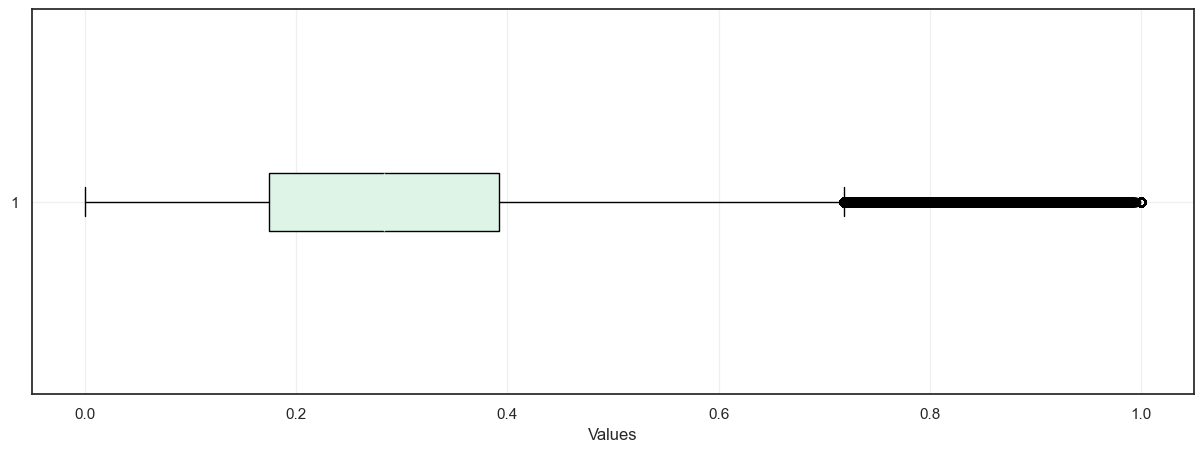

In [99]:
sns.set_palette(["#DDF4E7"])
plt.figure(figsize=(15,5))
plt.boxplot(df_mut["dna_vaf"], vert=False, patch_artist=True)
plt.grid(True, alpha=0.3)
plt.xlabel("Values")
#plt.savefig(graph_directory + "boxplot_dna_vaf.png", dpi=300)
plt.show()

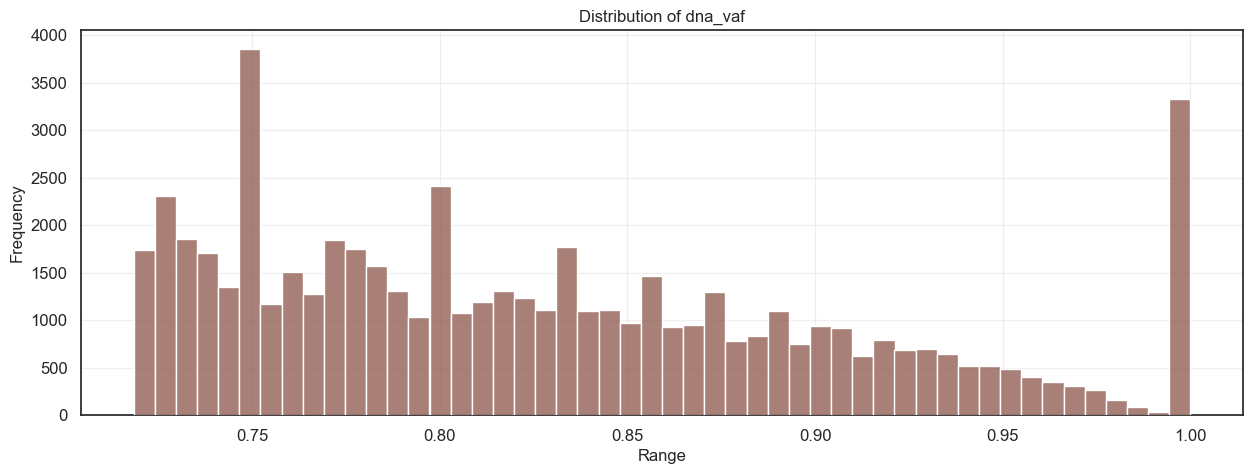

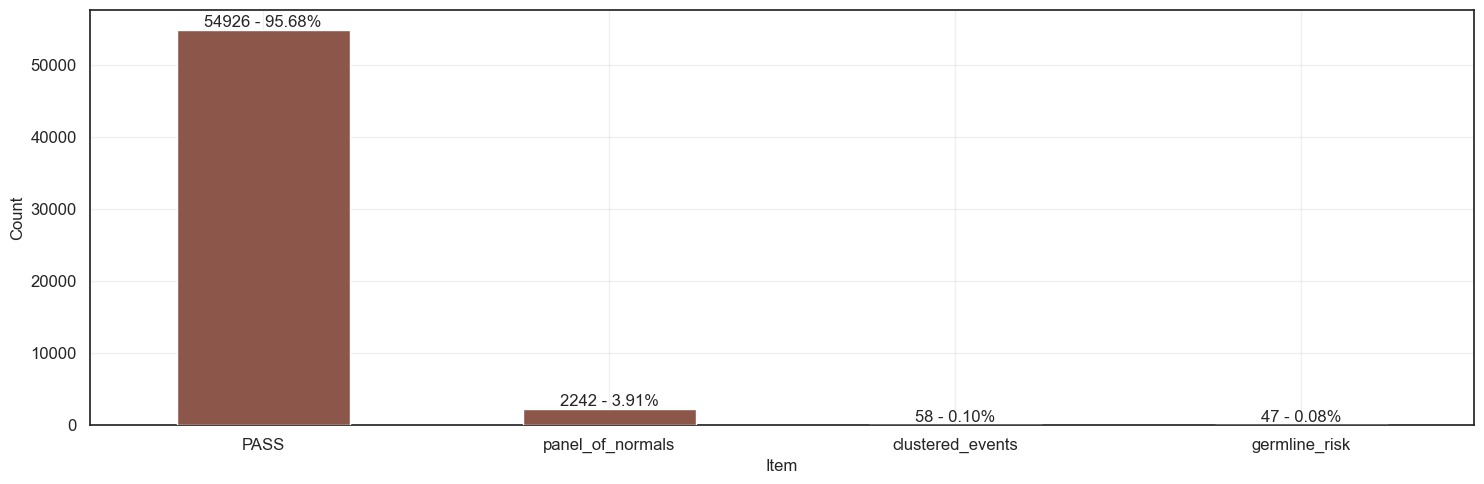

In [100]:
visualize_numerical_frequent(outlier_df, "dna_vaf", 50)
visualize_categorical_frequent(outlier_df, "filter", 4)

High dna_vaf gene frequency
(57406, 12)


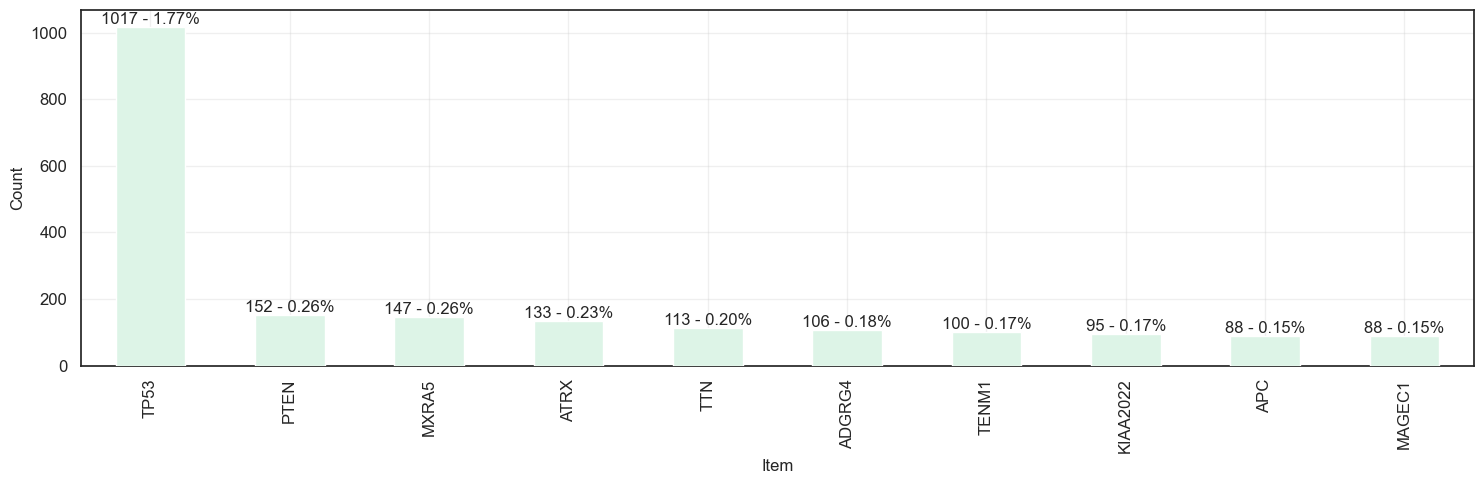

In [101]:
print("High dna_vaf gene frequency")
print(outlier_df.shape)
visualize_categorical_frequent(outlier_df, "gene", 10, color="#DDF4E7")

Low dna_vaf gene frequency
(320358, 12)


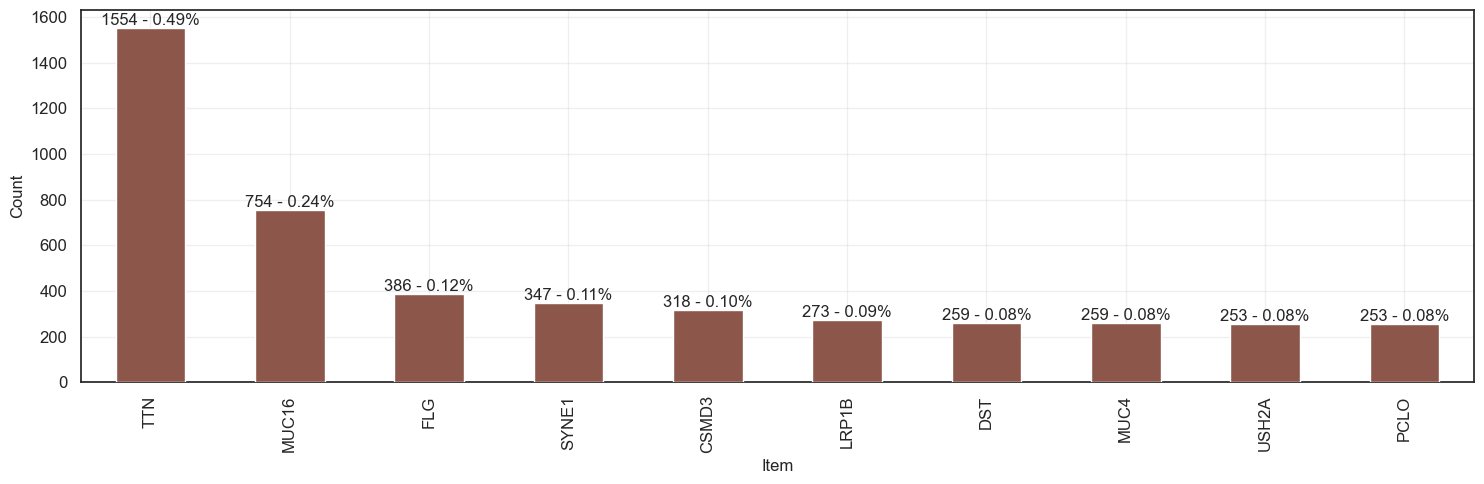

In [102]:
low_vaf_df = df_mut[df_mut["dna_vaf"] <= 0.1]
print("Low dna_vaf gene frequency")
print(low_vaf_df.shape)
visualize_categorical_frequent(low_vaf_df, "gene", 10)

In [103]:
low_vaf_df[["dna_vaf"]].describe()

dna_vaf
count  320358.000000
mean        0.071301
std         0.018850
min         0.000000
25%         0.057143
50%         0.073171
75%         0.086957
max         0.100000

High dna_vaf:
- **TP53 is the gene with the highest dna_vaf value. 1017 occurences where the dna_vaf value is in the range of [0.7, 1.0].**
- **As expected here, there is a high frequent gene than the rest. In this case it is TP53, a gene that produces a tumor suppressor protein called p53. This is one of the most frequently occuring genes in the whole dataset. It can be concluded that there is a consistency of patterns embedded in all different samples (dataframes) taken from the main mutation dataset. This can be interpreted as the main bias in this dataset: more frequent genes than others such as the TP53 and TTN genes.**

Low dna_vaf:
- **TTN is the gene with the highest dna_vaf value. 1554 occurences where the dna_vaf value is in the range of [0, 0.1].**
- **The genes follow the long-tail distribution here as well where some genes are more frequent than the rest.**
- **Except TTN, the most frequent genes with high dna_vaf are not the most frequent genes with low dna_vaf. The high dna_vaf are usually founder mutations present in most tumour cells. The low dna_vaf genes are mostly for passenger mutations or more context-dependent alterations. The gene bias in this dataset exists for both high dna_val and low dna_val. However most genes are concentrated in low to medium dna_vaf.**

In [104]:
df_mut["gene"].value_counts()

gene
TTN          13497
MUC16         6090
TP53          4134
SYNE1         2854
CSMD3         2740
             ...  
TSPY10           1
LINC01220        1
RBMY1F           1
MRPS21P6         1
LINC01501        1
Name: count, Length: 22052, dtype: int64

In [105]:
len(df_mut["gene"].unique().tolist())

22052

In [106]:
def gene_info(df, genes):
    df_gene = df_mut[df_mut["gene"].isin(genes)]
    for gene in genes:
        nbe_gene = df_mut[df_mut["gene"] == gene].shape[0]
        print(f"The number of {gene} mutations are {nbe_gene}")
    print(f"The shape of the whole dataframe is: {df_gene.shape}")
    return df_gene

In [107]:
gene_info(df_mut, ["BRCA1","BRCA2"]).head()

The number of BRCA1 mutations are 377
The number of BRCA2 mutations are 745
The shape of the whole dataframe is: (1122, 12)


Sample_ID   gene  chrom     start       end  \
3111884  TCGA-AP-A051-01A  BRCA2  chr13  32363352  32363352   
1008272  TCGA-2V-A95S-01A  BRCA2  chr13  32337801  32337822   
1185753  TCGA-93-A4JQ-01A  BRCA1  chr17  43093186  43093186   
1591466  TCGA-AG-3906-01A  BRCA2  chr13  32332528  32332528   
1463803  TCGA-13-0921-01A  BRCA1  chr17  43092846  43092846   

                            ref alt Amino_Acid_Change              effect  \
3111884                       C   T          p.A2717V    missense_variant   
1008272  TGACTATCTTAAAGACCACTTC   -     p.T1150Rfs*11  frameshift_variant   
1185753                       C   T           p.S782N    missense_variant   
1591466                       A   G           p.E350E  synonymous_variant   
1463803                       T   C           p.Q895Q  synonymous_variant   

        filter   dna_vaf      type  
3111884   PASS  0.027829       SNP  
1008272   PASS  0.029661  Deletion  
1185753   PASS  0.032129       SNP  
1591466   PASS  0.036855       SNP  
1463803   PASS  0.040573       SNP

In [108]:
gene_info(df_mut, ["TP53"]).head()

The number of TP53 mutations are 4134
The shape of the whole dataframe is: (4134, 12)


Sample_ID  gene  chrom    start      end ref alt  \
1502430  TCGA-IB-A5ST-01A  TP53  chr17  7674221  7674221   G   A   
1438859  TCGA-61-2113-01A  TP53  chr17  7669624  7669624   C   T   
1503756  TCGA-Z5-AAPL-01A  TP53  chr17  7674248  7674248   T   C   
1498592  TCGA-HZ-8002-01A  TP53  chr17  7673740  7673741  CC   -   
2059167  TCGA-CG-5716-01A  TP53  chr17  7669610  7669611  CA   -   

        Amino_Acid_Change                        effect  \
1502430           p.R248W              missense_variant   
1438859           p.G389G            synonymous_variant   
1503756           p.N239D              missense_variant   
1498592      p.E294Afs*11            frameshift_variant   
2059167           p.*394T  frameshift_variant;stop_lost   

                               filter   dna_vaf      type  
1502430  panel_of_normals;t_lod_fstar  0.030151       SNP  
1438859                          PASS  0.031496       SNP  
1503756                          PASS  0.037500       SNP  
1498592                          PASS  0.038298  Deletion  
2059167                          PASS  0.040609  Deletion

In [109]:
gene_info(df_mut, ["ARID1A"]).head()

The number of ARID1A mutations are 1121
The shape of the whole dataframe is: (1121, 12)


Sample_ID    gene chrom     start       end  ref alt  \
604984   TCGA-AA-A00N-01A  ARID1A  chr1  26731298  26731298    G   A   
1721811  TCGA-FR-A726-01A  ARID1A  chr1  26766334  26766334    C   T   
1721812  TCGA-FR-A726-01A  ARID1A  chr1  26766335  26766335    C   T   
2336667  TCGA-A5-A0GI-01A  ARID1A  chr1  26779041  26779043  CTC   -   
1109436  TCGA-NJ-A4YP-01A  ARID1A  chr1  26731383  26731383    C   T   

        Amino_Acid_Change              effect filter   dna_vaf      type  
604984            p.S499S  synonymous_variant   PASS  0.029762       SNP  
1721811           p.S949F    missense_variant   PASS  0.030457       SNP  
1721812           p.S949S  synonymous_variant   PASS  0.030612       SNP  
2336667        p.L1716del    inframe_deletion   PASS  0.033175  Deletion  
1109436           p.Q528*         stop_gained   PASS  0.034602       SNP

In [110]:
gene_info(df_mut, ["PTEN"]).head()

The number of PTEN mutations are 1185
The shape of the whole dataframe is: (1185, 12)


Sample_ID  gene  chrom     start       end   ref alt  \
891486   TCGA-BP-5199-01A  PTEN  chr10  87960984  87960984     C   T   
1026220  TCGA-DD-A1EH-01A  PTEN  chr10  87965537  87965540  TTTT   -   
1442406  TCGA-20-1687-01A  PTEN  chr10  87952260  87952260     G   T   
951723   TCGA-QH-A6X3-01A  PTEN  chr10  87864513  87864513     G   C   
1012513  TCGA-DD-A1EE-01A  PTEN  chr10  87863113  87863113     G   A   

        Amino_Acid_Change                effect            filter   dna_vaf  \
891486            p.Q298*           stop_gained  clustered_events  0.043269   
1026220               NaN   3_prime_UTR_variant              PASS  0.046875   
1442406     p.X212_splice  splice_donor_variant              PASS  0.047368   
951723             p.R15T      missense_variant              PASS  0.050633   
1012513               NaN   5_prime_UTR_variant              PASS  0.054054   

             type  
891486        SNP  
1026220  Deletion  
1442406       SNP  
951723        SNP  
1012513       SNP

In [111]:
gene_info(df_mut, ["YES1","ABL1","FYN","ABL2","LCK","STAT5B","KIT","EPHA2"]).head()

The number of YES1 mutations are 174
The number of ABL1 mutations are 285
The number of FYN mutations are 171
The number of ABL2 mutations are 309
The number of LCK mutations are 164
The number of STAT5B mutations are 161
The number of KIT mutations are 402
The number of EPHA2 mutations are 345
The shape of the whole dataframe is: (2011, 12)


Sample_ID   gene chrom      start        end ref  \
2982356  TCGA-D1-A102-01A   ABL2  chr1  179108184  179108185   -   
1471204  TCGA-13-1510-01A  EPHA2  chr1   16148981   16148982   -   
28448    TCGA-GV-A6ZA-01A    KIT  chr4   54695585   54695586   -   
2550752  TCGA-D1-A0ZR-01A   ABL2  chr1  179110810  179110811   -   
2896309  TCGA-AP-A0LF-01A    KIT  chr4   54736611   54736611   T   

                                                 alt Amino_Acid_Change  \
2982356  TTAATCAAAAAGACACTGGGCTTACGAGCAGGTAAACCCACAG     p.G1028Afs*53   
1471204                                TCTCAGCTTACTG        p.S74Qfs*2   
28448                         GTCCGCGTGGGCGGACTTAATT       p.D52Gfs*11   
2550752            GTATGTATCATCTTTACAGTTCCGTCAAAAACT               NaN   
2896309                                            G     p.X866_splice   

                                 effect filter   dna_vaf       type  
2982356              frameshift_variant   PASS  0.006944  Insertion  
1471204  stop_gained;frameshift_variant   PASS  0.024155  Insertion  
28448                frameshift_variant   PASS  0.026316  Insertion  
2550752                  intron_variant   PASS  0.028571  Insertion  
2896309            splice_donor_variant   PASS  0.031481        SNP

### Cancer Feature

In [112]:
df_phenotype = pd.read_csv(data_directory + "GDC-PANCAN Phenotype Data.tsv", delimiter="\t")
print(df_phenotype[["sample"]].duplicated().sum())
df_phenotype.head()

0


sample program  sample_type_id  \
0      TCGA-69-7978-01A    TCGA               1   
1      TCGA-AR-A24Z-01A    TCGA               1   
2      TCGA-D1-A103-01A    TCGA               1   
3  TARGET-20-PASRLS-09A  TARGET               9   
4  TARGET-20-PASARK-14A  TARGET              14   

                                  sample_type  project_id  \
0                               Primary Tumor   TCGA-LUAD   
1                               Primary Tumor   TCGA-BRCA   
2                               Primary Tumor   TCGA-UCEC   
3  Primary Blood Derived Cancer - Bone Marrow  TARGET-AML   
4                          Bone Marrow Normal  TARGET-AML   

   Age at Diagnosis in Years  Gender  
0                  59.000000    Male  
1                  57.000000  Female  
2                  87.000000  Female  
3                   0.816438  Female  
4                  15.520548    Male

In [113]:
df_phenotype[["sample"]].value_counts().to_dict()

{('TARGET-15-PAREAT-09A',): 1,
 ('TARGET-15-PAREAT-09B',): 1,
 ('TARGET-15-PAREAT-15A',): 1,
 ('TARGET-15-PARUIF-09A',): 1,
 ('TARGET-15-PARUIF-14A',): 1,
 ('TARGET-15-PARWPU-09A',): 1,
 ('TARGET-15-PARWPU-09A.1',): 1,
 ('TARGET-15-PARWPU-09A.2',): 1,
 ('TARGET-15-PARWPU-09A.3',): 1,
 ('TARGET-15-PARWPU-09B',): 1,
 ('TARGET-15-PARWPU-14A',): 1,
 ('TARGET-15-PASZVW-09A',): 1,
 ('TARGET-15-PASZVW-09B',): 1,
 ('TARGET-15-PASZVW-14A',): 1,
 ('TARGET-15-PAUFIB-09A',): 1,
 ('TARGET-15-PAUFIB-09B',): 1,
 ('TARGET-15-PAUFIB-15A',): 1,
 ('TARGET-15-PAVFTF-09A',): 1,
 ('TARGET-15-PAVFTF-09B',): 1,
 ('TARGET-15-PAVFTF-14A',): 1,
 ('TARGET-15-SJMLL003311-09A.1',): 1,
 ('TARGET-15-SJMLL003311-09A.2',): 1,
 ('TARGET-15-SJMLL003311-14A',): 1,
 ('TARGET-15-SJMPAL003414-04A',): 1,
 ('TARGET-15-SJMPAL003414-04A.1',): 1,
 ('TARGET-15-SJMPAL004013-04A',): 1,
 ('TARGET-15-SJMPAL004013-04A.1',): 1,
 ('TARGET-15-SJMPAL004013-15A',): 1,
 ('TARGET-15-SJMPAL005001-04A',): 1,
 ('TARGET-15-SJMPAL011911-03A',): 1,

In [114]:
counts = df_phenotype["sample"].value_counts().to_dict()
unique_samples_pheno = [*counts]
unique_samples_pheno.sort()
counts_mut = df_mut.drop_duplicates(subset=["Sample_ID"])["Sample_ID"].value_counts().to_dict()
unique_samples_mut = [*counts_mut]
unique_samples_mut.sort()
for sample in unique_samples_mut:
    if(sample not in unique_samples_pheno):
        print(sample + " not found")
        break

- **All samples in the mutation dataset are included in the phenotype dataset.**

In [115]:
sample_cancer = df_phenotype[df_phenotype["sample"].isin(unique_samples_mut)].sort_values(by="sample")["project_id"].tolist()
sample_cancer = [sample.split("-")[1] for sample in sample_cancer]
cancers = dict(zip(unique_samples_mut, sample_cancer))
df_mut["cancer"] = df_mut["Sample_ID"].map(cancers)
df_mut[["Sample_ID","cancer"]].head(10)

Sample_ID cancer
644278   TCGA-FA-8693-01A   DLBC
2464416  TCGA-AP-A059-01A   UCEC
593279   TCGA-AA-3510-01A   COAD
2894714  TCGA-BG-A0VW-01A   UCEC
620006   TCGA-AM-5820-01A   COAD
2260792  TCGA-2G-AAH3-01A   TGCT
3119958  TCGA-AJ-A3OL-01A   UCEC
1024093  TCGA-DD-A4NS-01A   LIHC
2258945  TCGA-2G-AAGC-01A   TGCT
996995   TCGA-EP-A2KA-01A   LIHC

In [116]:
# df_mut["case_id"] = df_mut["Sample_ID"].str[:12]
# case_ids = df_mut["case_id"].unique().tolist()

In [117]:
# mapping_records = []
# filters = {
#     "op": "in",
#     "content": {
#         "field": "cases.submitter_id",
#         "value": case_ids
#     }
# }
# payload = {
#     "filters": filters,
#     "fields": "submitter_id,project.project_id,primary_site,disease_type",
#     "format": "JSON",
#     "size": len(case_ids)
# }
# response = requests.post(
#     "https://api.gdc.cancer.gov/cases",
#     json=payload
# )
# response.raise_for_status()

# hits = response.json()["data"]["hits"]
# for case in hits:
#     mapping_records.append({
#         "case_id":       case["submitter_id"],
#         "TCGA_Study":    case["project"]["project_id"],
#     })

# mapping_df = pd.DataFrame(mapping_records).drop_duplicates(subset="case_id")

In [118]:
# mapping_df["Cancer"] = mapping_df["TCGA_Study"].str[5:]

In [119]:
# mapping_df.head()

In [120]:
# mapping_df.drop(columns=["TCGA_Study"], inplace=True)

In [121]:
# df = df_mut.merge(mapping_df,on="case_id").drop(columns=["case_id"])
# df.tail()

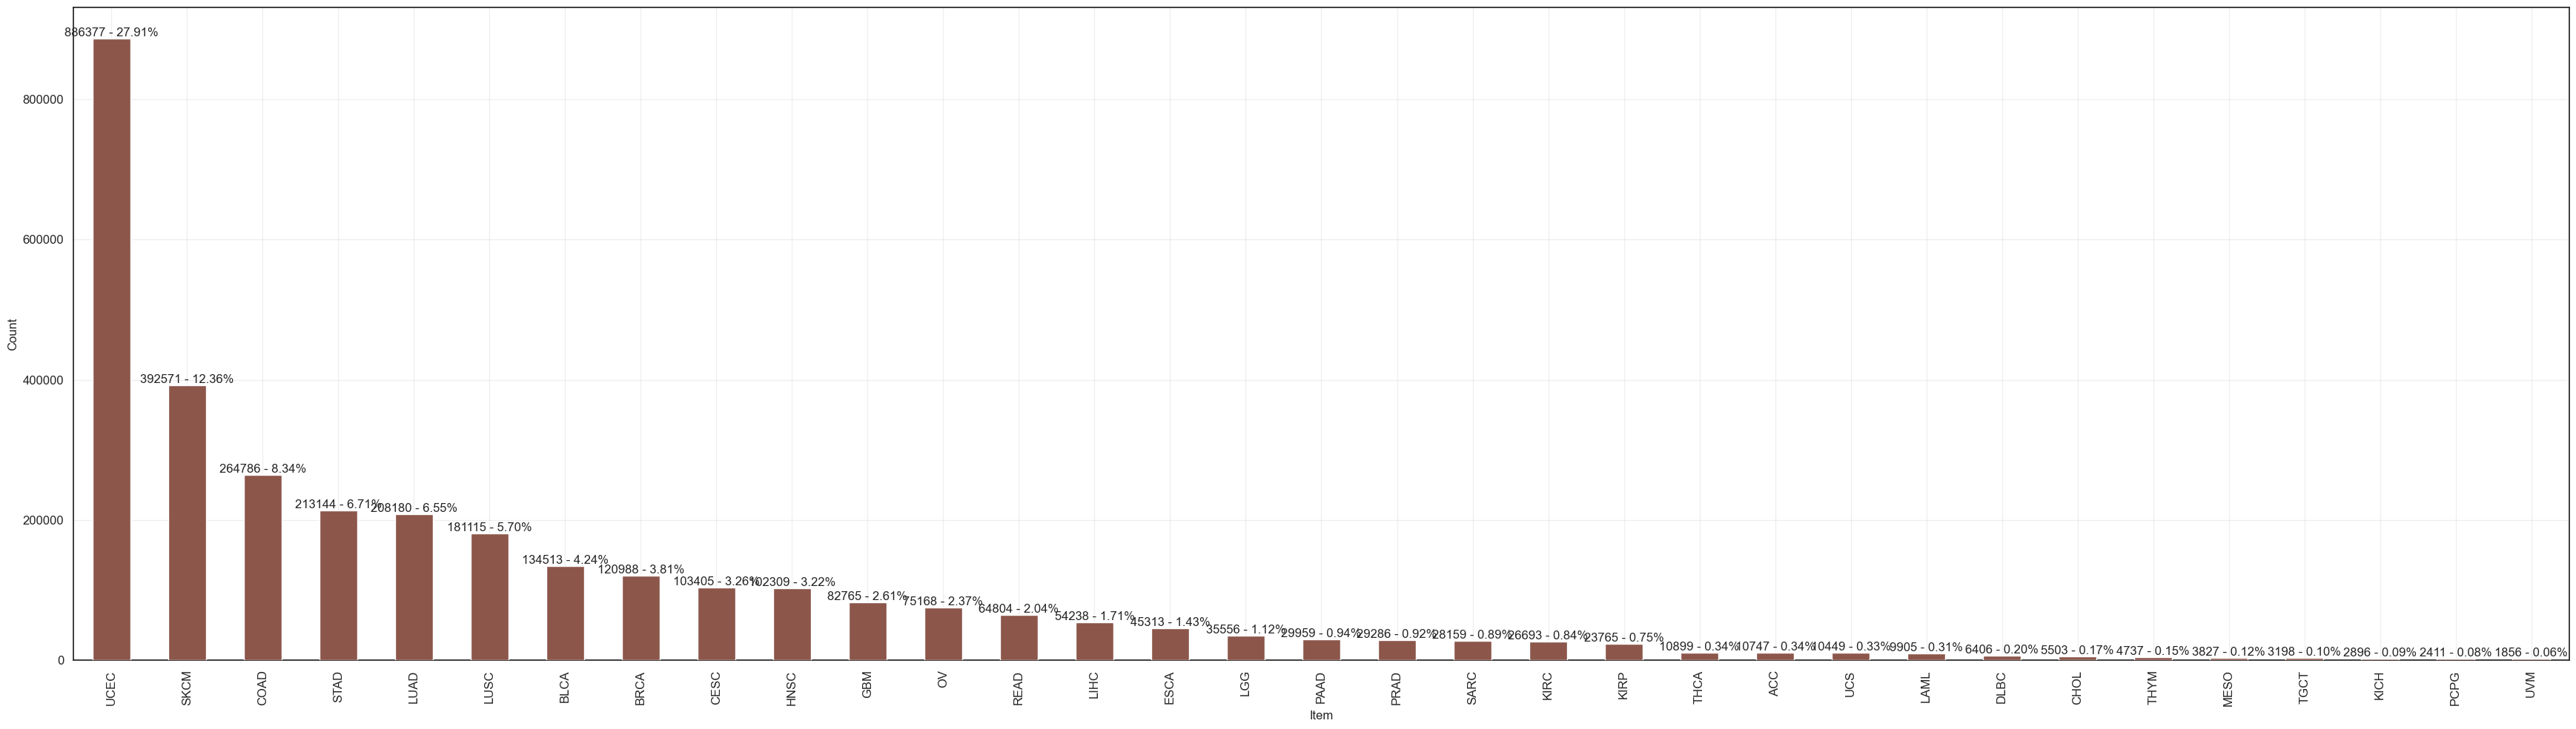

In [122]:
visualize_categorical_frequent(df_mut,"cancer",33, (35,10))

- **There is a big data imbalance concerning cancer types where some dominate the dataset such as COAD, BRCA, LUAD, UCEC, OV and others are considered as rare occurences in the dataset such as UVM,THYM, and PCPG. As it happens with Seale et al. the models might not perform well at all, close to random guessing, with cancer types of low entries. Especially that the gene pairs are not generated yet which will decrease the displayed occurences in this graph.**

#### UCEC Cancer

In [123]:
df_ucec = df_mut[df_mut["cancer"] == "UCEC"]
df_ucec.head()

Sample_ID      gene chrom      start        end ref  \
2464416  TCGA-AP-A059-01A      MUC4  chr3  195781035  195781036   -   
2894714  TCGA-BG-A0VW-01A      MUC4  chr3  195781031  195781032   -   
3119958  TCGA-AJ-A3OL-01A      MUC4  chr3  195785008  195785009   -   
2551014  TCGA-D1-A0ZR-01A  SECISBP2  chr9   89334555   89334556   -   
2982272  TCGA-D1-A102-01A     ZMYM4  chr1   35361682   35361683   -   

                                                       alt  \
2464416  GTGGATGCCGAGGAAGCGTCGGTGACAGGAAGAGGGGTGGTGTCAC...   
2894714  ACCGGTGGATGCCGAGGAAGCGTCGGTGACAGGAAGAGGGGTGGTG...   
3119958   TGGCGTGACCTGTGGATGCTGAGGAAGTGTCGATGACAGGAAGAGAGC   
2551014  ACAGACATTATCTACAGAACTGTCAGCAACACTACTCCTTTAGGTG...   
2982272  CAAATACAAATAAAGACCCTAAGATTTGAGGCTTTTTAGAATGTCT...   

                                         Amino_Acid_Change  \
2464416  p.G3516_H3517insDTTTLPVTDTSSVSTGHATPLPVTSFSSVS...   
2894714  p.G3516_H3517insDTTTLPVTDTSSVSTGHATPLPVTSFSSVS...   
3119958                   p.A2190_T2191insSSLPVIDTSSASTGHA   
2551014                p.A314_A315insTLLL*VPMKLYIQTLSTELSA   
2982272                p.N246_I247insTNKDPKI*GFLECLR**P*TN   

                                effect filter  dna_vaf       type cancer  
2464416              inframe_insertion   PASS      0.0  Insertion   UCEC  
2894714              inframe_insertion   PASS      0.0  Insertion   UCEC  
3119958              inframe_insertion   PASS      0.0  Insertion   UCEC  
2551014  stop_gained;inframe_insertion   PASS      0.0  Insertion   UCEC  
2982272  stop_gained;inframe_insertion   PASS      0.0  Insertion   UCEC

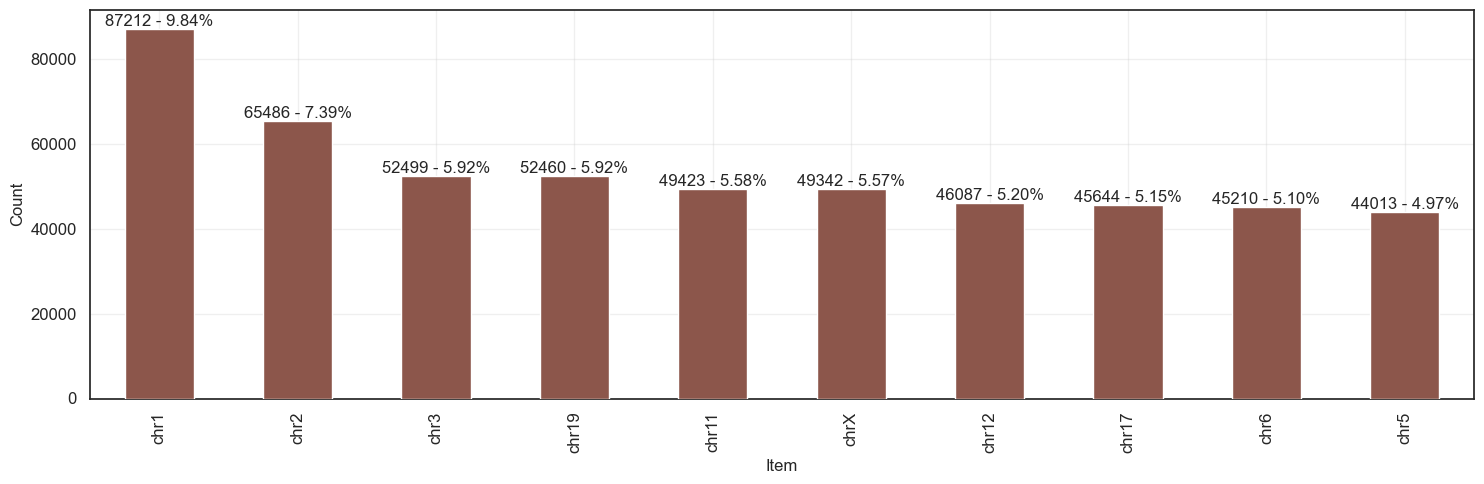

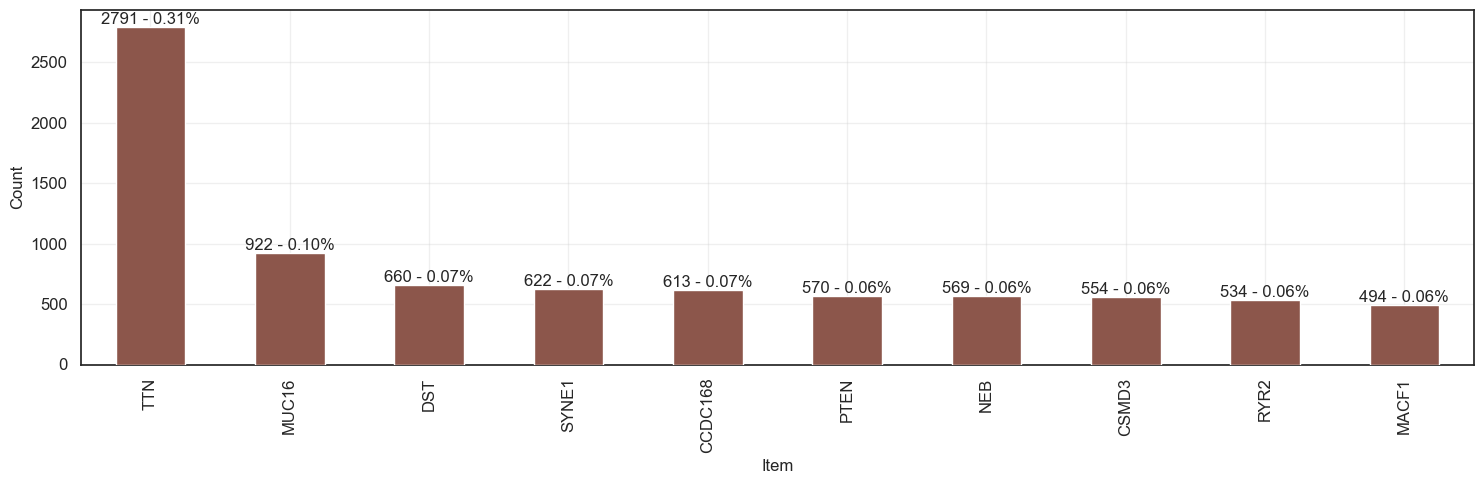

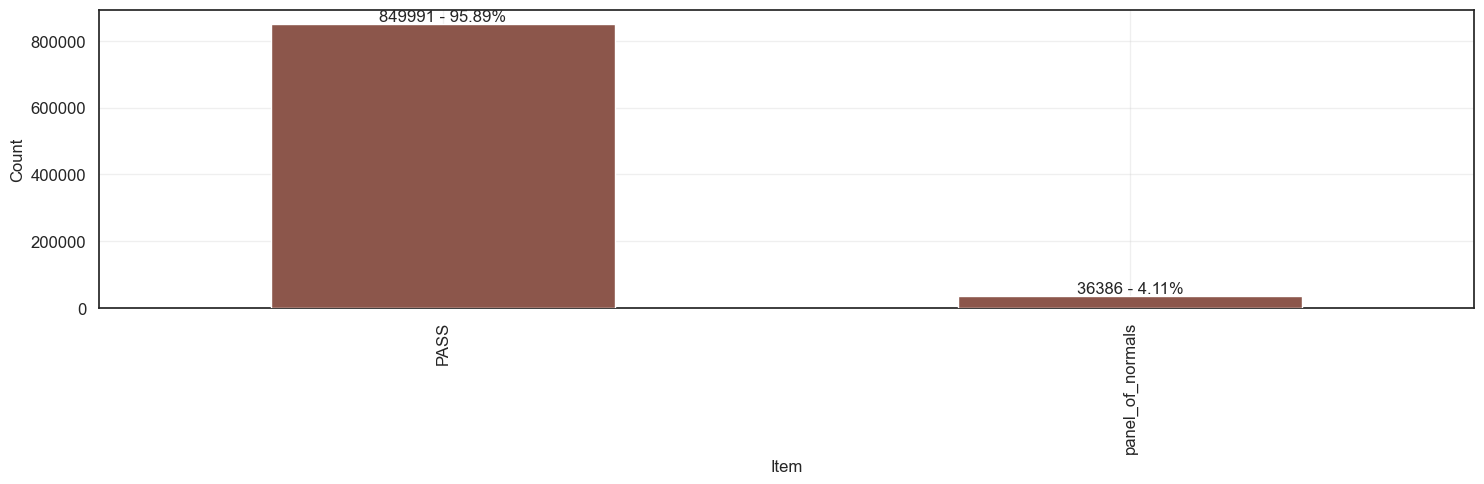

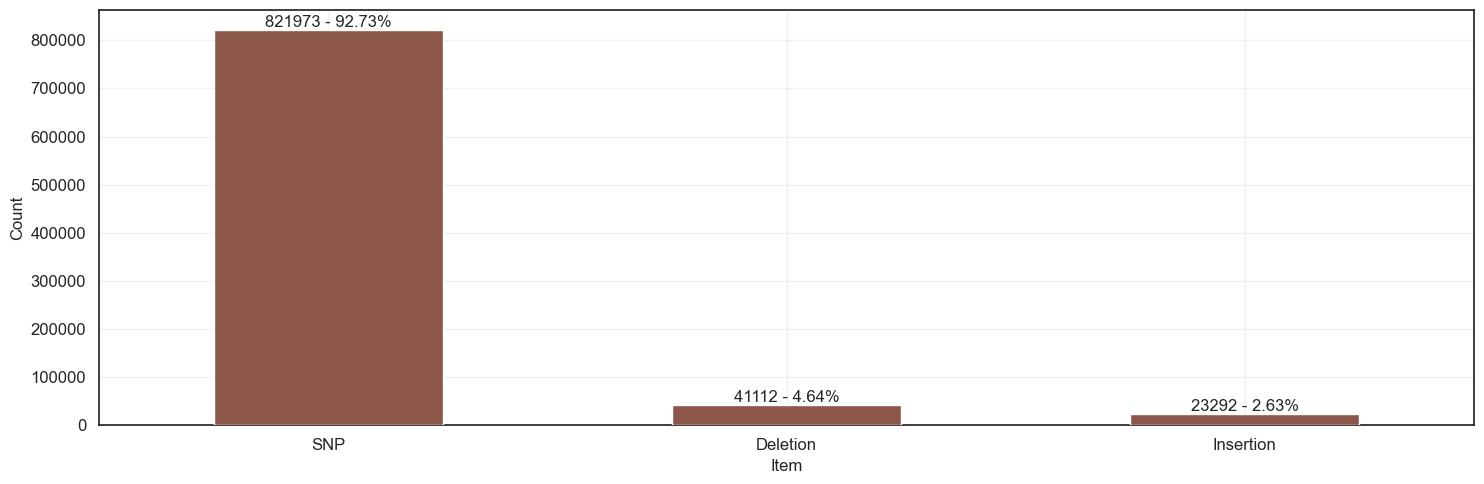

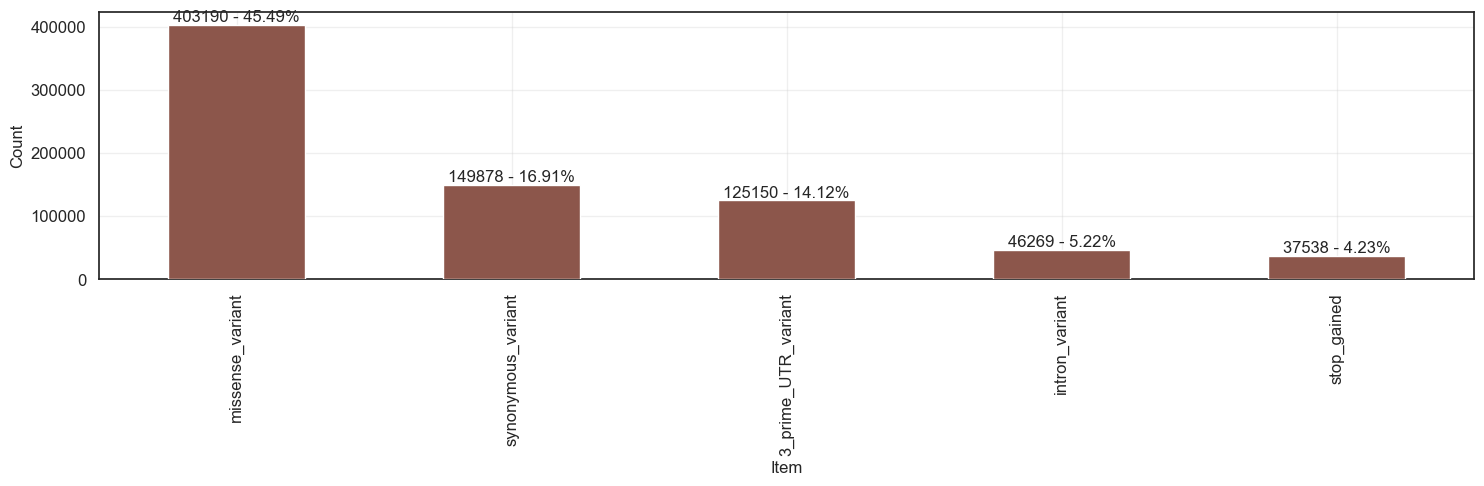

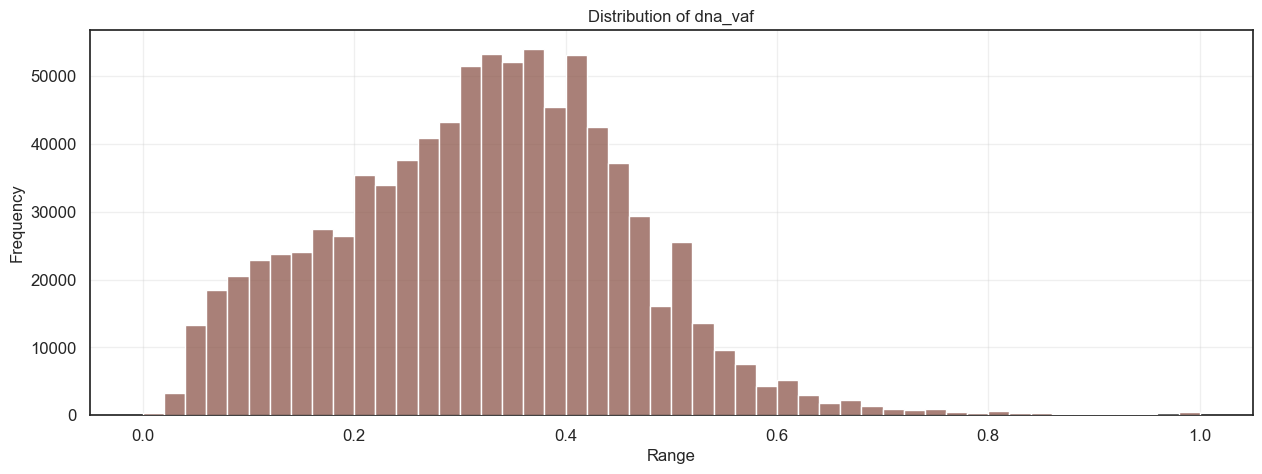

dna_vaf
count  886377.000000
mean        0.320896
std         0.138280
min         0.000000
25%         0.222727
50%         0.327731
75%         0.413043
max         1.000000

In [124]:
visualize_categorical_frequent(df_ucec, "chrom", 10)
visualize_categorical_frequent(df_ucec, "gene", 10)
visualize_categorical_frequent(df_ucec, "filter", 5)
visualize_categorical_frequent(df_ucec, "type", 3)
visualize_categorical_frequent(df_ucec, "effect", 5)
visualize_numerical_frequent(df_ucec, "dna_vaf", 50)
df_ucec[["dna_vaf"]].describe()

- **UCEC stands for Uterine Corpus Endometrial Carcinoma cancer which is a common type of uterine cancer that originates from the endometrium. The distribution of the chrom makes sense especially for chrX.**

#### BRCA

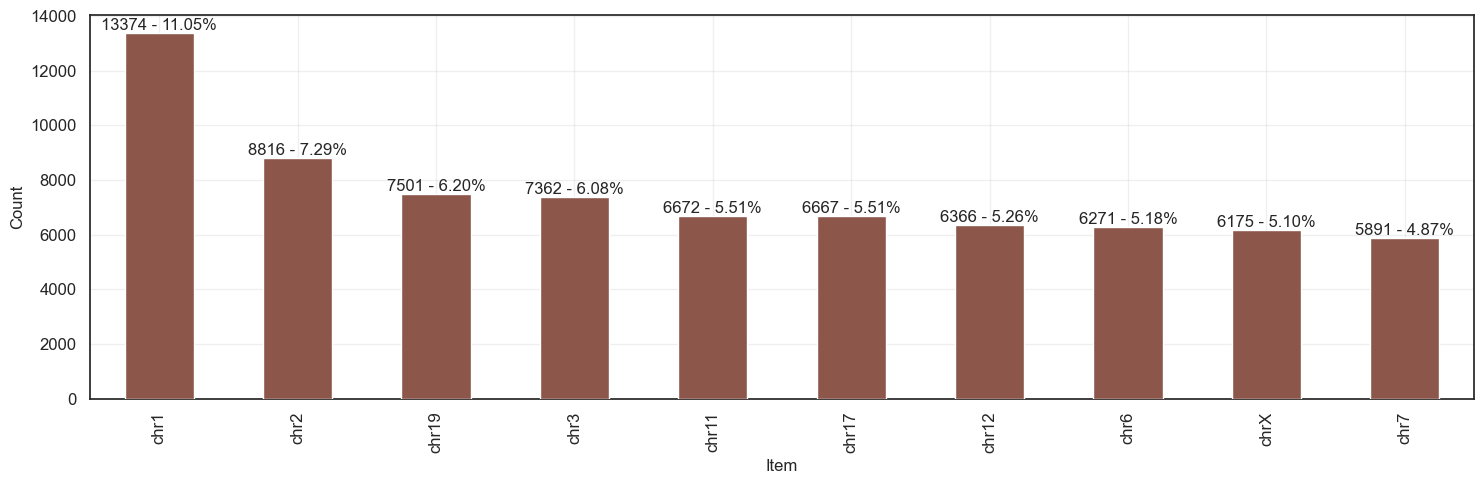

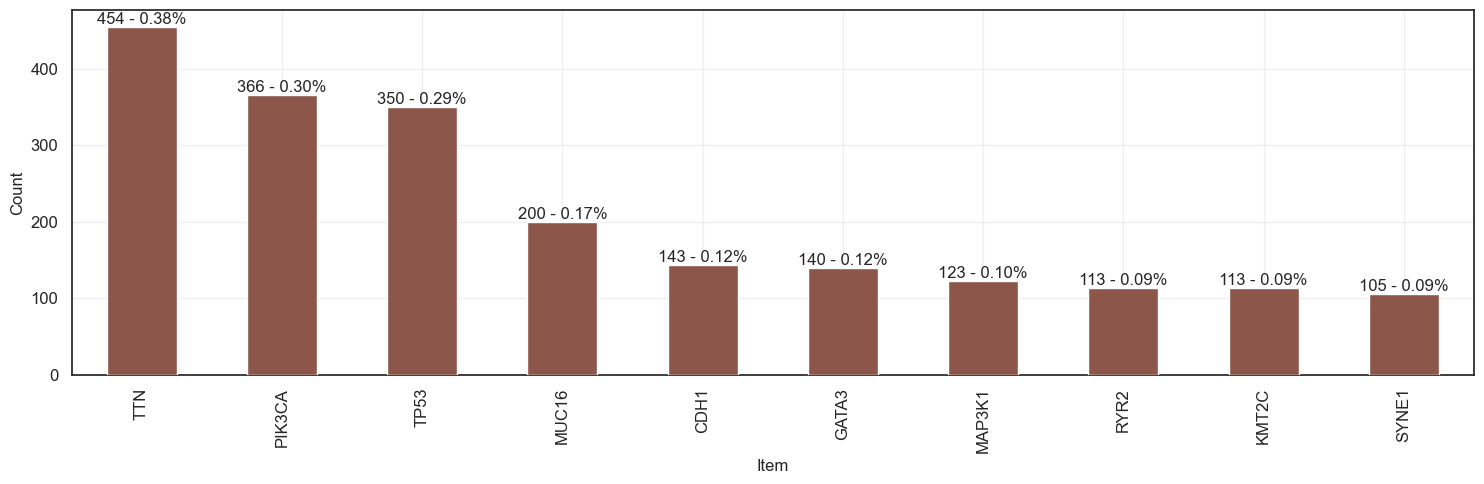

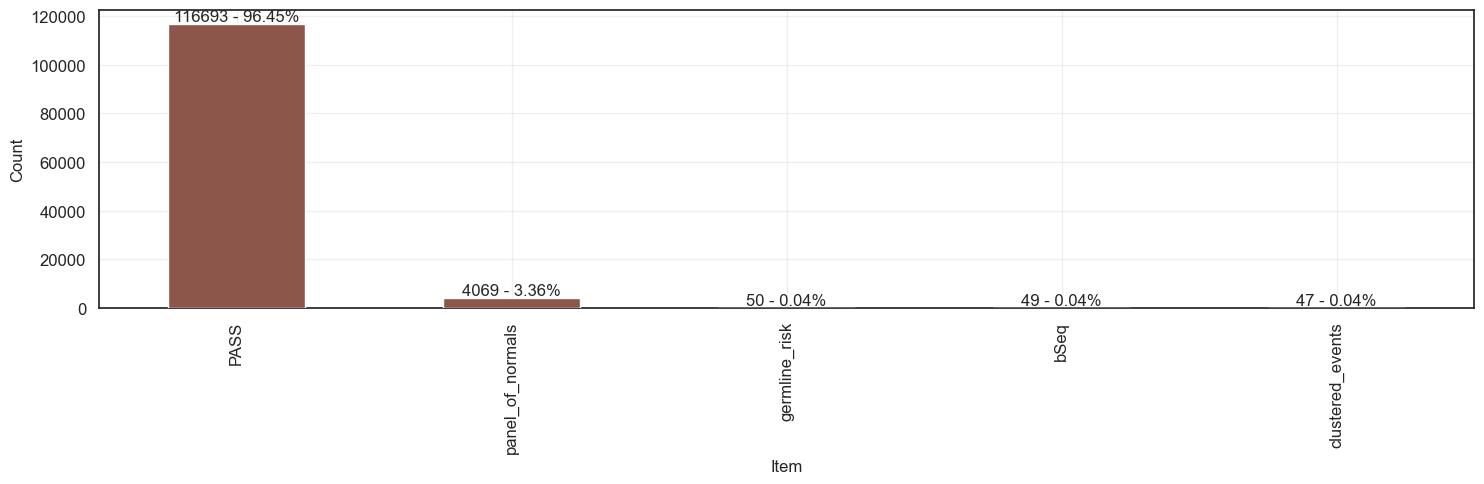

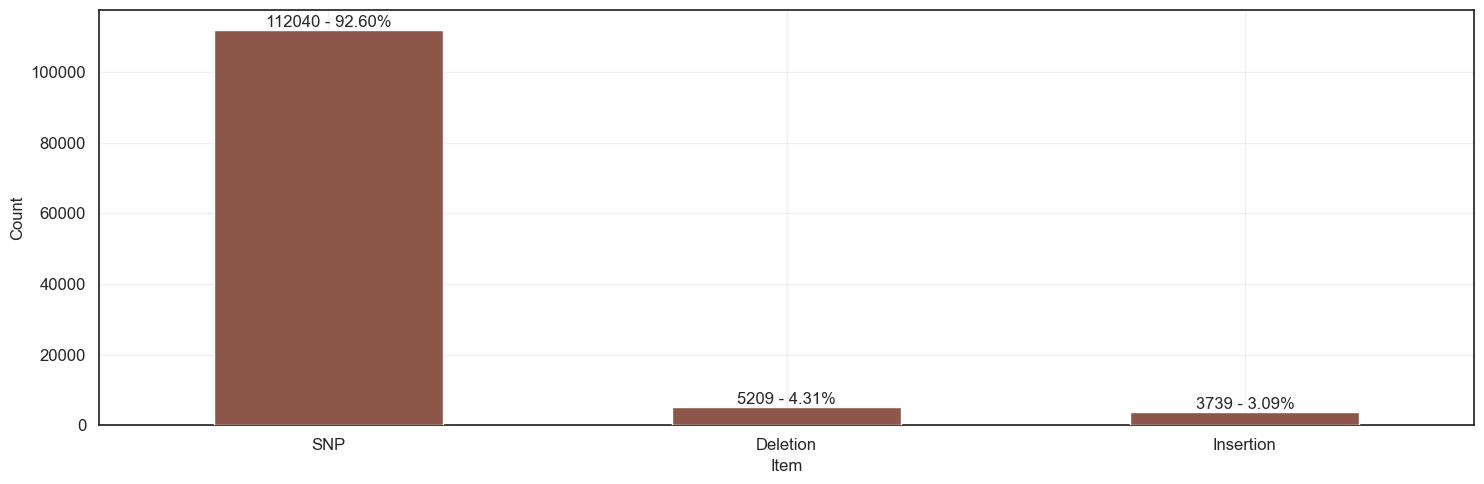

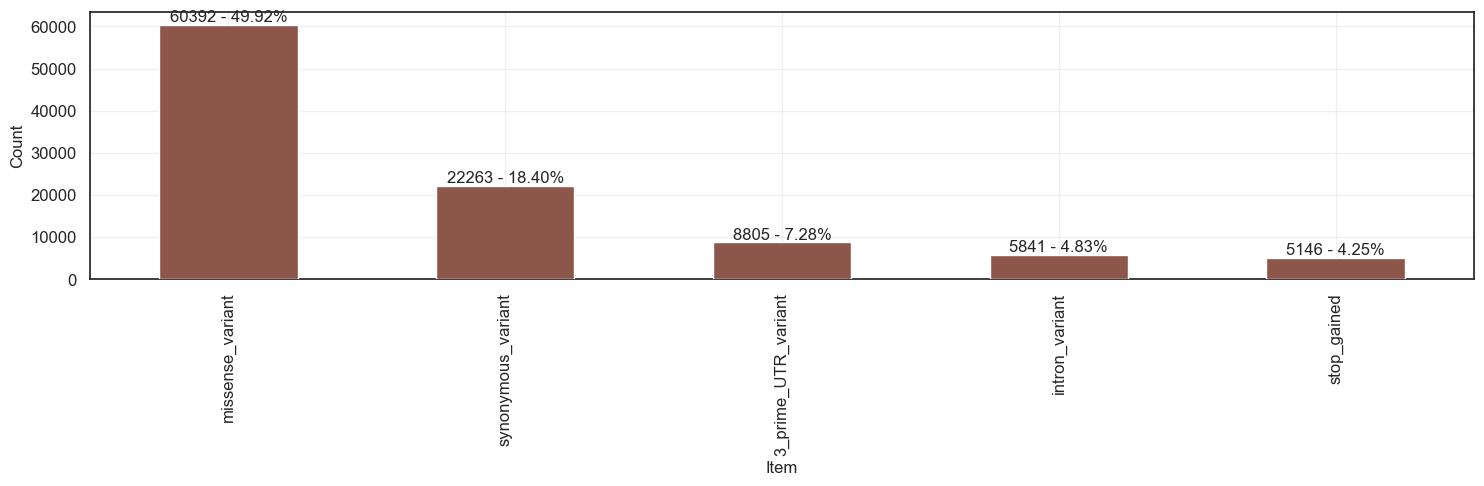

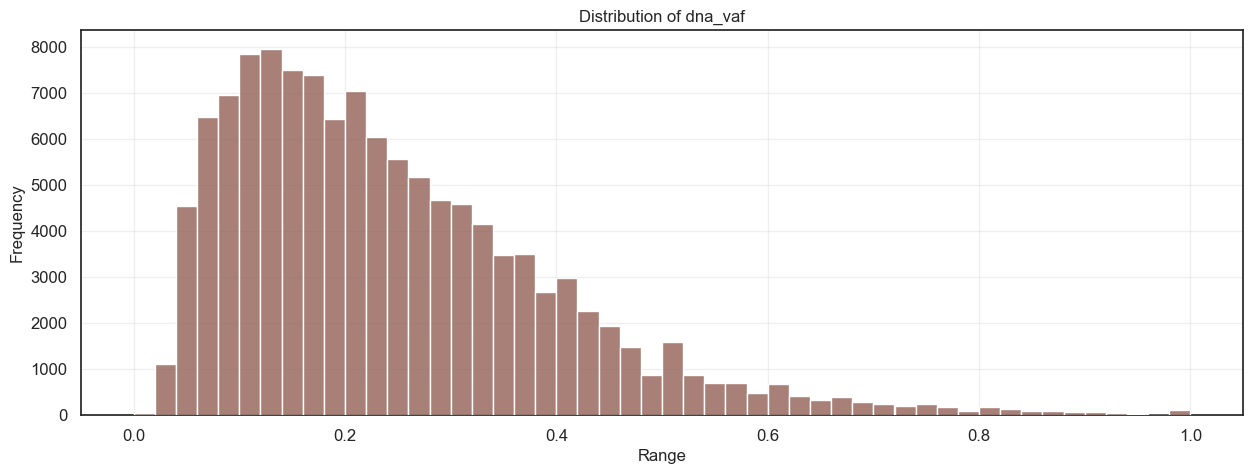

dna_vaf
count  120988.000000
mean        0.243561
std         0.152979
min         0.000000
25%         0.128205
50%         0.210526
75%         0.326667
max         1.000000

In [125]:
df_brca = df_mut[df_mut["cancer"] == "BRCA"]
df_brca.head()
visualize_categorical_frequent(df_brca, "chrom", 10)
visualize_categorical_frequent(df_brca, "gene", 10)
visualize_categorical_frequent(df_brca, "filter", 5)
visualize_categorical_frequent(df_brca, "type", 3)
visualize_categorical_frequent(df_brca, "effect", 5)
visualize_numerical_frequent(df_brca, "dna_vaf", 50)
df_brca[["dna_vaf"]].describe()

#### LUAD

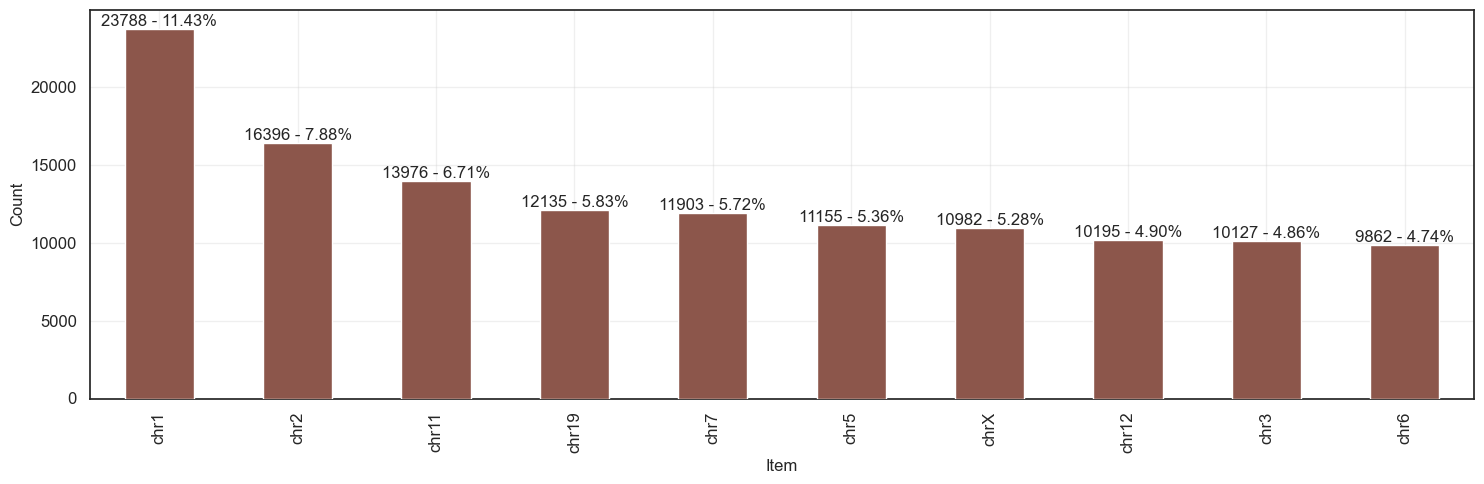

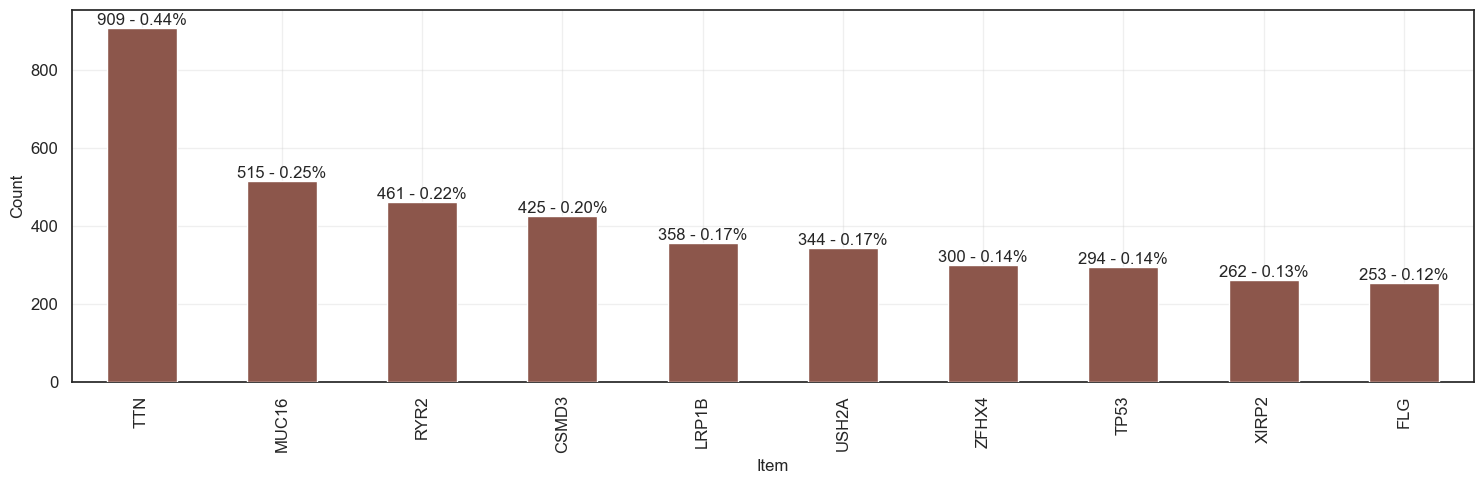

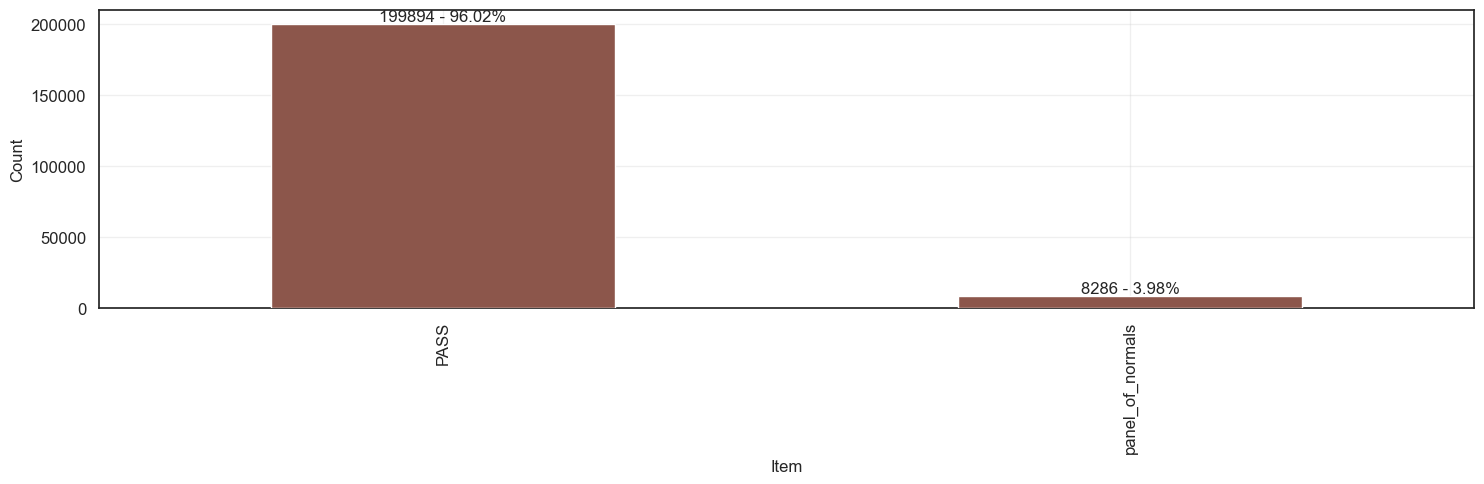

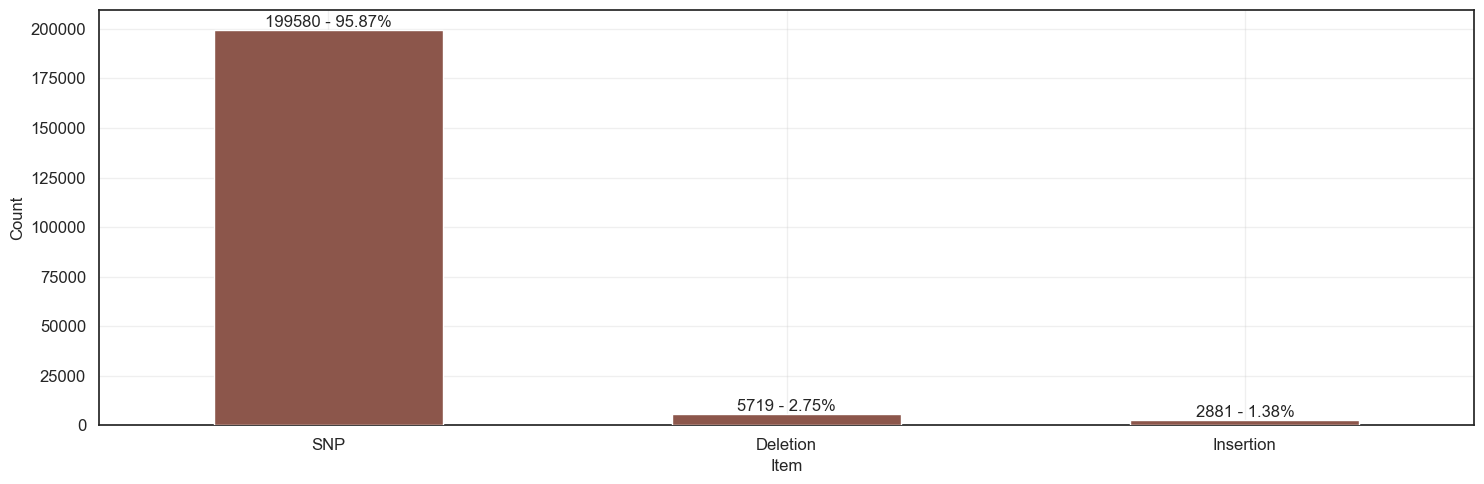

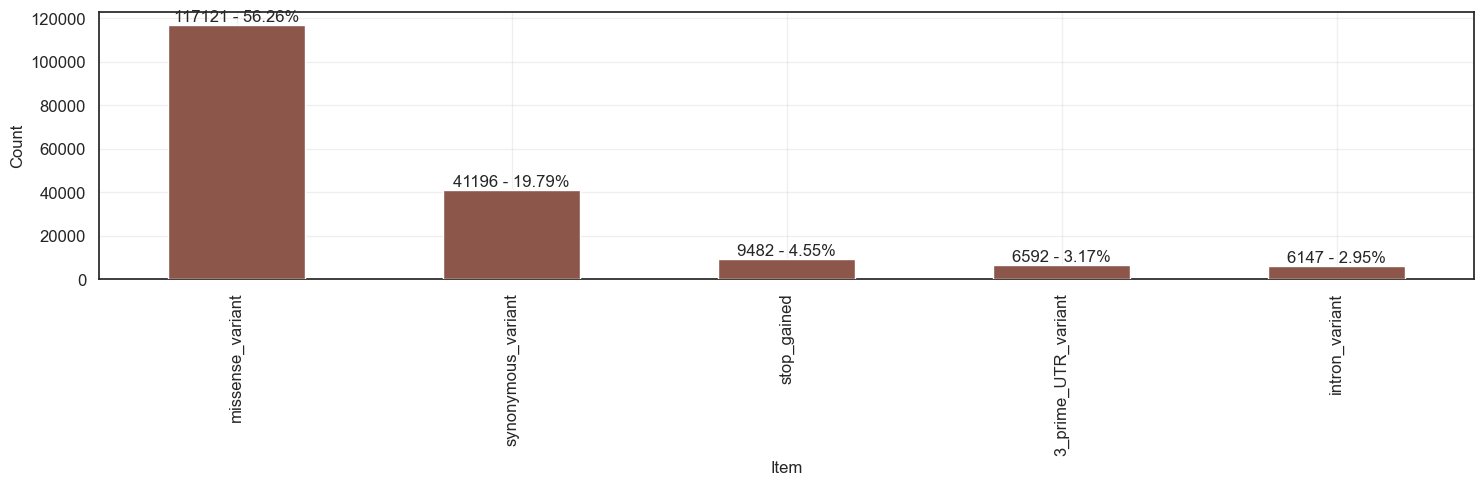

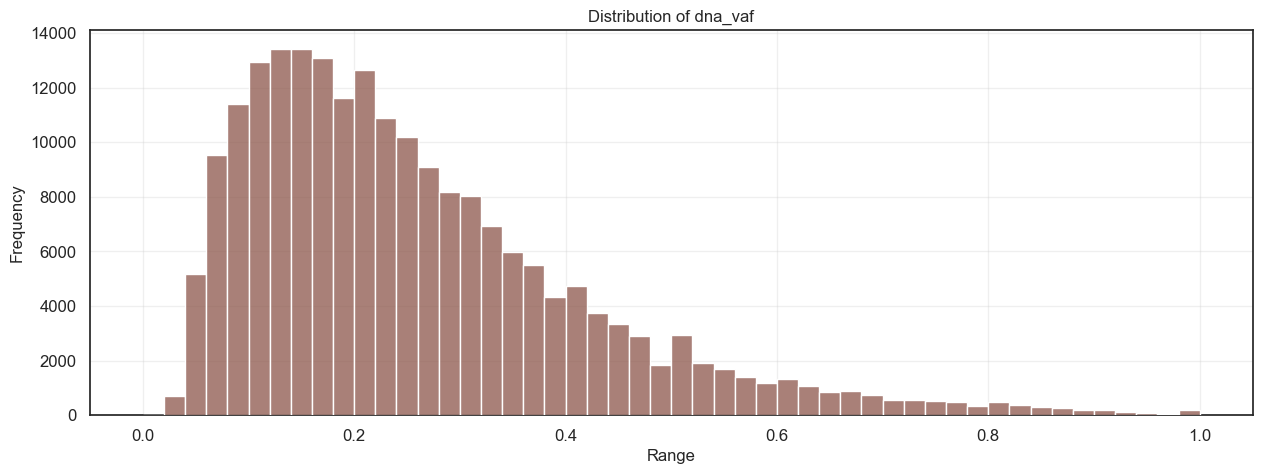

dna_vaf
count  208180.000000
mean        0.258221
std         0.162502
min         0.000000
25%         0.138004
50%         0.220339
75%         0.335766
max         1.000000

In [126]:
df_luad = df_mut[df_mut["cancer"] == "LUAD"]
df_luad.head()
visualize_categorical_frequent(df_luad, "chrom", 10)
visualize_categorical_frequent(df_luad, "gene", 10)
visualize_categorical_frequent(df_luad, "filter", 5)
visualize_categorical_frequent(df_luad, "type", 3)
visualize_categorical_frequent(df_luad, "effect", 5)
visualize_numerical_frequent(df_luad, "dna_vaf", 50)
df_luad[["dna_vaf"]].describe()

#### OV

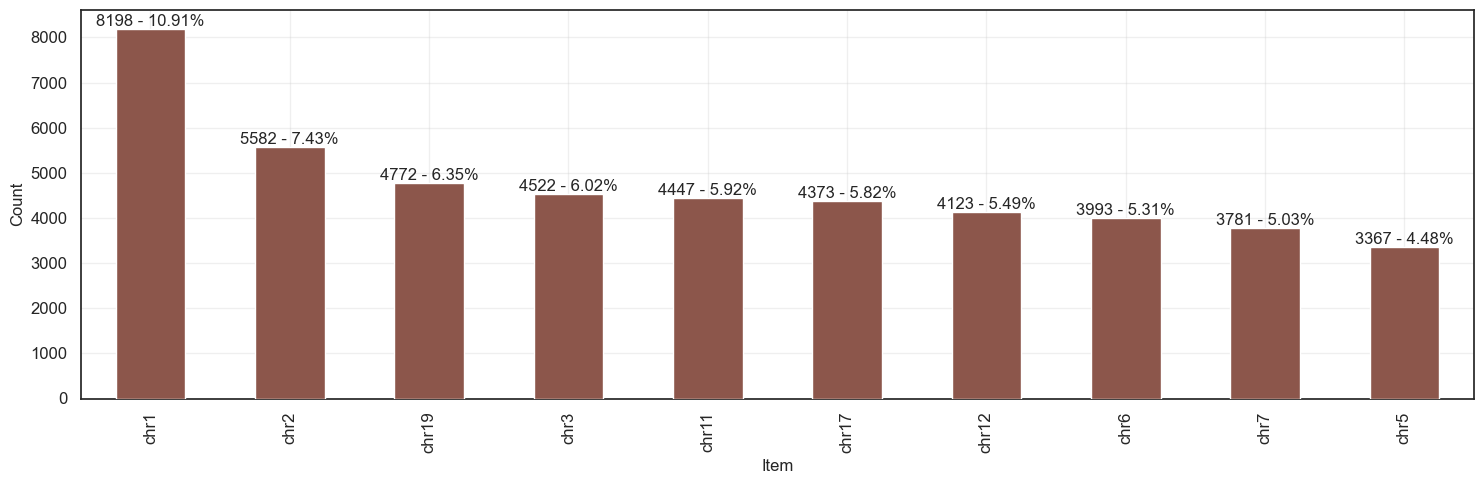

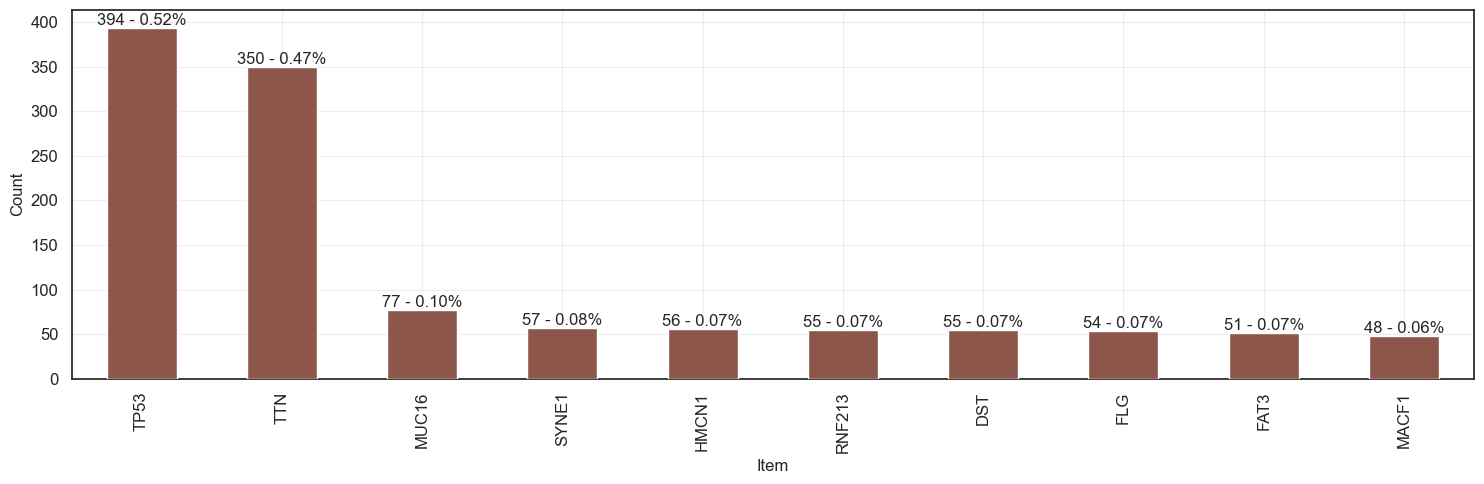

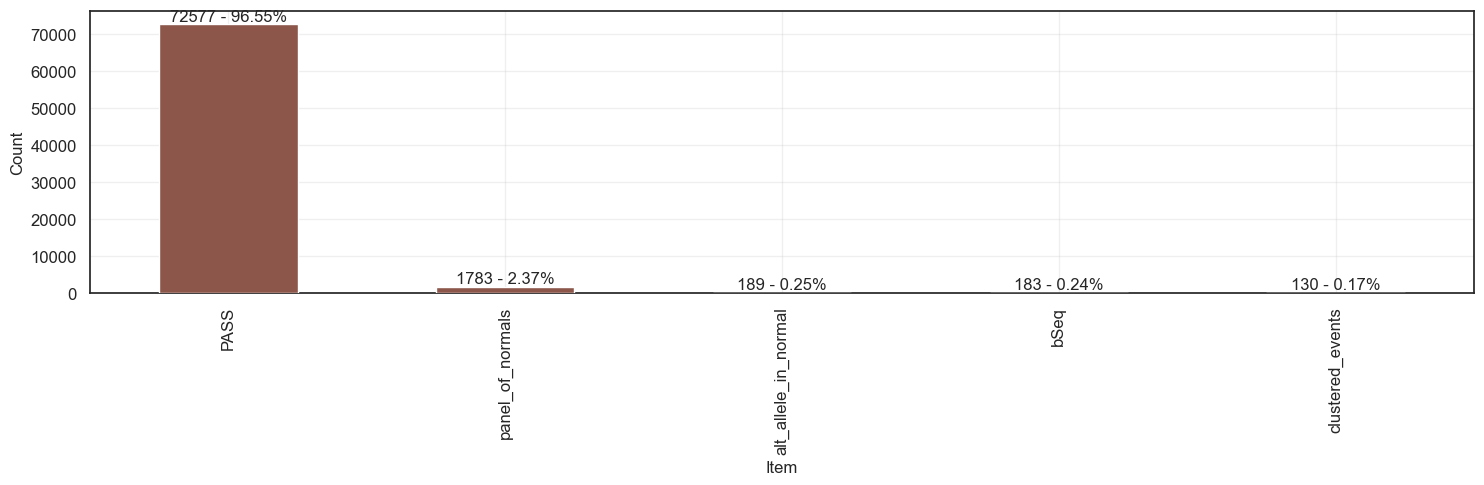

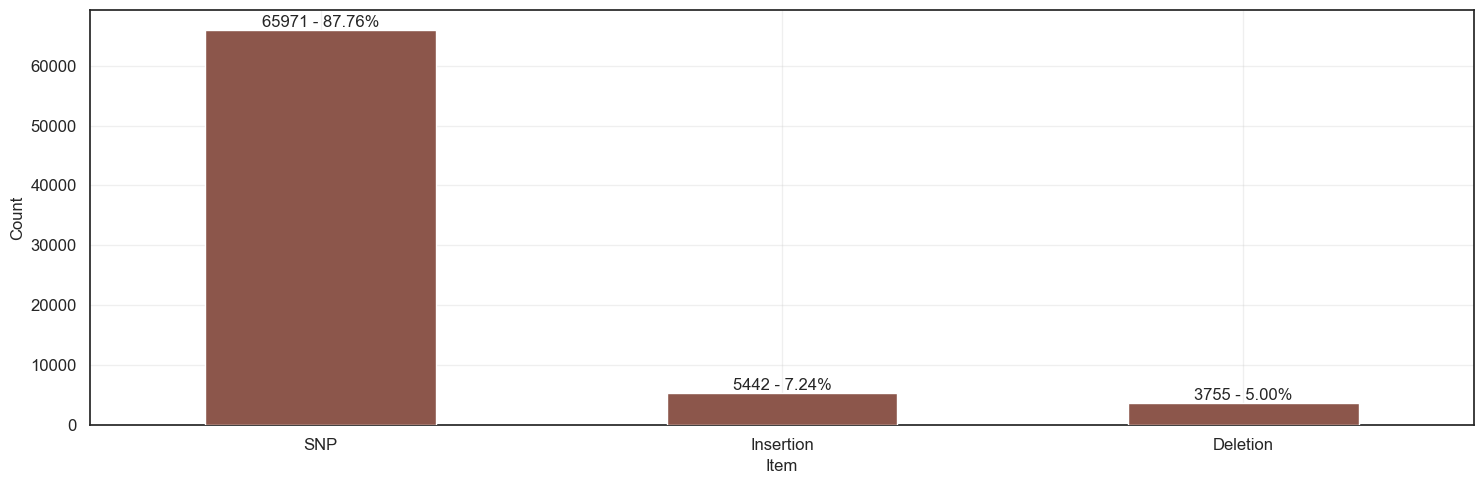

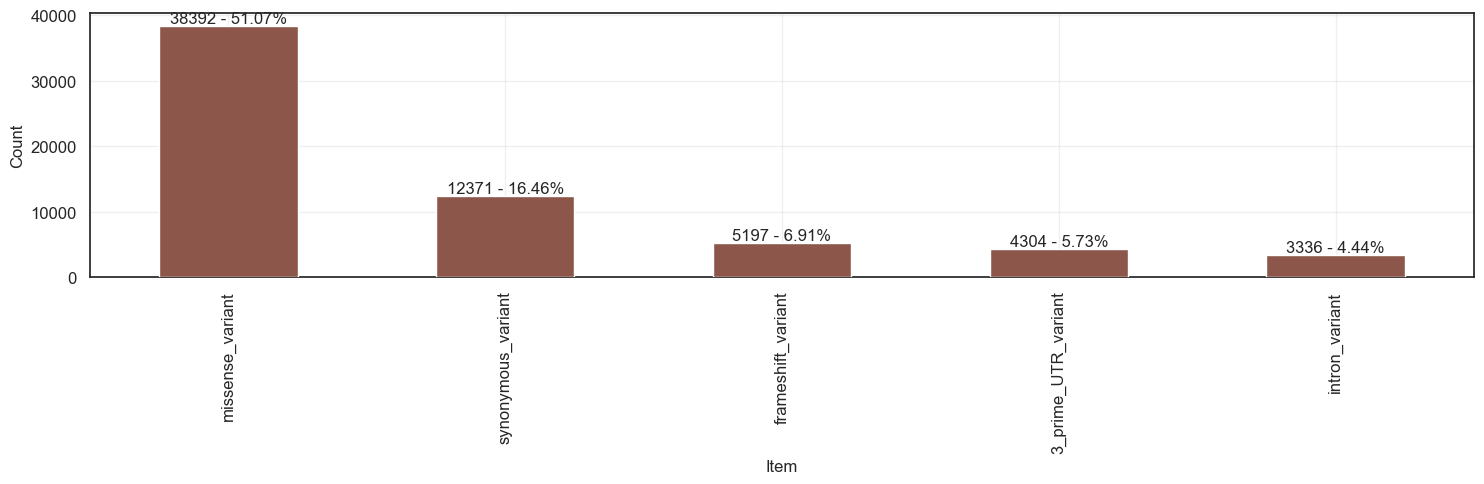

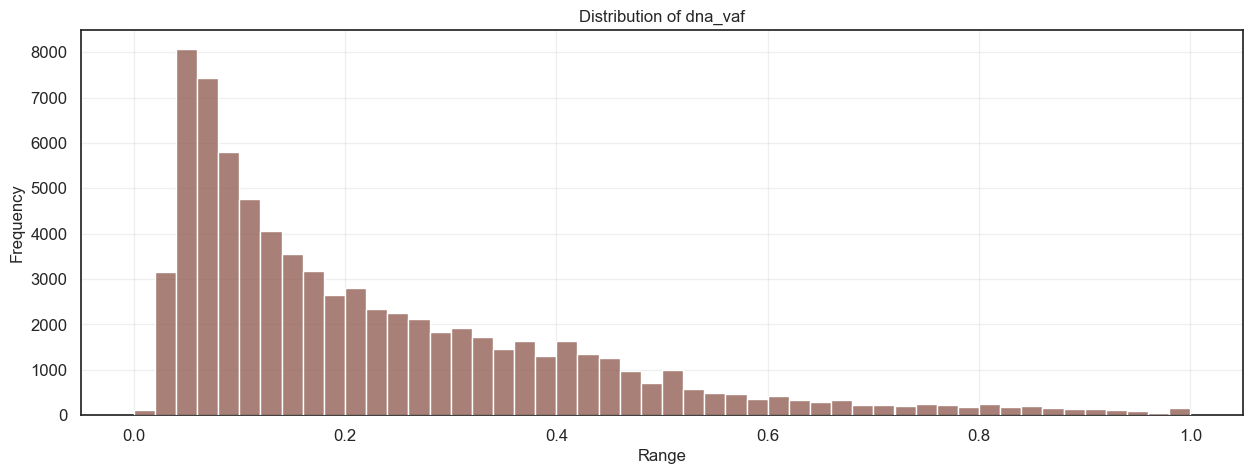

dna_vaf
count  75168.000000
mean       0.227174
std        0.190848
min        0.000000
25%        0.080000
50%        0.163636
75%        0.323869
max        1.000000

In [127]:
df_ov = df_mut[df_mut["cancer"] == "OV"]
df_ov.head()
visualize_categorical_frequent(df_ov, "chrom", 10)
visualize_categorical_frequent(df_ov, "gene", 10)
visualize_categorical_frequent(df_ov, "filter", 5)
visualize_categorical_frequent(df_ov, "type", 3)
visualize_categorical_frequent(df_ov, "effect", 5)
visualize_numerical_frequent(df_ov, "dna_vaf", 50)
df_ov[["dna_vaf"]].describe()

# Data Analysis Part II

In [128]:
# Take a filterd dataset

df_filtered = df_mut[(df_mut["dna_vaf"] > 0.1) & (df_mut["filter"] == "PASS")].drop(columns=["filter"])
df_filtered.shape

(2723926, 12)

- **I think if mutations are mutated in different genomic positions, despite the convergence of their effect, they cannot be removed or treated as true duplicates because even one-base shifts, which is the case here, can represent biologically different mutations.**

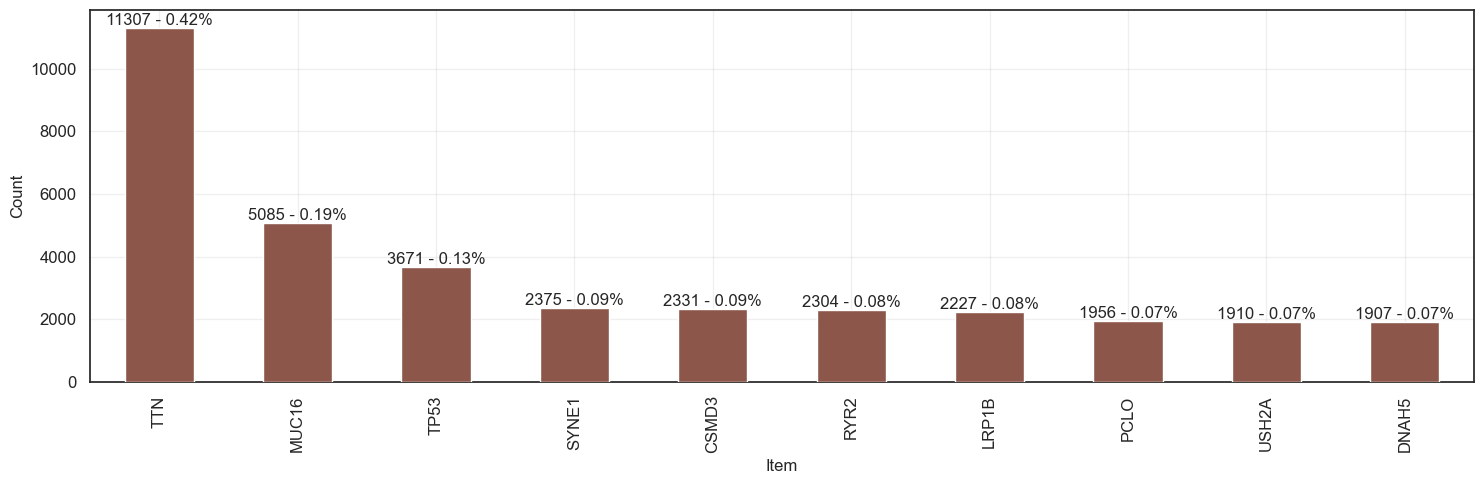

In [129]:
visualize_categorical_frequent(df = df_filtered, feature = "gene")

In [130]:
columns_fil = columns.copy()
columns.remove("filter")
columns.append("cancer")

In [131]:
print(columns_fil)

['gene', 'chrom', 'start', 'end', 'ref', 'alt', 'Amino_Acid_Change', 'effect', 'filter']


In [132]:
df_columns = df_filtered[df_filtered.duplicated(subset=columns)].sort_values(by=[*columns, "dna_vaf"])
df_columns.shape

(107416, 12)

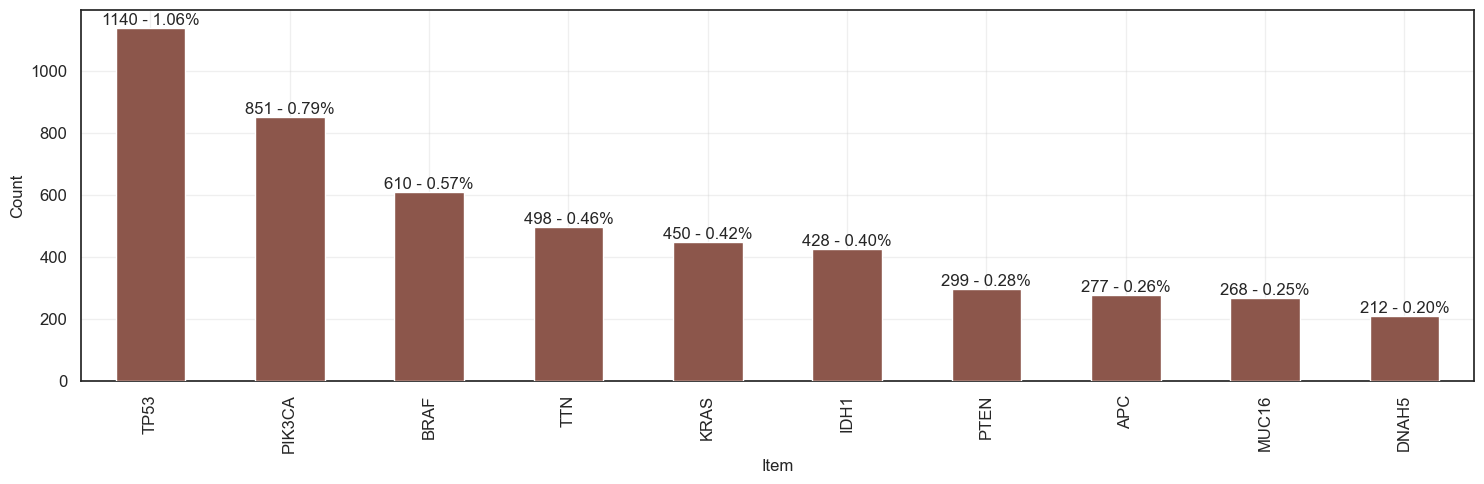

In [133]:
visualize_categorical_frequent(df = df_columns, feature = "gene")

- **Following the removal of the same mutations within different individuals and differnet *dna_vaf* some genes decreased in count. For instance, TP53 used to be one of the dominant genes until it dropped from 3671 to 1126. This indicates that TP53 was only mutated more often in different samples not necessarily because it had a higher diversity of mutation or broader mutational spectrum. This seemingly decreases bias and offers plausible results. However, this might unintentionally understimate the prelevance of TP53 since it was filtered based on VAF. As a result, the duplicates should be handeled differently. Only one mutation per sample was kept. It should change to one mutation per sample per gene.**

In [134]:
""" 
    This block of code removes the duplicates based on some features (gene, chrom, start, end, ref, alt, Amino_Acid_Change, effect, filter)
    and restores any entry where a sample lost a gene forever.

    Steps:
        1- Get and remove all occurences from dataframe
        2- Remove the duplicate from those occurences
        3- Check the difference between the dataset that has all occurences and that without the duplicates. The difference are the rows
           with samples that lost genes forever.
        4- Merge the difference with the dataset without duplicates.
        5- Add the final result to the df_filtered.

"""
# 1- Remove all occurences from dataframe
# 2- Remove the duplicates
# 3- Bring back those entries per sample per gene.
# 4- Join them back to the original dataframe after removing the duplicates from the original dataframe.
df_duplicates = df_filtered[df_filtered.duplicated(subset=columns, keep=False)].sort_values(by=[*columns,"dna_vaf"])
df_filtered = df_filtered[~df_filtered.duplicated(subset=columns, keep=False)]
df_no_duplicates = df_duplicates.drop_duplicates(subset=columns, keep="last")
print(df_duplicates.shape)
print(df_no_duplicates.shape)
removed_duplicates =  pd.merge(
    df_duplicates, 
    df_no_duplicates, 
    how="left", 
    indicator=True, 
    on=df_duplicates.columns.tolist()
).query('_merge=="left_only"').drop(columns=["_merge"])

# Give me those rows with sample ids having some unique gene values
# check if that sample with that gene exists or not
rows_to_add = pd.merge(
    removed_duplicates,
    df_no_duplicates,
    on=["Sample_ID","gene"],
    how="left",
    indicator=True
).query('_merge=="left_only"').drop(columns=["_merge"])

rows_to_add.drop(columns=[col for col in rows_to_add.columns if col.endswith("_y") or col == "_merge"], inplace=True)
rows_to_add.columns = [col.replace("_x","") for col in rows_to_add.columns]

print(rows_to_add.shape)
rows_to_add.head()

(183793, 12)
(76377, 12)
(103519, 12)


Sample_ID  gene  chrom     start       end ref alt  \
0  TCGA-FI-A2D5-01A  A1BG  chr19  58351519  58351519   C   T   
1  TCGA-FI-A2D0-01A  A1BG  chr19  58351519  58351519   C   T   
2  TCGA-D5-6531-01A  A1BG  chr19  58352325  58352325   C   T   
3  TCGA-DF-A2KV-01A  A1CF  chr10  50811087  50811087   G   T   
4  TCGA-D3-A2J8-06A  A1CF  chr10  50816064  50816064   G   A   

  Amino_Acid_Change              effect   dna_vaf type cancer  
0           p.R261H    missense_variant  0.238095  SNP   UCEC  
1           p.R261H    missense_variant  0.431818  SNP   UCEC  
2           p.A191T    missense_variant  0.331633  SNP   COAD  
3           p.F479L    missense_variant  0.312500  SNP   UCEC  
4           p.F361F  synonymous_variant  0.240964  SNP   SKCM

In [135]:
pd.merge(rows_to_add, df_no_duplicates, on=rows_to_add.columns.tolist(), how="inner")

Empty DataFrame
Columns: [Sample_ID, gene, chrom, start, end, ref, alt, Amino_Acid_Change, effect, dna_vaf, type, cancer]
Index: []

In [136]:
df_lookup = rows_to_add[rows_to_add.duplicated(subset=["Sample_ID","gene"], keep=False)].sort_values(by=["Sample_ID","gene"])
df_lookup

Sample_ID      gene  chrom      start        end ref alt  \
94616   TCGA-05-4405-01A      TP53  chr17    7673790    7673790   C   A   
95295   TCGA-05-4405-01A      TP53  chr17    7675088    7675088   C   T   
106266  TCGA-05-4427-01A    ZNF536  chr19   30548560   30548560   C   A   
106270  TCGA-05-4427-01A    ZNF536  chr19   30549327   30549327   G   T   
27820   TCGA-06-0749-01A      EGFR   chr7   55154128   55154128   G   A   
...                  ...       ...    ...        ...        ...  ..  ..   
6490    TCGA-Z2-AA3V-06A  ARHGEF11   chr1  156986126  156986126   G   A   
10796   TCGA-Z2-AA3V-06A       BSN   chr3   49652283   49652283   C   T   
10798   TCGA-Z2-AA3V-06A       BSN   chr3   49655559   49655559   C   T   
93032   TCGA-Z2-AA3V-06A  TMEM132B  chr12  125644115  125644115   G   A   
93041   TCGA-Z2-AA3V-06A  TMEM132B  chr12  125653877  125653877   G   A   

       Amino_Acid_Change              effect   dna_vaf type cancer  
94616            p.C277F    missense_variant  0.260000  SNP   LUAD  
95295            p.R175H    missense_variant  0.160494  SNP   LUAD  
106266           p.R981R  synonymous_variant  0.162393  SNP   LUAD  
106270          p.Q1236H    missense_variant  0.260000  SNP   LUAD  
27820            p.A289T    missense_variant  0.243750  SNP    GBM  
...                  ...                 ...       ...  ...    ...  
6490              p.S27F    missense_variant  0.176471  SNP   SKCM  
10796            p.L909L  synonymous_variant  0.173913  SNP   SKCM  
10798           p.I2001I  synonymous_variant  0.152174  SNP   SKCM  
93032            p.E488K    missense_variant  0.191860  SNP   SKCM  
93041            p.D802N    missense_variant  0.166667  SNP   SKCM  

[5761 rows x 12 columns]

- **The Sample_ID gene combination exists however with different effects (different Amino_Acid_Change, different dna_vaf, potentially different effect)**.
- **Those added rows are legitimate.**
- **From this duplicate dropping, only 3897 rows were removed.**

In [137]:
df_no_duplicates = pd.concat([df_no_duplicates,rows_to_add], ignore_index=True)
df_filtered = pd.concat([df_filtered, df_no_duplicates], ignore_index=True)

In [138]:
df_filtered.duplicated().sum()

np.int64(0)

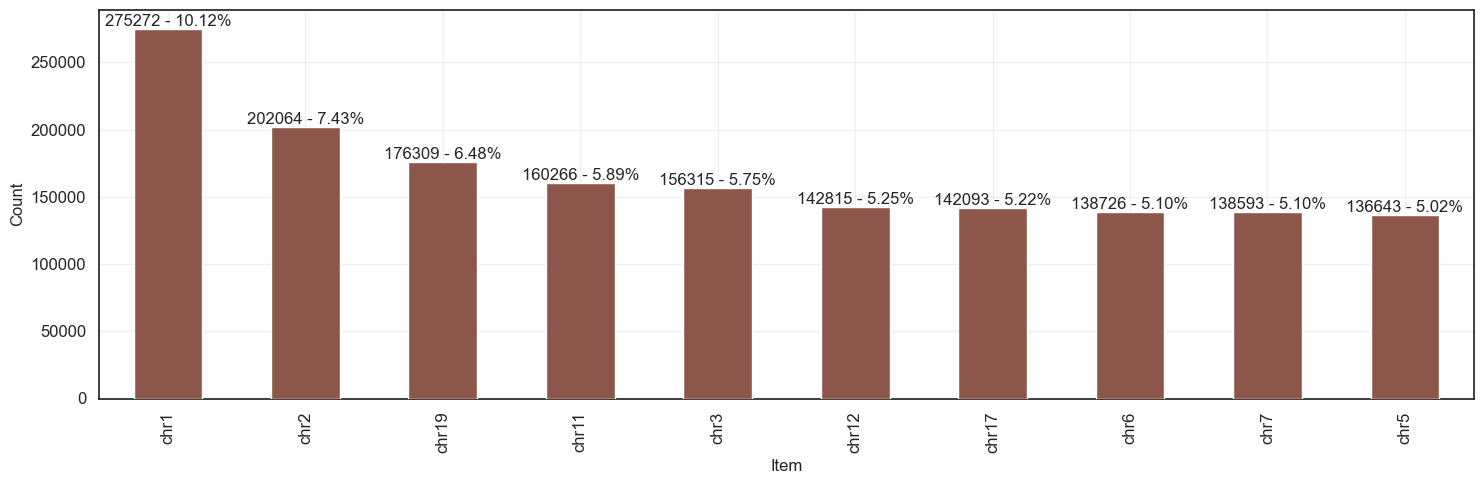

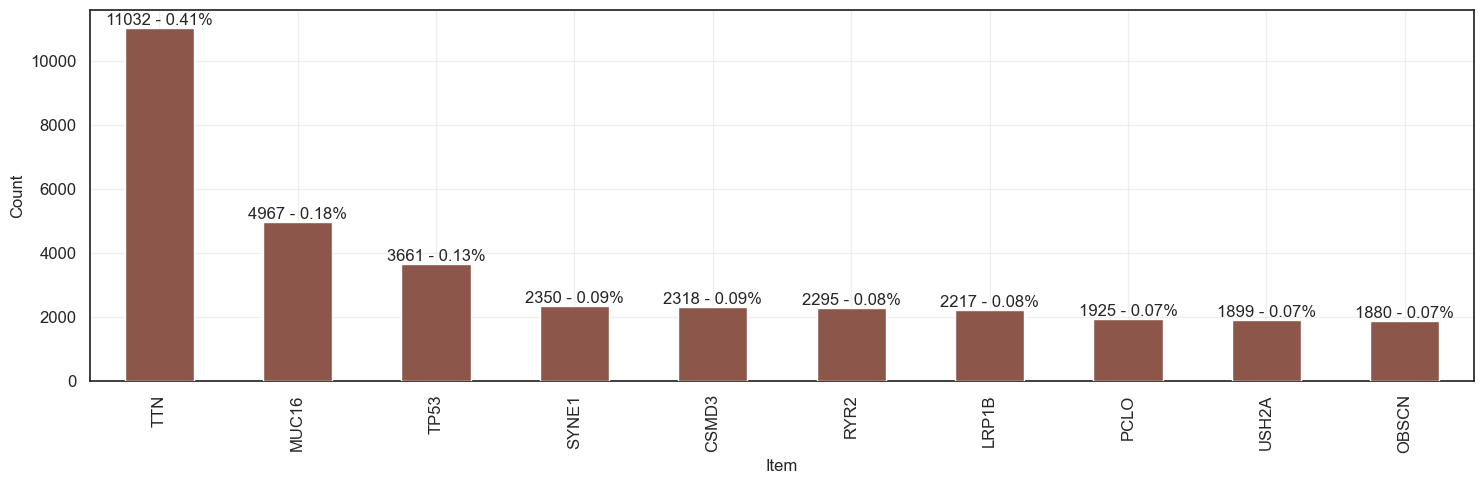

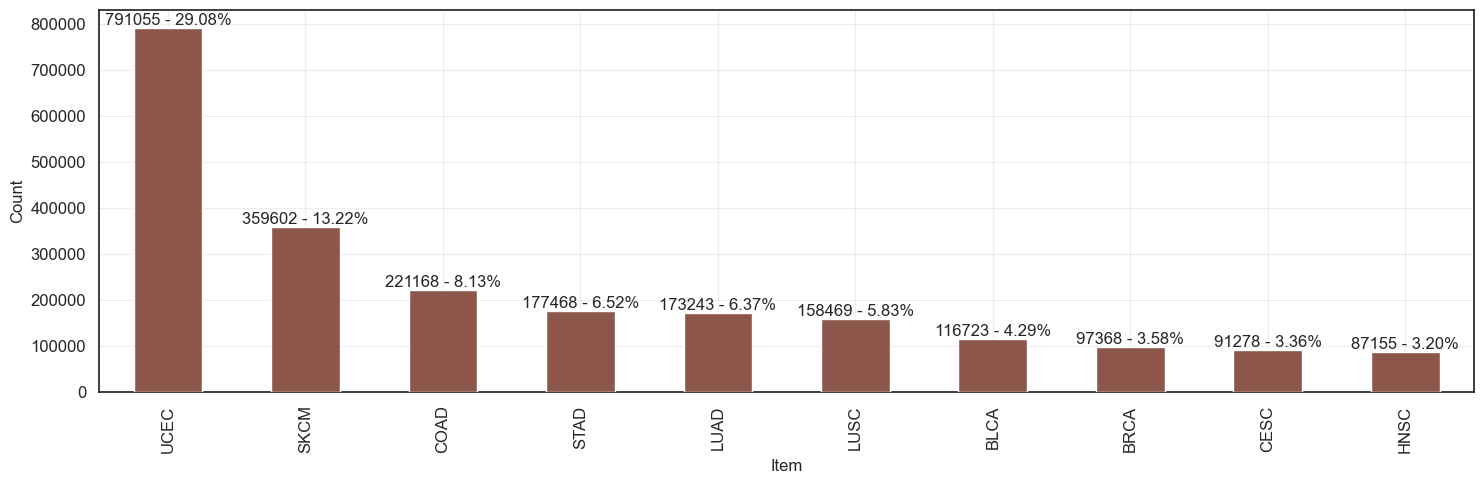

In [139]:
visualize_categorical_frequent(df_filtered, "chrom", 10)
visualize_categorical_frequent(df_filtered, "gene", 10)
visualize_categorical_frequent(df_filtered, "cancer", 10)

In [140]:
pivot = df_filtered.pivot_table(index="cancer",columns="gene", values="Sample_ID", aggfunc="count", fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_percentage.head()

gene        A1BG      A1CF       A2M     A2ML1  A2MP1   A3GALT2    A4GALT  \
cancer                                                                      
ACC     0.010715  0.010715  0.000000  0.021429    0.0  0.000000  0.010715   
BLCA    0.007711  0.004284  0.013708  0.011994    0.0  0.000000  0.002570   
BRCA    0.003081  0.008216  0.009243  0.013351    0.0  0.000000  0.002054   
CESC    0.002191  0.006573  0.009860  0.009860    0.0  0.001096  0.005478   
CHOL    0.041280  0.020640  0.000000  0.000000    0.0  0.000000  0.000000   

gene       A4GNT      AAAS      AACS  ...    ZYG11B       ZYX     ZZEF1  \
cancer                                ...                                 
ACC     0.000000  0.000000  0.032144  ...  0.010715  0.010715  0.053573   
BLCA    0.000857  0.003427  0.004284  ...  0.005997  0.000857  0.027415   
BRCA    0.002054  0.003081  0.007189  ...  0.003081  0.004108  0.014378   
CESC    0.006573  0.004382  0.005478  ...  0.009860  0.002191  0.017529   
CHOL    0.000000  0.000000  0.000000  ...  0.000000  0.041280  0.000000   

gene        ZZZ3  bP-21201H5.1  bP-2189O9.2  hsa-mir-1253  hsa-mir-6511b-1  \
cancer                                                                       
ACC     0.000000      0.000000     0.000000           0.0              0.0   
BLCA    0.010281      0.000000     0.000857           0.0              0.0   
BRCA    0.005135      0.001027     0.001027           0.0              0.0   
CESC    0.005478      0.000000     0.000000           0.0              0.0   
CHOL    0.020640      0.000000     0.000000           0.0              0.0   

gene          pk  snoU13  
cancer                    
ACC     0.010715     0.0  
BLCA    0.006854     0.0  
BRCA    0.006162     0.0  
CESC    0.010956     0.0  
CHOL    0.041280     0.0  

[5 rows x 21985 columns]

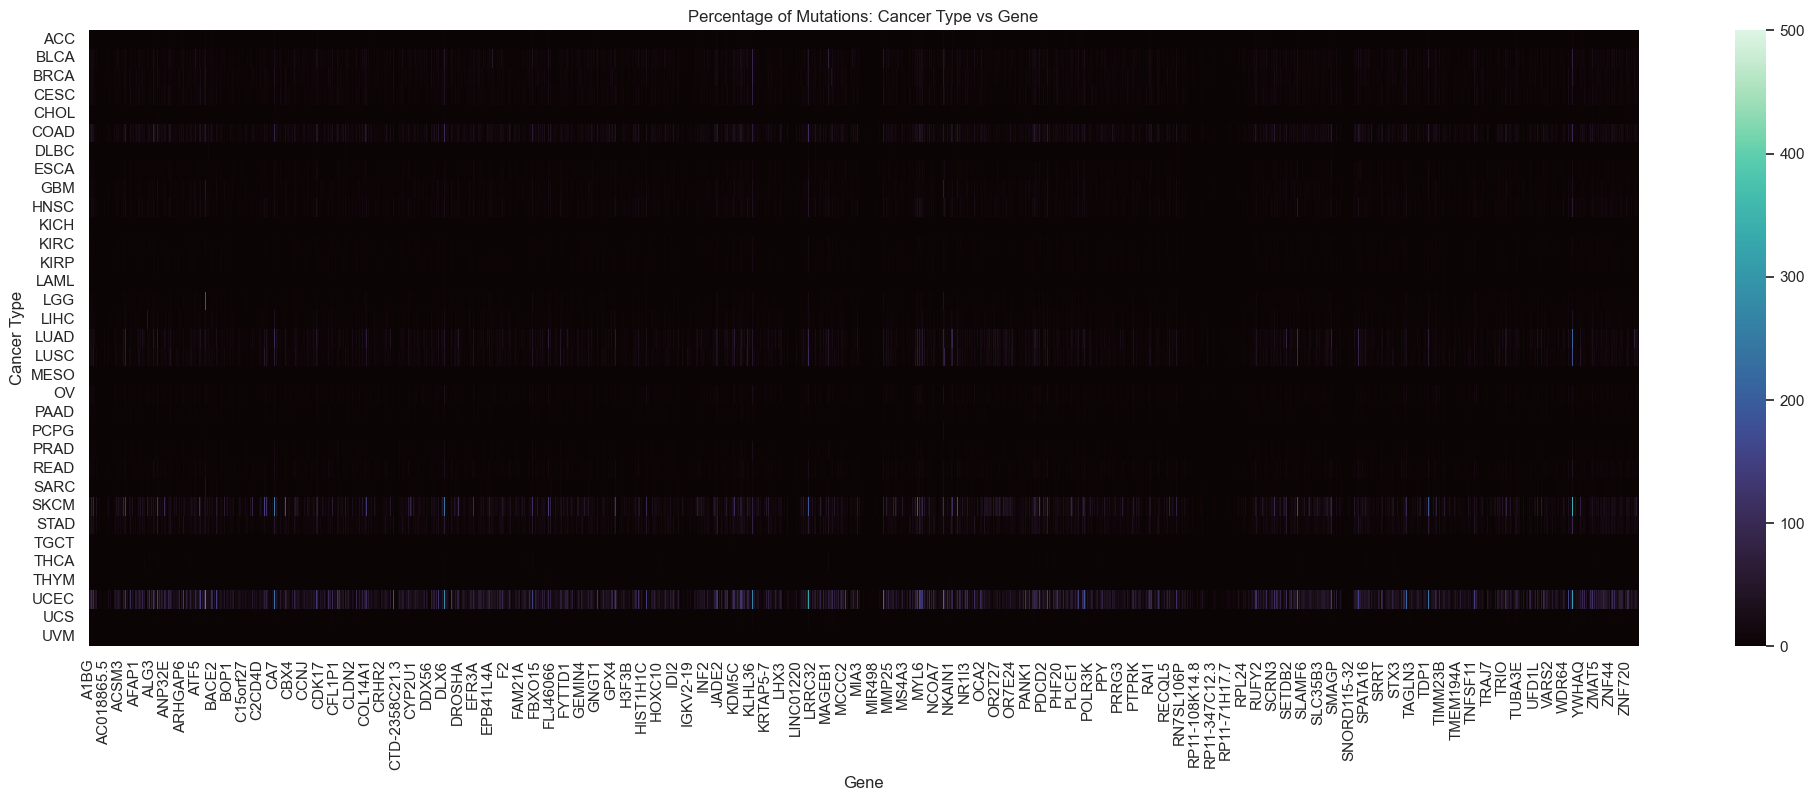

In [141]:
plt.figure(figsize=(25,8))
sns.heatmap(pivot, cmap="mako", vmax=500)
plt.title("Percentage of Mutations: Cancer Type vs Gene")
plt.xlabel("Gene")
plt.ylabel("Cancer Type")
plt.show()

- This heatmap shows how the most frequent cancer types are the most frequent ones which is in accordance with the bar plots. Nothing special
- There are a lot of dark spots indicating how sparse gene frequency is and so that these are rare events. Not much changed with the filtering.

## Similar Effect Mutation Gene Analysis

In [142]:
effect_columns = ["Amino_Acid_Change","effect","cancer"]
df_same_effect = df_filtered[df_filtered.duplicated(subset=effect_columns, keep=False)].sort_values(by=effect_columns)
print(df_same_effect.shape)
df_same_effect.head()

(1854121, 12)


Sample_ID      gene  chrom     start       end ref alt  \
556308   TCGA-EE-A2GC-06A     NCMAP   chr1  24605746  24605746   G   A   
844483   TCGA-GN-A26C-01A   DEFB116  chr20  31303213  31303213   C   T   
2568284  TCGA-H4-A2HQ-01A  HIST1H4D   chr6  26188766  26188766   C   T   
2654354  TCGA-GC-A3OO-01A  HIST1H4D   chr6  26188766  26188766   C   T   
322679   TCGA-W3-AA1V-06B    MRPL36   chr5   1798624   1798624   C   T   

        Amino_Acid_Change                 effect   dna_vaf type cancer  
556308            p.*103*  stop_retained_variant  0.193548  SNP   SKCM  
844483            p.*103*  stop_retained_variant  0.237500  SNP   SKCM  
2568284           p.*104*  stop_retained_variant  0.270000  SNP   BLCA  
2654354           p.*104*  stop_retained_variant  0.125000  SNP   BLCA  
322679            p.*104*  stop_retained_variant  0.156627  SNP   SKCM

- 1854121 records are composed of mutations (similar & different) having same effects.

### Protien Based

In [143]:
df_same_effect_p = df_same_effect.dropna(subset=["Amino_Acid_Change"])
print(df_same_effect_p.shape)

(1331906, 12)


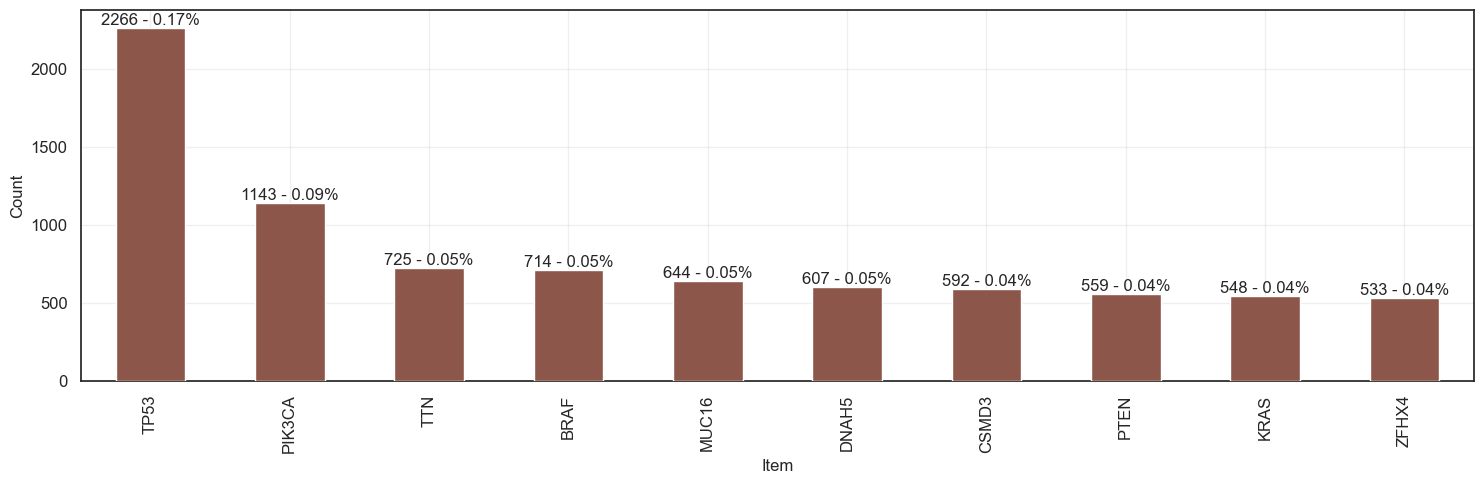

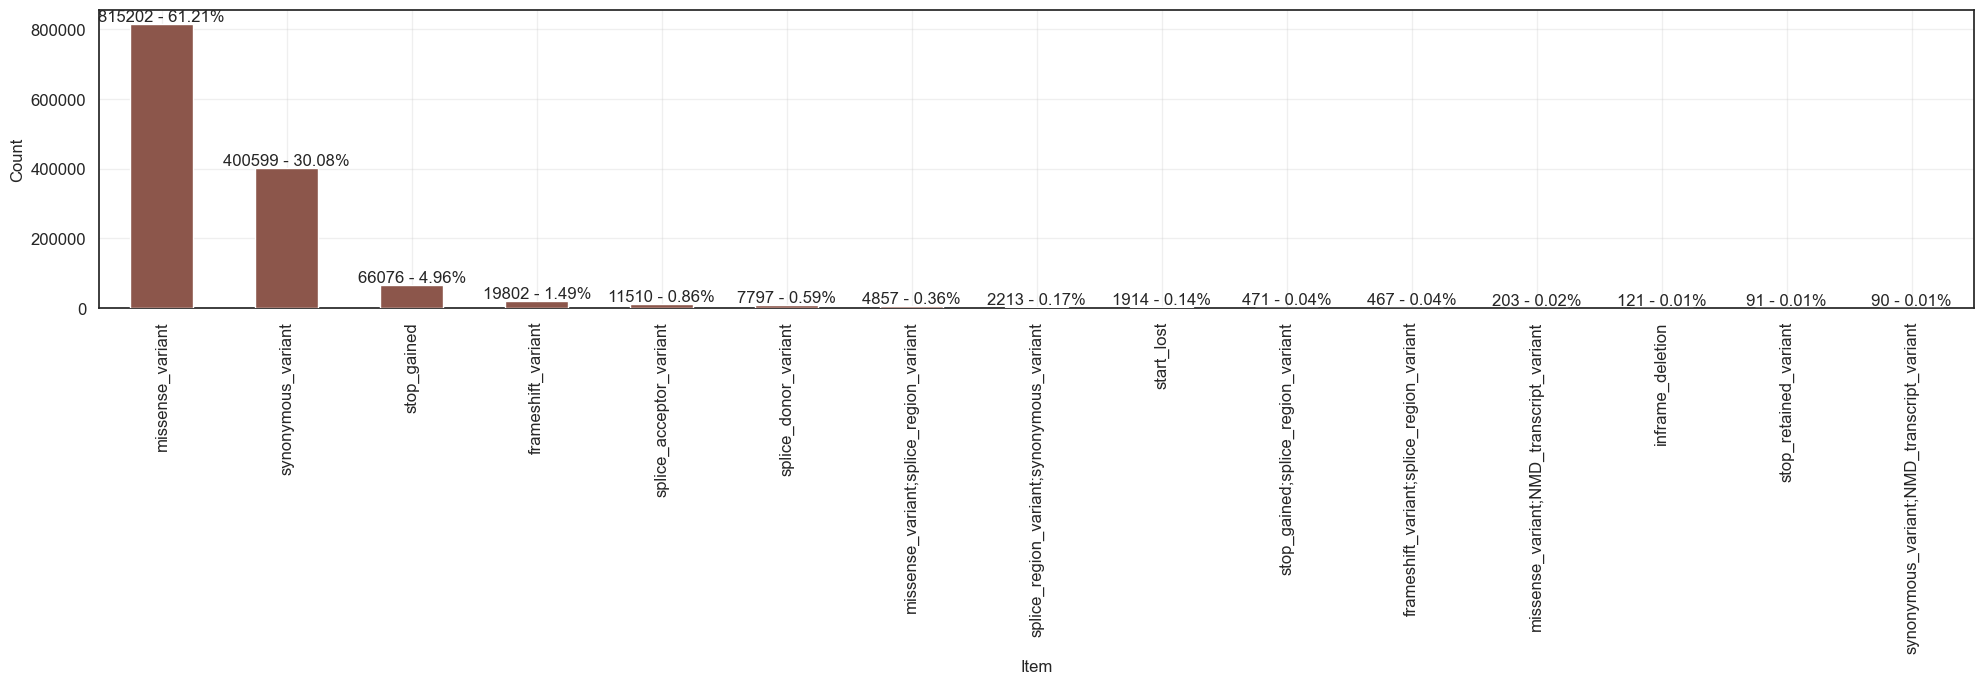

In [144]:
visualize_categorical_frequent(df = df_same_effect_p, feature="gene")
visualize_categorical_frequent(df = df_same_effect_p, feature="effect", size=(20,7), nbr=15)

- **The second graph exhibits effect frequency for protein based mutations sharing mutation effects. The first 5 effects extremely dominate the dataset. With very low entries for the rest of the effects. For the sake of clustering analysis, the very low frequent effect records will be grouped as *other*.**
- **The most frequent effect is missence_variant. This effect indicates that the mutation results in a different amino acid sequence but where the length is preserved.**
- **The second most frequent effect is synonymous_variant. There is no resulting change to the encoded Amino Acid. They are silent mutations. These do not cause any alteration in the protein product formed. Synonymous mutations can affect transcription, splicing, mRNA transport, and translation, all of which can bring about changes in the phenotype of the organism. As silent mutations do not affect the final protein product, these are considered evolutionarily neutral. So silent mutation might not contribute to Synthetic Lethality since they are neutral with no effect on the Amino Acid so no direct impact. However, due to their impact on mRNA they might lead to the loss of function in a gene.**
- **The thrid most frequent effect is stop_gained. CONTINUE THIS.**
- **Genes with similar phenotypic effects can be functionally related or part of SL pairs, but similarity in effects doesn't always mean functional connection.**

In [145]:
df_p_clustering = df_same_effect_p.copy()
rare_effects = df_p_clustering["effect"].value_counts()
threshold = 1000
df_p_clustering["effect"] = df_p_clustering["effect"].apply(lambda x : x if rare_effects[x] >= threshold else "other")
df_p_clustering.head()

Sample_ID      gene  chrom     start       end ref alt  \
556308   TCGA-EE-A2GC-06A     NCMAP   chr1  24605746  24605746   G   A   
844483   TCGA-GN-A26C-01A   DEFB116  chr20  31303213  31303213   C   T   
2568284  TCGA-H4-A2HQ-01A  HIST1H4D   chr6  26188766  26188766   C   T   
2654354  TCGA-GC-A3OO-01A  HIST1H4D   chr6  26188766  26188766   C   T   
322679   TCGA-W3-AA1V-06B    MRPL36   chr5   1798624   1798624   C   T   

        Amino_Acid_Change effect   dna_vaf type cancer  
556308            p.*103*  other  0.193548  SNP   SKCM  
844483            p.*103*  other  0.237500  SNP   SKCM  
2568284           p.*104*  other  0.270000  SNP   BLCA  
2654354           p.*104*  other  0.125000  SNP   BLCA  
322679            p.*104*  other  0.156627  SNP   SKCM

- The features to be taken for clustering: effect, dna_vaf, type.

In [146]:
clutering_columns = ["effect","type","dna_vaf"]
clustering = df_p_clustering[clutering_columns]
encoder = OneHotEncoder(sparse_output=False)
clutering_columns.pop()
one_hot_encoded = encoder.fit_transform(clustering[clutering_columns])
one_hot_df = pd.DataFrame(one_hot_encoded,columns=encoder.get_feature_names_out(clutering_columns))
one_hot_df

effect_frameshift_variant  effect_missense_variant  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   
...                            ...                      ...   
1331901                        0.0                      0.0   
1331902                        0.0                      0.0   
1331903                        0.0                      0.0   
1331904                        0.0                      0.0   
1331905                        0.0                      0.0   

         effect_missense_variant;splice_region_variant  effect_other  \
0                                                  0.0           1.0   
1                                                  0.0           1.0   
2                                                  0.0           1.0   
3                                                  0.0           1.0   
4                                                  0.0           1.0   
...                                                ...           ...   
1331901                                            0.0           0.0   
1331902                                            0.0           0.0   
1331903                                            0.0           0.0   
1331904                                            0.0           0.0   
1331905                                            0.0           0.0   

         effect_splice_acceptor_variant  effect_splice_donor_variant  \
0                                   0.0                          0.0   
1                                   0.0                          0.0   
2                                   0.0                          0.0   
3                                   0.0                          0.0   
4                                   0.0                          0.0   
...                                 ...                          ...   
1331901                             0.0                          0.0   
1331902                             0.0                          0.0   
1331903                             0.0                          0.0   
1331904                             0.0                          0.0   
1331905                             0.0                          0.0   

         effect_splice_region_variant;synonymous_variant  effect_start_lost  \
0                                                    0.0                0.0   
1                                                    0.0                0.0   
2                                                    0.0                0.0   
3                                                    0.0                0.0   
4                                                    0.0                0.0   
...                                                  ...                ...   
1331901                                              0.0                0.0   
1331902                                              0.0                0.0   
1331903                                              0.0                0.0   
1331904                                              0.0                0.0   
1331905                                              0.0                0.0   

         effect_stop_gained  effect_synonymous_variant  type_Deletion  \
0                       0.0                        0.0            0.0   
1                       0.0                        0.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   
...                     ...                        ...            ...   
1331901                 0.0                        1.0        

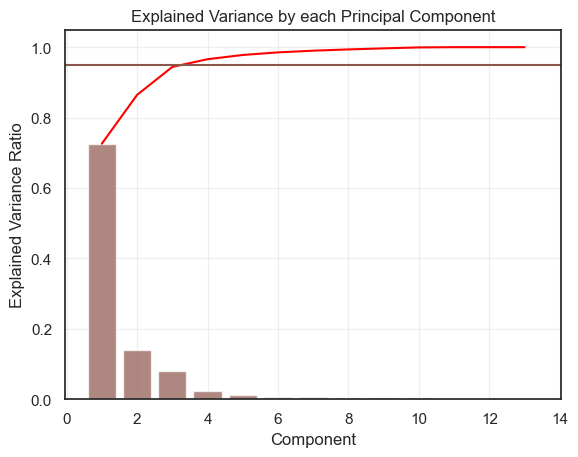

In [147]:
pca = PCA()
pca_components = pca.fit_transform(one_hot_df)
one_hot_df.loc[: ,"PCA1"] = pca_components[:, 0] 
one_hot_df.loc[:, "PCA2"] = pca_components[:, 1]
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.plot(range(1,len(cumulative_variance) + 1), cumulative_variance, label="test", color="red")
plt.grid(True, alpha=0.3, zorder=0)
plt.axhline(y=0.95)
plt.title("Explained Variance by each Principal Component")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [148]:
df_pca = one_hot_df[["PCA1","PCA2"]]
one_hot_df = one_hot_df.drop(columns=["PCA1","PCA2"], axis=1)

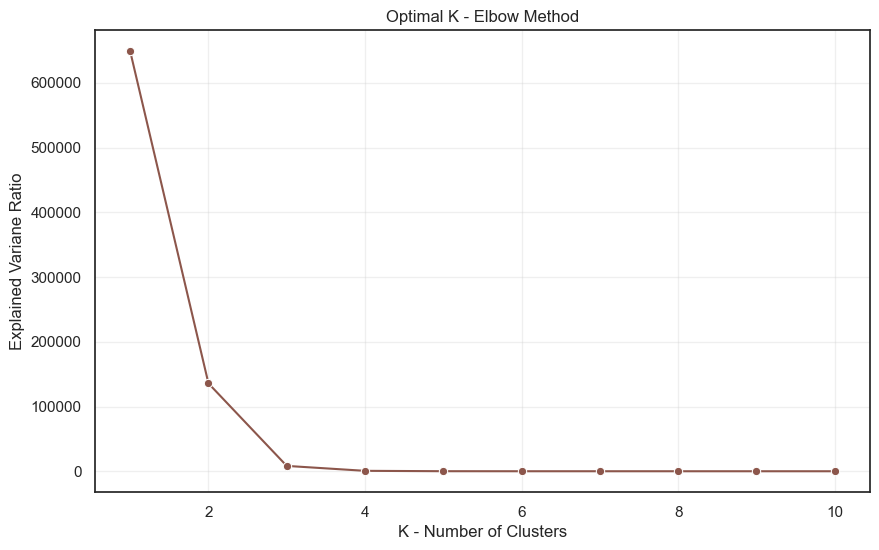

In [149]:
optimal_k(df_pca)

In [150]:
df_pca.head()

PCA1      PCA2
0 -0.244635  0.394688
1 -0.244635  0.394688
2 -0.244635  0.394688
3 -0.244635  0.394688
4 -0.244635  0.394688

In [151]:
apply_kmean(df_pca, 3)

C:\Users\Manso\AppData\Local\Temp\ipykernel_17944\65753446.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Cluster'] = clusters


KMeans(n_clusters=3, random_state=42)

In [152]:
scores = []
for i in range (10):
    sample_indices = df_pca.sample(50000)
    data = sample_indices.drop(columns=["Cluster"], axis=1)
    clusters = sample_indices["Cluster"]
    scores.append(silhouette_score(data, clusters))
    print(f"Iteration Number {i} and current score is {scores[i]}", end=" ")

print()
print(f"Average Silhouette Score is {np.mean(scores)}")

Iteration Number 0 and current score is 0.9777398775074192 Iteration Number 1 and current score is 0.9781787483595722 Iteration Number 2 and current score is 0.9785926536106028 Iteration Number 3 and current score is 0.9793441589262858 Iteration Number 4 and current score is 0.9778565584412974 Iteration Number 5 and current score is 0.9780543679241857 Iteration Number 6 and current score is 0.9784081825432406 Iteration Number 7 and current score is 0.9787131854826305 Iteration Number 8 and current score is 0.9784352292514741 Iteration Number 9 and current score is 0.9790028457097291 
Average Silhouette Score is 0.9784325807756439


In [153]:
# fig, axes = plt.subplots(1, 2, figsize=(14,5))
# sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", ax=axes[0])
# sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", alpha=0.01, legend=False, ax=axes[1])
# plt.show()

In [154]:
df_same_effect_p.loc[:,"Cluster"] = df_pca["Cluster"].values
df_same_effect_p.head()

C:\Users\Manso\AppData\Local\Temp\ipykernel_17944\165858543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_same_effect_p.loc[:,"Cluster"] = df_pca["Cluster"].values


Sample_ID      gene  chrom     start       end ref alt  \
556308   TCGA-EE-A2GC-06A     NCMAP   chr1  24605746  24605746   G   A   
844483   TCGA-GN-A26C-01A   DEFB116  chr20  31303213  31303213   C   T   
2568284  TCGA-H4-A2HQ-01A  HIST1H4D   chr6  26188766  26188766   C   T   
2654354  TCGA-GC-A3OO-01A  HIST1H4D   chr6  26188766  26188766   C   T   
322679   TCGA-W3-AA1V-06B    MRPL36   chr5   1798624   1798624   C   T   

        Amino_Acid_Change                 effect   dna_vaf type cancer  \
556308            p.*103*  stop_retained_variant  0.193548  SNP   SKCM   
844483            p.*103*  stop_retained_variant  0.237500  SNP   SKCM   
2568284           p.*104*  stop_retained_variant  0.270000  SNP   BLCA   
2654354           p.*104*  stop_retained_variant  0.125000  SNP   BLCA   
322679            p.*104*  stop_retained_variant  0.156627  SNP   SKCM   

         Cluster  
556308         2  
844483         2  
2568284        2  
2654354        2  
322679         2

In [155]:
df_same_effect_p["Cluster"].value_counts().reset_index(name="frequency").sort_values(by="Cluster").reset_index(drop=True)

Cluster  frequency
0        0     400599
1        1     815202
2        2     116105

#### Cluster 0

In [156]:
df_p_0 = df_same_effect_p[df_same_effect_p["Cluster"] == 0].drop(columns=["Cluster"], axis=1)
print(df_p_0.shape)
df_p_0.head()

(400599, 12)


Sample_ID     gene  chrom      start        end ref alt  \
1304303  TCGA-OL-A5RW-01A   EFCAB8  chr20   32958461   32958461   C   A   
1337020  TCGA-A7-A56D-01A    KDM5C   chrX   53196036   53196036   G   A   
1873105  TCGA-D8-A1JM-01A  RALGAPB  chr20   38548786   38548786   A   T   
741034   TCGA-A5-A0G1-01A  ZNF518B   chr4   10443329   10443329   G   T   
887099   TCGA-AP-A051-01A  CCDC108   chr2  219021910  219021910   G   T   

        Amino_Acid_Change              effect   dna_vaf type cancer  
1304303          p.A1000A  synonymous_variant  0.307692  SNP   BRCA  
1337020          p.A1000A  synonymous_variant  0.312057  SNP   BRCA  
1873105          p.A1000A  synonymous_variant  0.397163  SNP   BRCA  
741034           p.A1000A  synonymous_variant  0.222222  SNP   UCEC  
887099           p.A1000A  synonymous_variant  0.243902  SNP   UCEC

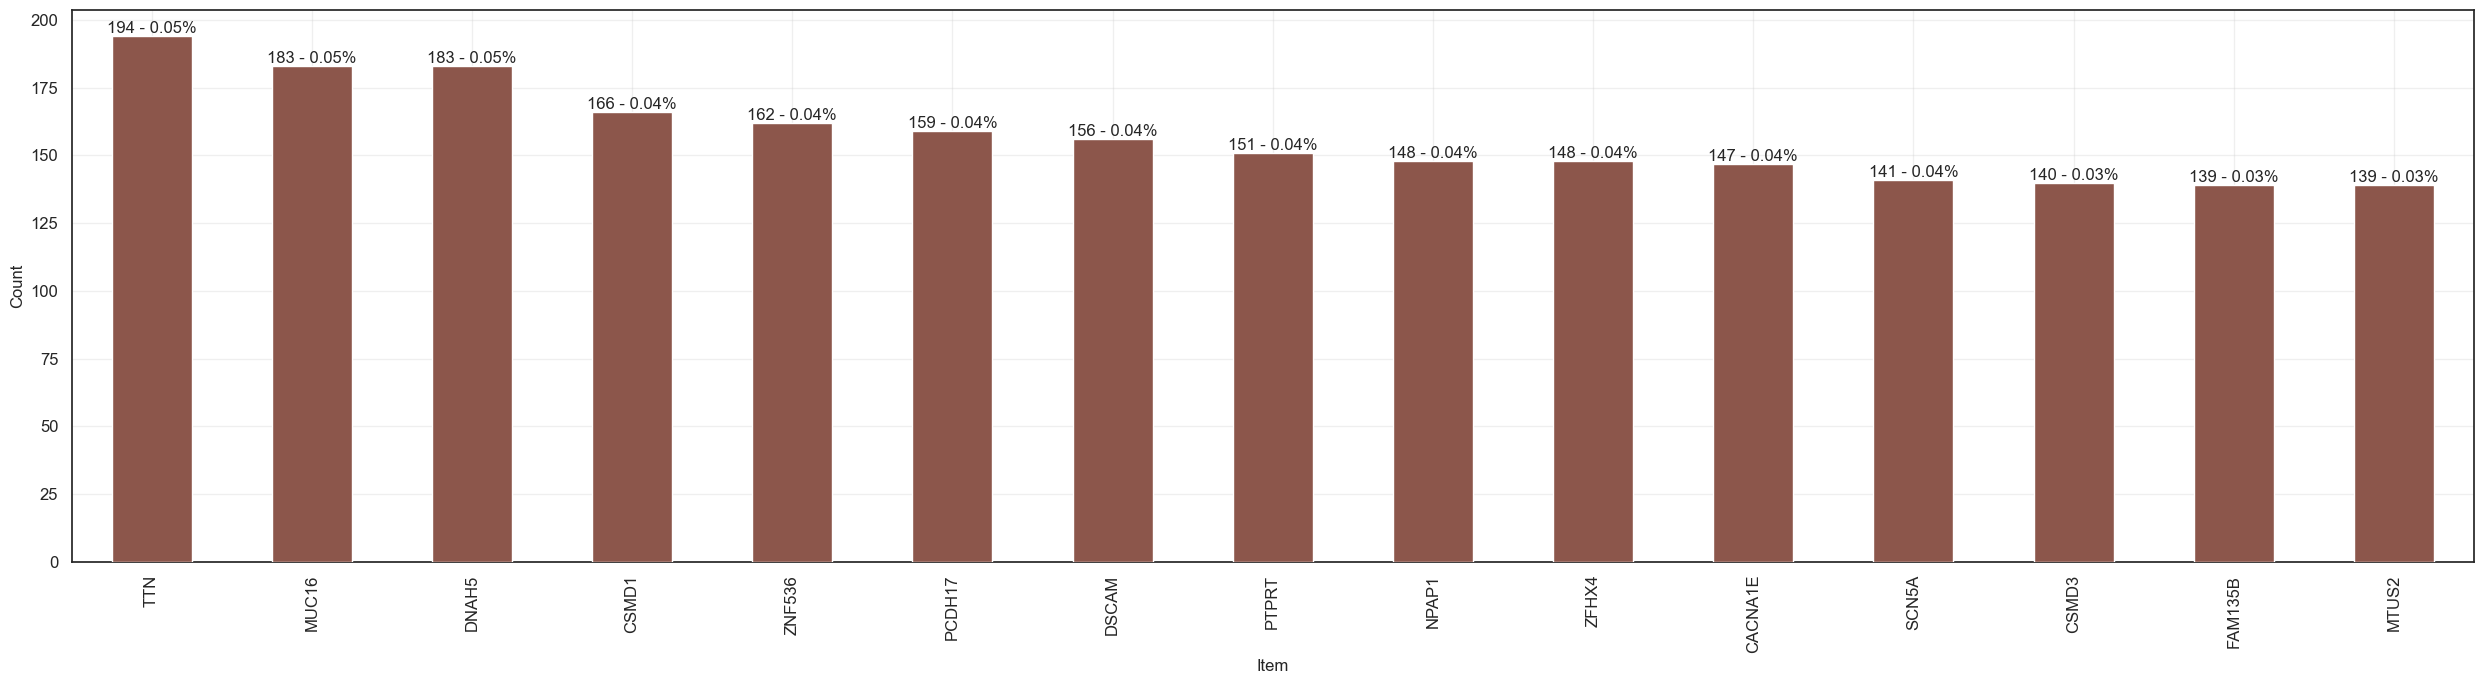

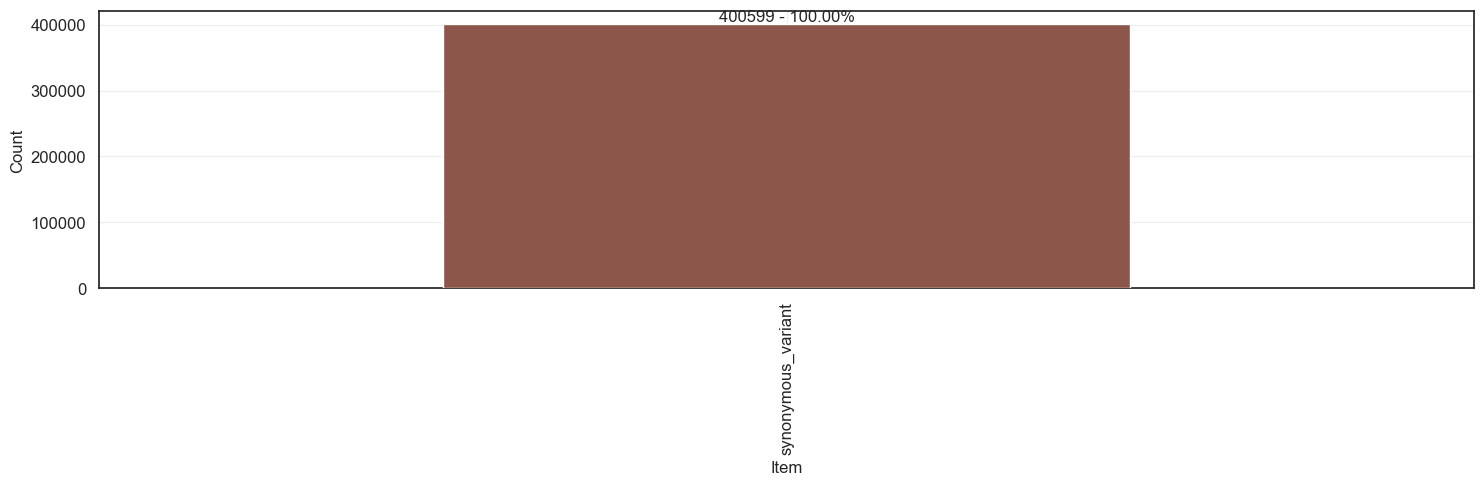

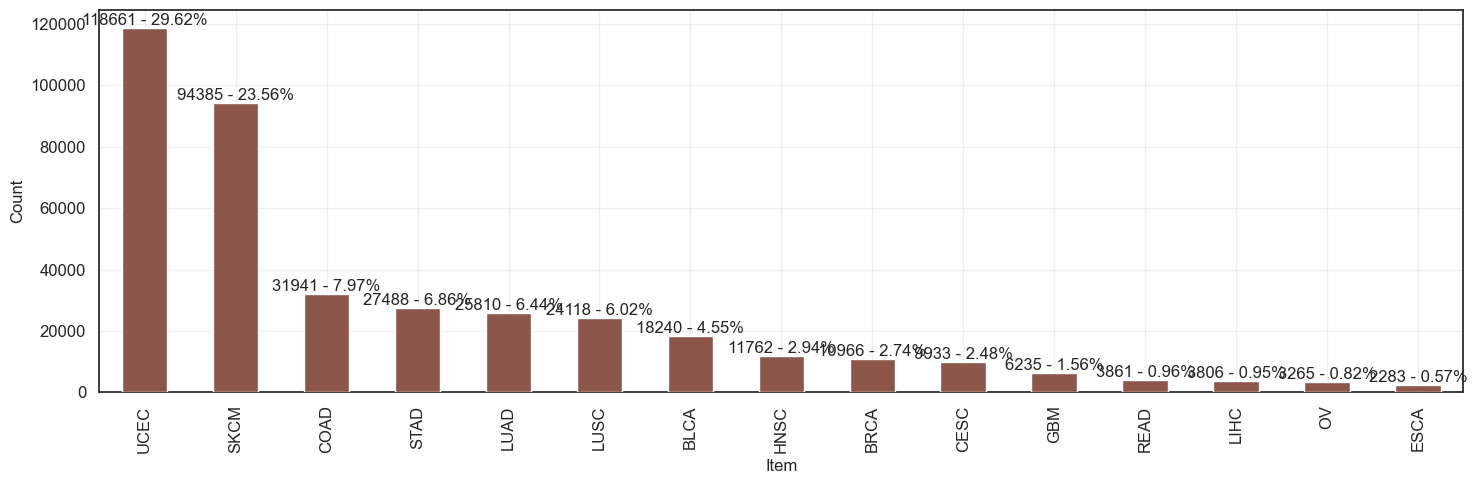

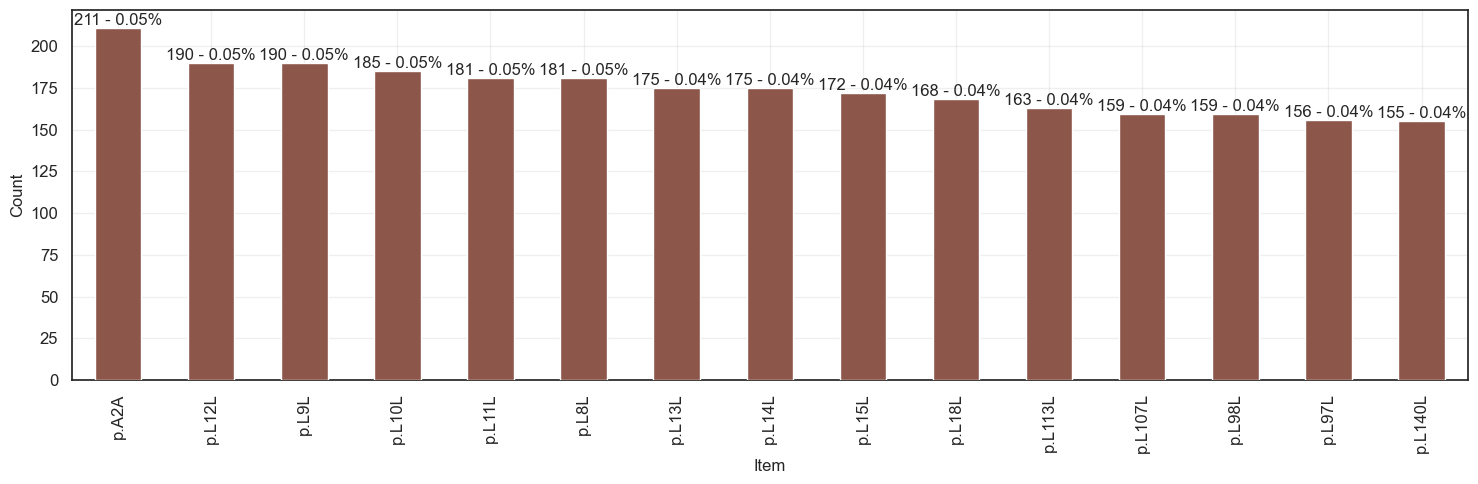

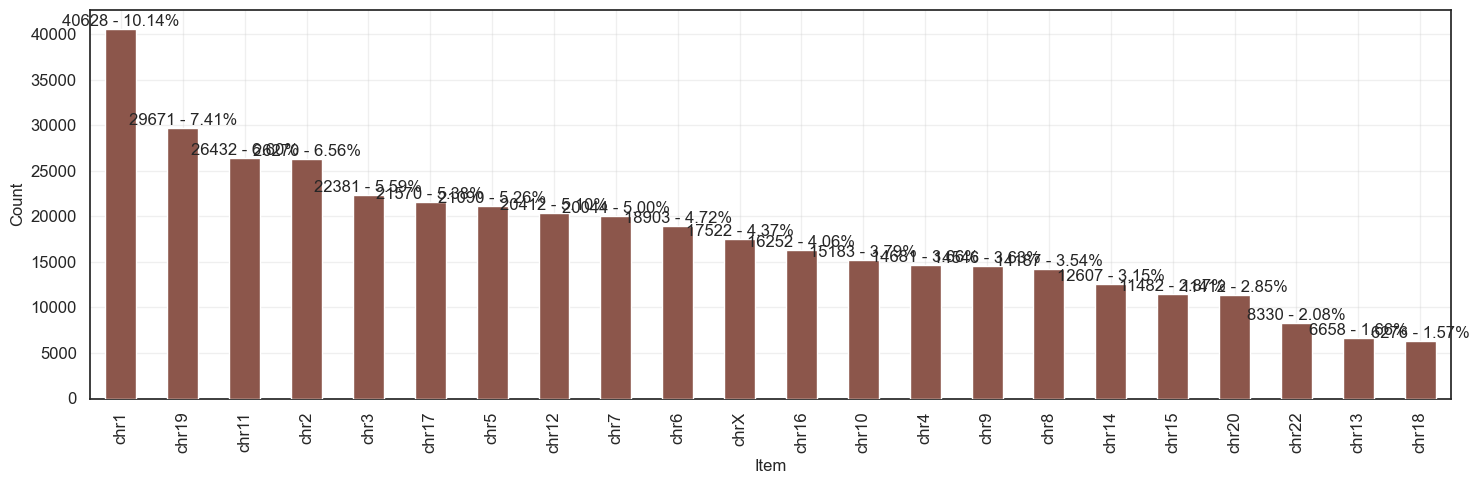

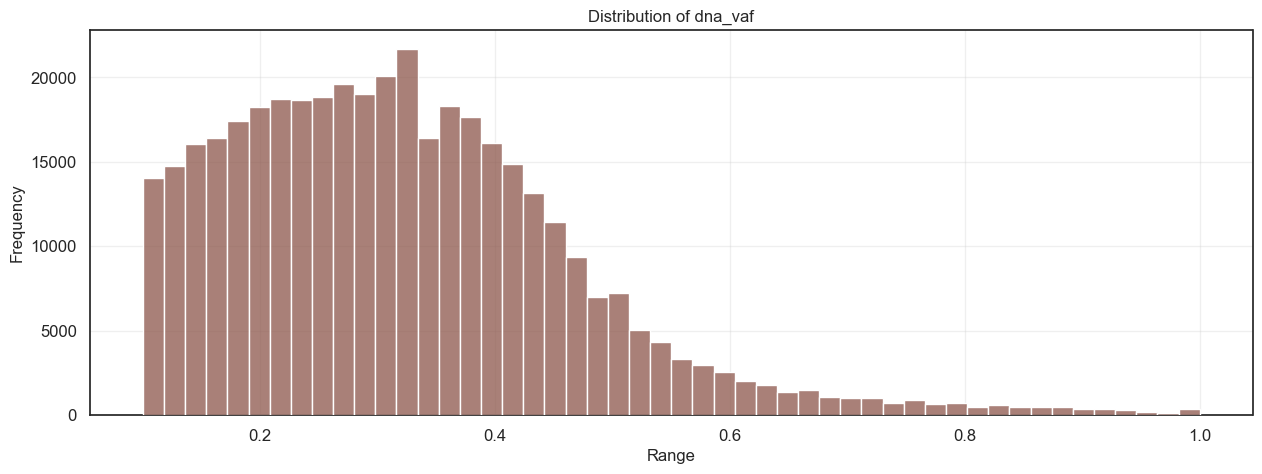

In [157]:
visualize_categorical_frequent(df = df_p_0, feature = "gene", nbr=15, size=(25,7))
visualize_categorical_frequent(df = df_p_0, feature = "effect", nbr=15)
visualize_categorical_frequent(df = df_p_0, feature = "cancer", nbr=15)
visualize_categorical_frequent(df = df_p_0, feature = "Amino_Acid_Change", nbr=15)
visualize_categorical_frequent(df = df_p_0, feature = "chrom", nbr=22)
visualize_numerical_frequent(df = df_p_0, feature = "dna_vaf")

In [158]:
print(df_p_0.shape)
print(df_p_0[df_p_0["Amino_Acid_Change"].str[2] == df_p_0["Amino_Acid_Change"].str[-1]].shape)

(400599, 12)
(400599, 12)


- **For the 0th cluster the genes were balanced having TTN as the highest number. TTN is a gene known for passenger mutations. This balanced characterization opposes the imbalanced distribution found in the mutation dataset. *Cancer-mutation network and the number and specificity of driver mutations* identifies and confirms that a large collection of cancers, present in our dataset such as BRCA and COAD, have an overlapping set of genes that are typicall associated to cancer. This is only true for driver mutations. The paper created a bipartite graph where one side of the nodes are tumour samples and the other side are cancer genes and edges as mutations. The authors of that paper suggests that passenger mutations do not contribute or even hinder cancer progression and driver mutations entail loss of function. This paper potentially explains the gene bias found in this dataset which is due to an overlapping set of genes in agreement with a significant excess of mutations. *Impact of deleterious passenger mutations
 on cancer progression* presents passenger alterations as the vast majority of observed alterations in cancer. As a result, since this cluster has a balanced gene distribution, 100% synonymous_variant, along with what the last paper entailed, this cluster must be full of passenger mutations.**

**The question here: Does that mean that passenger mutations should be neglected??**

- **Because of the doubt that these passenger mutations might be noise, speerate datasets will be created: one that include these passenger mutations (maybe more filtering will occur) and one that does not include these passenger mutations.**

#### Cluster 1

In [159]:
df_p_1 = df_same_effect_p[df_same_effect_p["Cluster"] == 1].drop(columns=["Cluster"], axis=1)
print(df_p_1.shape)
df_p_1.head()

(815202, 12)


Sample_ID    gene  chrom      start        end ref alt  \
411891   TCGA-BR-4184-01A    NOD2  chr16   50729849   50729849   G   T   
2182932  TCGA-VQ-A91Q-01A   LAMA2   chr6  129297826  129297826   G   T   
652469   TCGA-AA-3877-01A    SLTM  chr15   58880103   58880103   C   T   
827252   TCGA-CA-6717-01A    JAG1  chr20   10641160   10641160   C   T   
2599997  TCGA-DM-A1DA-01A  SLC4A2   chr7  151074795  151074795   G   A   

        Amino_Acid_Change            effect   dna_vaf type cancer  
411891           p.A1000S  missense_variant  0.171053  SNP   STAD  
2182932          p.A1000S  missense_variant  0.464286  SNP   STAD  
652469           p.A1001T  missense_variant  0.208333  SNP   COAD  
827252           p.A1001T  missense_variant  0.235294  SNP   COAD  
2599997          p.A1001T  missense_variant  0.253846  SNP   COAD

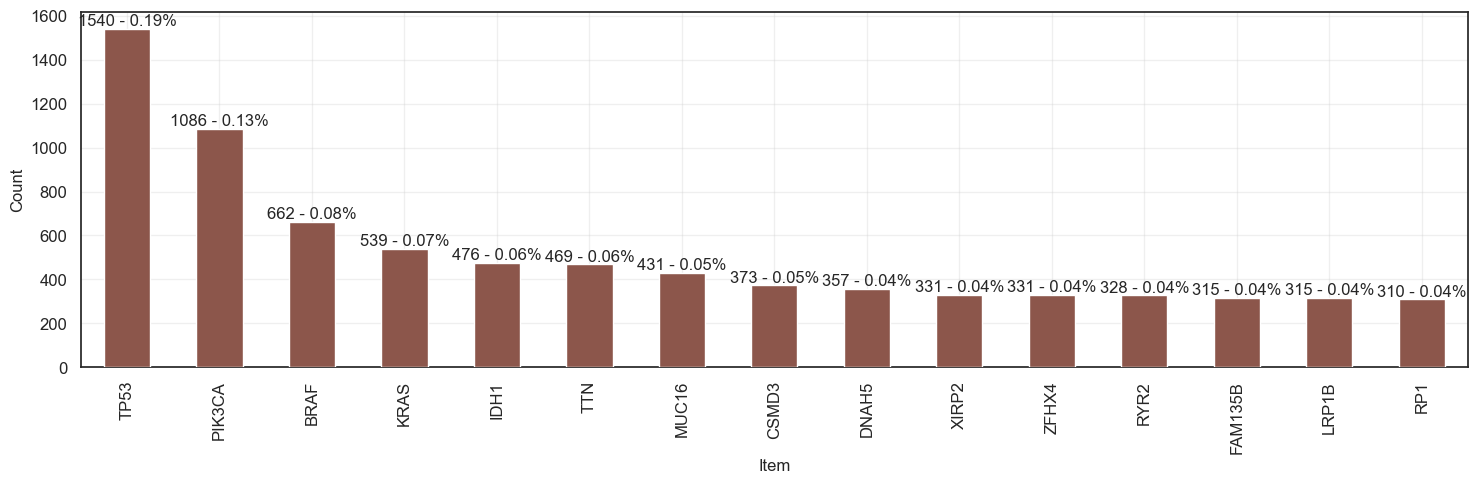

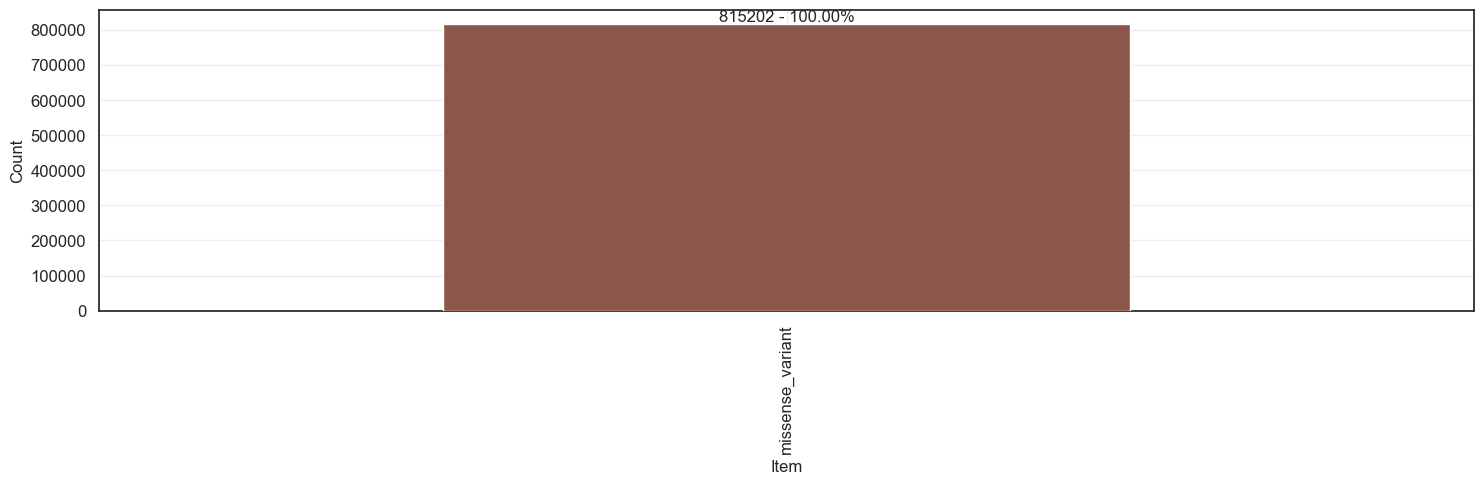

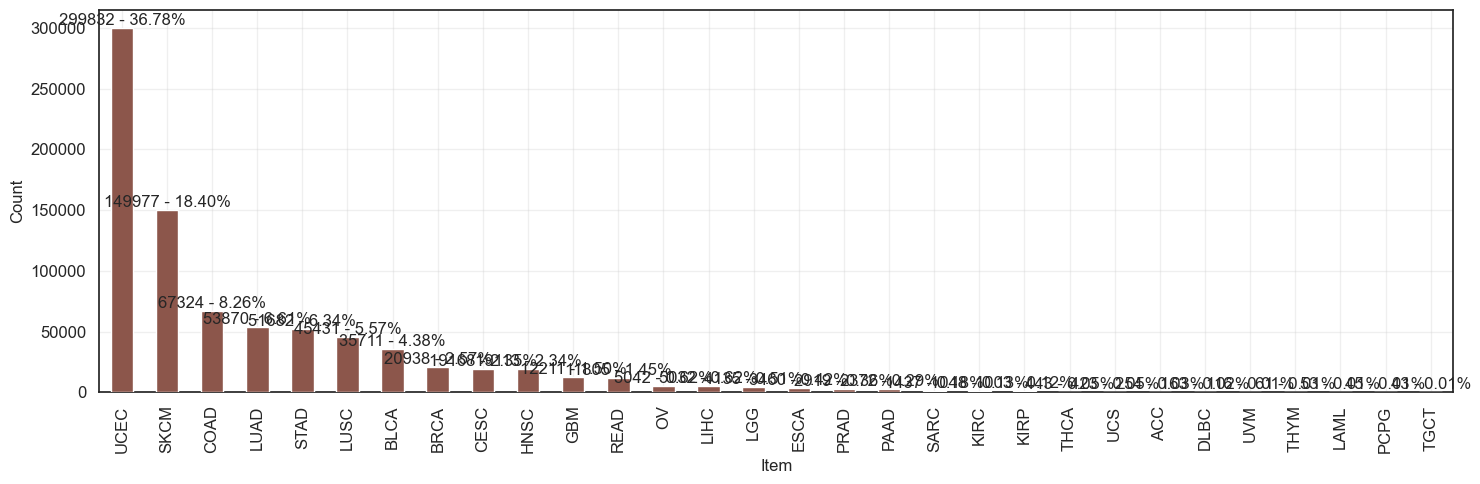

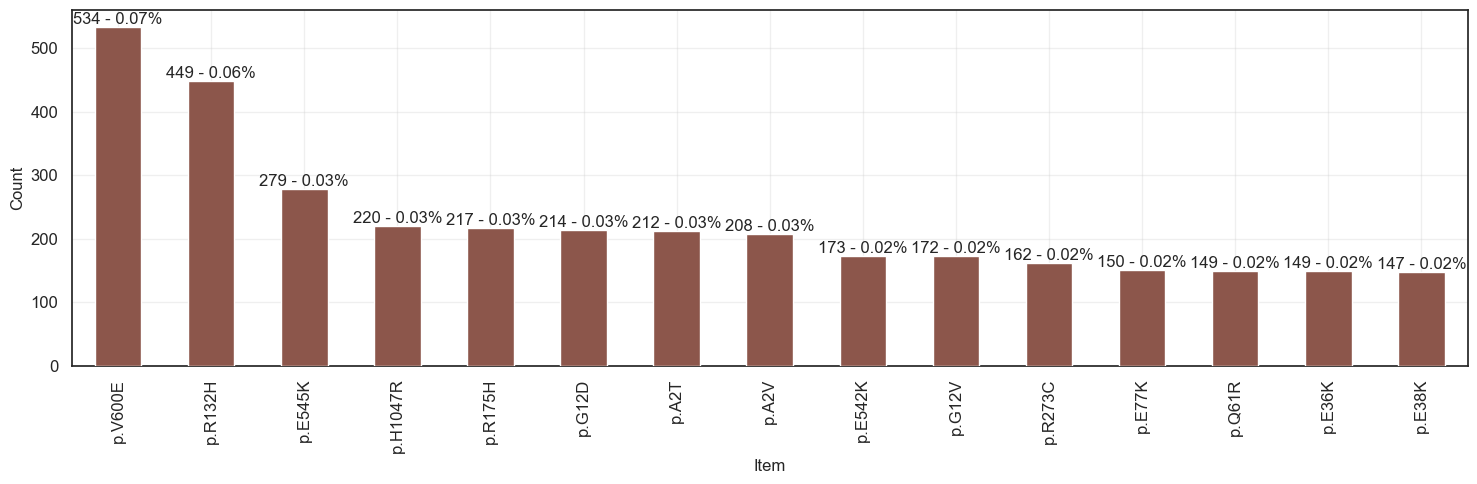

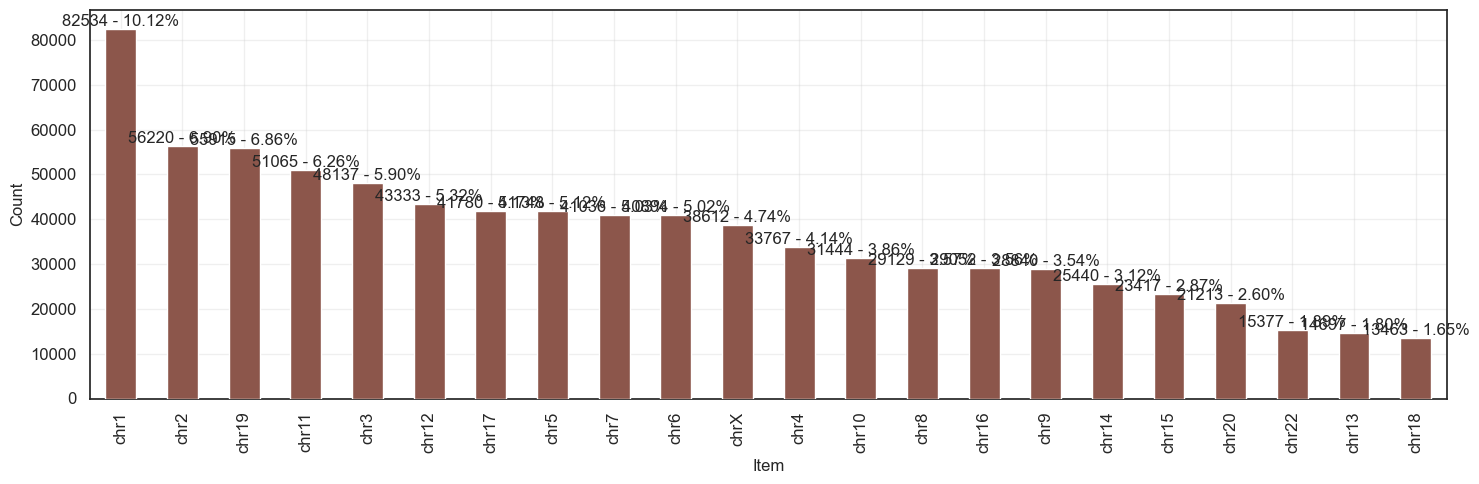

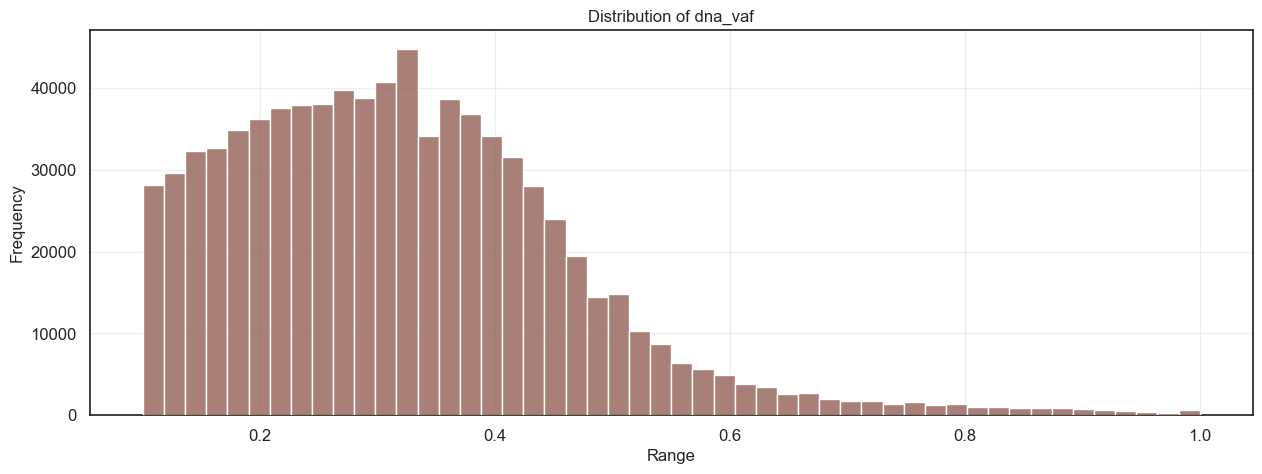

In [160]:
visualize_categorical_frequent(df = df_p_1, feature = "gene", nbr=15)
visualize_categorical_frequent(df = df_p_1, feature = "effect", nbr=15)
visualize_categorical_frequent(df = df_p_1, feature = "cancer", nbr=30)
visualize_categorical_frequent(df = df_p_1, feature = "Amino_Acid_Change", nbr=15)
visualize_categorical_frequent(df = df_p_1, feature = "chrom", nbr=22)
visualize_numerical_frequent(df = df_p_1, feature = "dna_vaf")

- **This cluster is quite opposite to the 0th cluster. In fact, the long tail distribution exhibited in the gene distribution graph, dominated by tumour supressor gene TP53 that makes the protein p53, along with the 100% missense_variant, these mutation represent driver mutations more than passenger mutations, if any. These should be analyze more to see the relationship between these genes.**
- **According to https://www.osmosis.org/answers/missense-mutation, missense mutations are quite common and, in most cases, do not affect the overall shape and function of the protein. However, when the amino acid substitution involves two amino acids with very different chemical properties, missense mutations can lead to significant changes in protein function. These are known as non-conversative missense mutations.** 


**TO-DO**:
- Maybe apply the bipartite graph thing to map cancer to genes. But you need to choose which genes to select.
- Maybe gene imbalance is partially due to what was said in the paper title "Cancer-mutation network and the number and
 specificity of driver mutations": driver mutations tend to have a cluster of repeated genes.

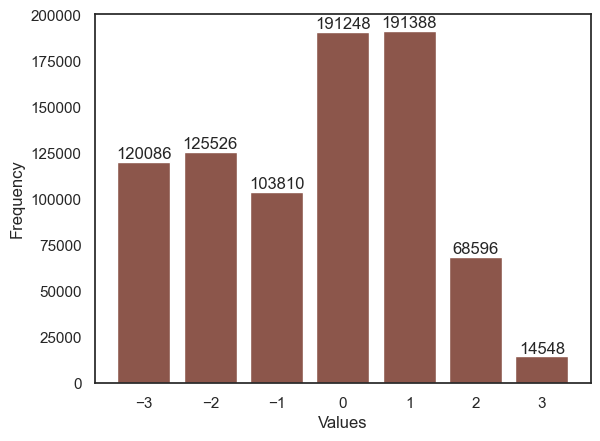

In [161]:
#### STOPPED HERE

matrix = bl.BLOSUM(62)
values_matrix = []
for index, row in df_p_1.iterrows():
    amino_acid_row = row["Amino_Acid_Change"]
    pair = (amino_acid_row[2], amino_acid_row[-1])
    values_matrix.append(matrix[pair[0]][pair[1]])

freq = Counter(values_matrix)
plt.bar(freq.keys(), freq.values())
for x, y in freq.items():
    plt.text(x,y, freq[x], ha="center",va="bottom")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

- **274532 mutations are conservative mutations with the two amino acids having similar biochemical properties. These are more likely passenger mutations since they have no significant impact on tumour growth. These scores indicate these substitutions are commonly seen.**
- **349422 mutations are non-conservation mutations with significant functional impact on the protein. These are more likely to be driver mutations. These scores indicate that these substitutions are rarely seen.**
- **Since this is not enough to confidently distinguish the driver and passener mutations, more analysis such as assessing the selective advantage should be conducted. A driver mutation that promototes cancer cell growth is more likely to get passed on more often giving it a selective advantage, unlike the passenger mutations.**
- **191248 mutations are substitutions expected by chance.**
- **BLOSUM matrices are based on observed frequencies not on any predictions from amino acid properties.**


Meaning of the scores: https://www.nlm.nih.gov/ncbi/workshops/2023-08_BLAST_evol/blast_score.html

In [162]:
def change_val(val):
    if val > 0:
        return "conservative"
    elif val == 0:
        return "chance"
    else:
        return "non-conservative"
df_p_1["missense_type"] = values_matrix
df_p_1["missense_type"] = df_p_1["missense_type"].apply(change_val)

In [163]:
df_p_1_conservative = df_p_1[df_p_1["missense_type"] == "conservative"]
print(df_p_1_conservative.shape)

(274532, 13)


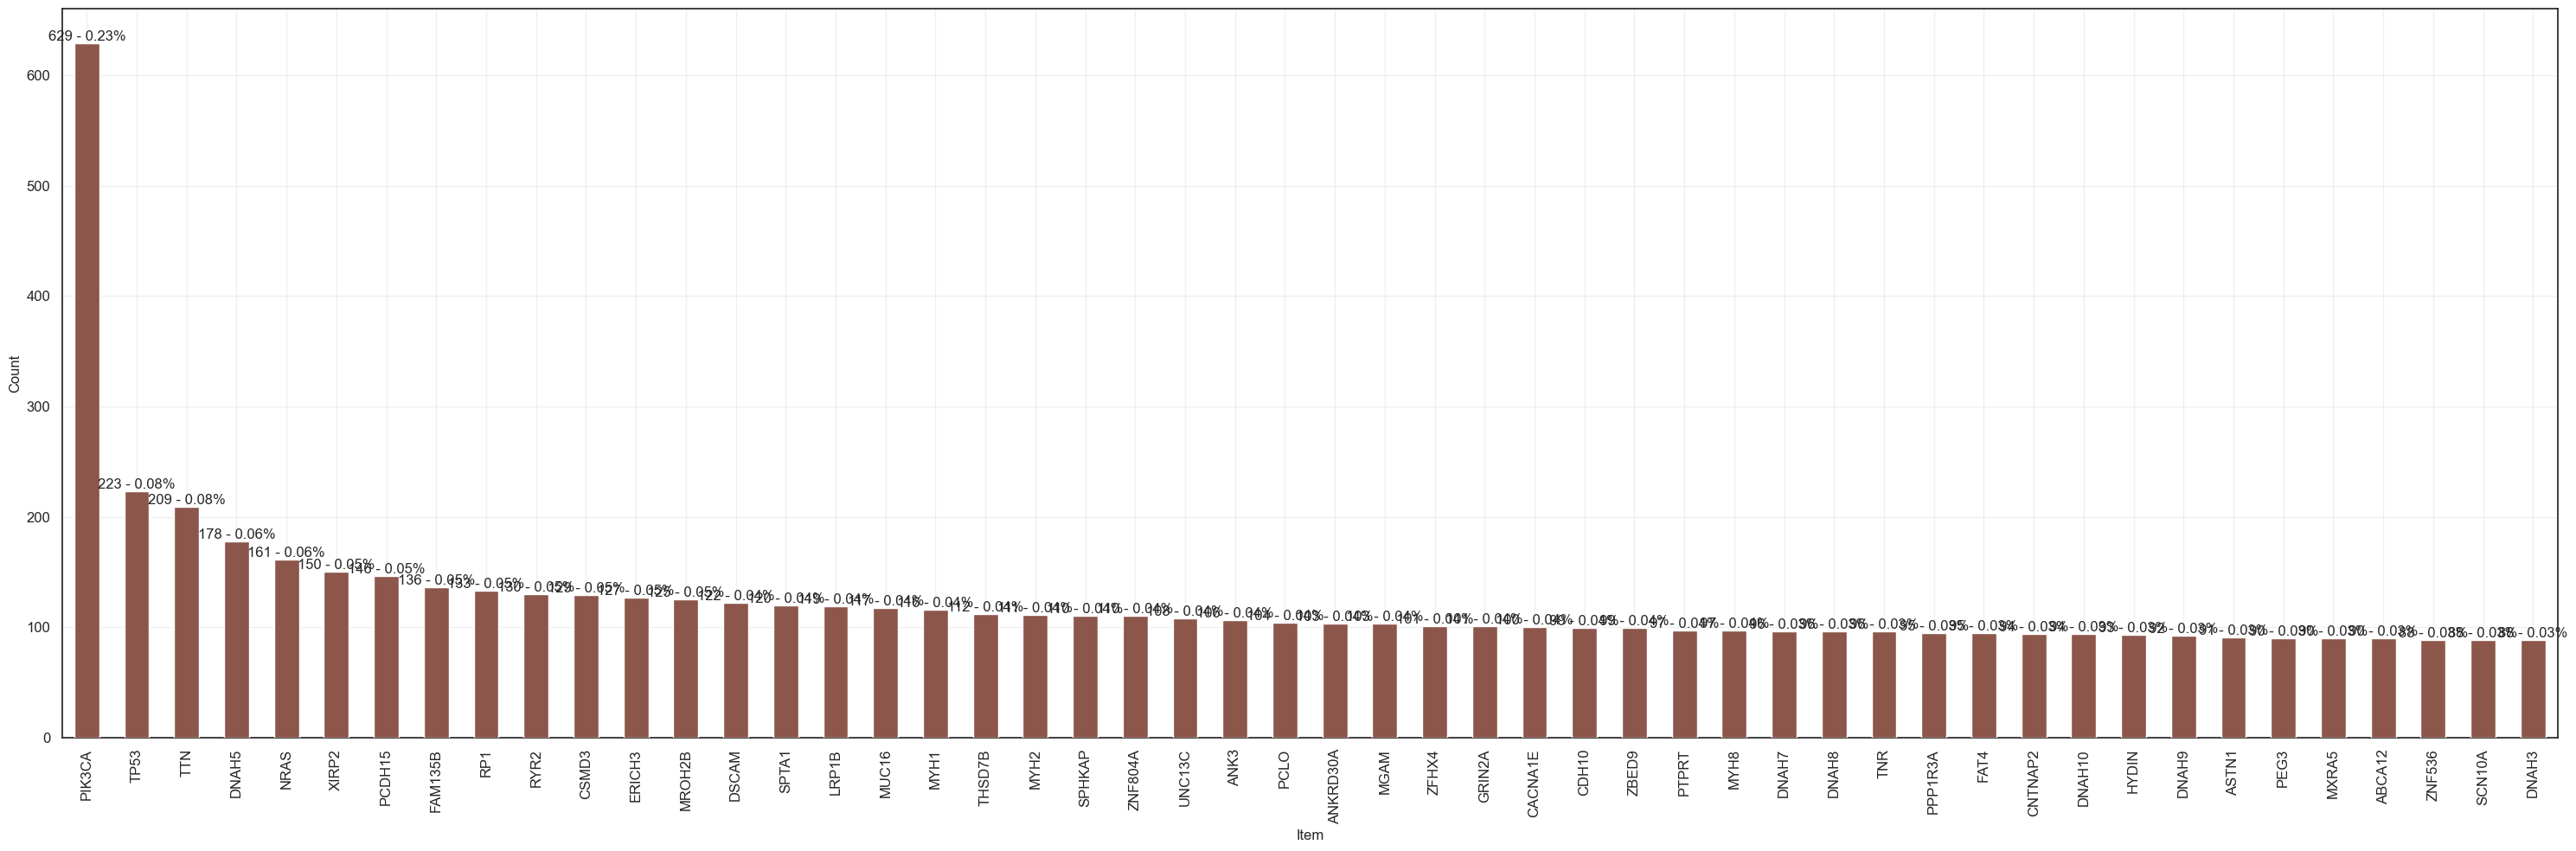

In [164]:
visualize_categorical_frequent(df_p_1_conservative, "gene", nbr=50, size=(30,10))

- **While all genes are blanaced here, PIK3CA is the dominating gene. PIK3CA makes the p110α protein. According to "PIK3CA mutations in human solid tumors" and https://medlineplus.gov/genetics/gene/pik3ca/, mutations in PIK3CA increases PI3K signal which promote tumour growth and increase cell invasion. The PI3K pathway is considered to play an important role in tumourigenesis(process by which normal cells transform into cancer cells). The p110α protein is a subunit of PI3K activated by the PIK3CA mutation. It is obvious to conclude that this mutation is a driver mutation.**

In [166]:
print(cosmics.shape)
print(cosmics.columns)

(5437368, 58)
Index(['GENE_NAME', 'ACCESSION_NUMBER', 'ONC_TSG', 'CGC_TIER', 'MUTATION_URL',
       'LEGACY_MUTATION_ID', 'Mutation CDS', 'Mutation AA', 'AA_MUT_START',
       'AA_MUT_STOP', 'SHARED_AA', 'GENOMIC_WT_ALLELE_SEQ',
       'GENOMIC_MUT_ALLELE_SEQ', 'AA_WT_ALLELE_SEQ', 'AA_MUT_ALLELE_SEQ',
       'Mutation Description CDS', 'Mutation Description AA',
       'ONTOLOGY_MUTATION_CODE', 'GENOMIC_MUTATION_ID',
       'Mutation genome position GRCh37', 'Mutation genome position GRCh38',
       'COSMIC_SAMPLE_TESTED', 'COSMIC_SAMPLE_MUTATED', 'DISEASE',
       'WGS_DISEASE', 'EXAC_AF', 'EXAC_AFR_AF', 'EXAC_AMR_AF', 'EXAC_ADJ_AF',
       'EXAC_EAS_AF', 'EXAC_FIN_AF', 'EXAC_NFE_AF', 'EXAC_SAS_AF',
       'GNOMAD_EXOMES_AF', 'GNOMAD_EXOMES_AFR_AF', 'GNOMAD_EXOMES_AMR_AF',
       'GNOMAD_EXOMES_ASJ_AF', 'GNOMAD_EXOMES_EAS_AF', 'GNOMAD_EXOMES_FIN_AF',
       'GNOMAD_EXOMES_NFE_AF', 'GNOMAD_EXOMES_SAS_AF', 'GNOMAD_GENOMES_AF',
       'GNOMAD_GENOMES_AFR_AF', 'GNOMAD_GENOMES_AMI_AF',
   

In [167]:
patterns = ["MUTATION_URL","LEGACY_MUTATION_ID","EXAC_", "GNOMAD_EXOMES_", "GNOMAD_GENOMES_"]
columns = []
for pattern in patterns:
    columns = columns + [col for col in cosmics.columns if pattern in col]

cosmics.drop(columns=columns, inplace=True)
cosmics.head()

GENE_NAME   ACCESSION_NUMBER ONC_TSG  CGC_TIER Mutation CDS Mutation AA  \
0     SF3B4  ENST00000271628.8     NaN       NaN     c.246G>T      p.K82N   
1     SF3B4  ENST00000271628.8     NaN       NaN      c.22G>C       p.E8Q   
2     SF3B4  ENST00000271628.8     NaN       NaN     c.390C>T     p.P130=   
3     SF3B4  ENST00000271628.8     NaN       NaN     c.309C>T     p.F103=   
4     SF3B4  ENST00000271628.8     NaN       NaN     c.352G>A     p.D118N   

   AA_MUT_START  AA_MUT_STOP  SHARED_AA GENOMIC_WT_ALLELE_SEQ  \
0            82           82          1                     C   
1             8            8          1                     C   
2           130          130          4                     G   
3           103          103          1                     G   
4           118          118          2                     C   

  GENOMIC_MUT_ALLELE_SEQ AA_WT_ALLELE_SEQ AA_MUT_ALLELE_SEQ  \
0                      A                K                 N   
1                      G                E                 Q   
2                      A                P                 P   
3                      A                F                 F   
4                      T                D                 N   

  Mutation Description CDS       Mutation Description AA  \
0             Substitution       Substitution - Missense   
1             Substitution       Substitution - Missense   
2             Substitution  Substitution - coding silent   
3             Substitution  Substitution - coding silent   
4             Substitution       Substitution - Missense   

  ONTOLOGY_MUTATION_CODE GENOMIC_MUTATION_ID Mutation genome position GRCh37  \
0             SO:0001583       COSV104376534           1:149898728-149898728   
1             SO:0001583        COSV99641187           1:149899630-149899630   
2             SO:1000057        COSV99641067           1:149898584-149898584   
3             SO:1000057       COSV107229065           1:149898665-149898665   
4             SO:0001583        COSV54965386           1:149898622-149898622   

  Mutation genome position GRCh38  COSMIC_SAMPLE_TESTED  \
0           1:149926836-149926836                 50241   
1           1:149927738-149927738                 50241   
2           1:149926692-149926692                 50241   
3           1:149926773-149926773                 50241   
4           1:149926730-149926730                 50241   

   COSMIC_SAMPLE_MUTATED DISEASE WGS_DISEASE CLINVAR_CLNSIG CLINVAR_TRAIT  \
0                      1     NaN         NaN            NaN           NaN   
1                      1     NaN         NaN            NaN           NaN   
2                      1     NaN         NaN            NaN           NaN   
3                      1     NaN         NaN            NaN           NaN   
4                      1     NaN         NaN            NaN           NaN   

   GERP++_RS  MIN_SIFT_SCORE MIN_SIFT_PRED DNDS_DISEASE_QVAL_SIG  \
0      -1.65           0.006             D                   NaN   
1       4.91           0.039             D                   NaN   
2        NaN           1.000           NaN                   NaN   
3        NaN           1.000           NaN                   NaN   
4       4.91           0.017             D                   NaN   

  MUTATION_SIGNIFICANCE_TIER  
0                      Other  
1                      Other  
2                      Other  
3                      Other  
4                      Other

In [168]:
cosmics_no_na = cosmics.dropna()
cosmics_no_na.head()

GENE_NAME   ACCESSION_NUMBER   ONC_TSG  CGC_TIER Mutation CDS  \
6452       SF3B1  ENST00000335508.6  oncogene       1.0    c.2098A>G   
7095       SF3B1  ENST00000335508.6  oncogene       1.0    c.1874G>A   
152176   PPP2R1A  ENST00000322088.6       TSG       1.0     c.547C>T   
152388   PPP2R1A  ENST00000322088.6       TSG       1.0     c.536C>G   
231408    PIK3R2  ENST00000222254.8  oncogene       2.0    c.1117G>A   

       Mutation AA  AA_MUT_START  AA_MUT_STOP  SHARED_AA  \
6452       p.K700E           700          700         10   
7095       p.R625H           625          625          6   
152176     p.R183W           183          183          4   
152388     p.P179R           179          179          6   
231408     p.G373R           373          373          1   

       GENOMIC_WT_ALLELE_SEQ GENOMIC_MUT_ALLELE_SEQ AA_WT_ALLELE_SEQ  \
6452                       T                      C                K   
7095                       C                      T                R   
152176                     C                      T                R   
152388                     C                      G                P   
231408                     G                      A                G   

       AA_MUT_ALLELE_SEQ Mutation Description CDS  Mutation Description AA  \
6452                   E             Substitution  Substitution - Missense   
7095                   H             Substitution  Substitution - Missense   
152176                 W             Substitution  Substitution - Missense   
152388                 R             Substitution  Substitution - Missense   
231408                 R             Substitution  Substitution - Missense   

       ONTOLOGY_MUTATION_CODE GENOMIC_MUTATION_ID  \
6452               SO:0001583        COSV59205318   
7095               SO:0001583        COSV59205431   
152176             SO:0001583        COSV59042187   
152388             SO:0001583        COSV59042232   
231408             SO:0001583        COSV55846573   

       Mutation genome position GRCh37 Mutation genome position GRCh38  \
6452             2:198266834-198266834           2:197402110-197402110   
7095             2:198267483-198267483           2:197402759-197402759   
152176            19:52715982-52715982            19:52212729-52212729   
152388            19:52715971-52715971            19:52212718-52212718   
231408            19:18273784-18273784            19:18162974-18162974   

        COSMIC_SAMPLE_TESTED  COSMIC_SAMPLE_MUTATED  \
6452                   96881                    789   
7095                   96881                    119   
152176                 73740                     88   
152388                 73740                     88   
231408                 67015                     27   

                                                  DISEASE  \
6452    NS/NS/NS=17/111=15.32%;breast/carcinoma/ductal...   
7095    eye/malignant_melanoma/NS=39/767=5.08%;eye/mal...   
152176  endometrium/carcinoma/endometrioid_carcinoma=1...   
152388  endometrium/carcinoma/carcinosarcoma-malignant...   
231408  endometrium/carcinoma/endometrioid_carcinoma=9...   

                                              WGS_DISEASE  \
6452    haematopoietic_and_lymphoid_tissue/lymphoid_ne...   
7095    eye/malignant_melanoma/mixed=4/38=10.53%;eye/m...   
152176  endometrium/carcinoma/endometrioid_carcinoma=8...   
152388  endometrium/carcinoma/endometrioid_carcinoma=2...   
231408  endometrium/carcinoma/endometrioid_carcinoma=8...   

                                           CLINVAR_CLNSIG  \
6452                  Likely pathogenic&Likely pathogenic   
7095    Likely pathogenic&Likely pathogenic&Likely pat...   
152176  Likely pathogenic&Likely pathogenic&Likely pat...   
152388                Likely pathogenic&Likely pathogenic   
231408  Pathogenic&Pathogenic&Pathogenic&Pathogenic/Li...   

                                            CLINVAR_TRAIT  GERP++_RS  \
6452                  Acute myeloid leukemi

In [169]:
cosmics.shape

(5437368, 30)

**Some Column Description:**
- **MIN_SIFT_SCORE - Minimum Sift Score: Scores range from 0 to 1. The smaller the score the more likely the SNP has damaging effect**
- **MIN_SIFT_PRED - Prediction corresponding to the minimum sift score. If SIFTori is smaller than 0.05 the corresponding nsSNV is predicted as "D(damaging)"; otherwise it is predicted as "T(tolerated)"**
- **MUTATION_SIGNIFICANCE_TIER: This is Mutation Significance. A classification system to categorize the impact of the mutation of human health. The categories are: high significance - medium significance - low significance - Other (No predicted significance, other mutation)**



**SIFT predicts whether an amino acid substitution affects protein function based on sequence homology and the physical properties of amino acids. SIFT can be applied to naturally occurring nonsynonymous polymorphisms and laboratory-induced missense mutations.**

**The main types of genes that play a role in cancer are: Oncogenes, Tumour suppressor genes, and DNA repair genes.**
https://www.cancer.org/cancer/understanding-cancer/genes-and-cancer/oncogenes-tumor-suppressor-genes.html

In [170]:
cosmics.columns

Index(['GENE_NAME', 'ACCESSION_NUMBER', 'ONC_TSG', 'CGC_TIER', 'Mutation CDS',
       'Mutation AA', 'AA_MUT_START', 'AA_MUT_STOP', 'SHARED_AA',
       'GENOMIC_WT_ALLELE_SEQ', 'GENOMIC_MUT_ALLELE_SEQ', 'AA_WT_ALLELE_SEQ',
       'AA_MUT_ALLELE_SEQ', 'Mutation Description CDS',
       'Mutation Description AA', 'ONTOLOGY_MUTATION_CODE',
       'GENOMIC_MUTATION_ID', 'Mutation genome position GRCh37',
       'Mutation genome position GRCh38', 'COSMIC_SAMPLE_TESTED',
       'COSMIC_SAMPLE_MUTATED', 'DISEASE', 'WGS_DISEASE', 'CLINVAR_CLNSIG',
       'CLINVAR_TRAIT', 'GERP++_RS', 'MIN_SIFT_SCORE', 'MIN_SIFT_PRED',
       'DNDS_DISEASE_QVAL_SIG', 'MUTATION_SIGNIFICANCE_TIER'],
      dtype='object')

In [171]:
columns_to_keep = [
    "GENE_NAME", 
    "Mutation AA", 
    "Mutation Description AA", 
    "Mutation genome position GRCh38", 
    "MIN_SIFT_SCORE", 
    "MIN_SIFT_PRED", 
    "MUTATION_SIGNIFICANCE_TIER",
    "DNDS_DISEASE_QVAL_SIG",
    "GERP++_RS"
]

cosmics_needed = cosmics[columns_to_keep]
cosmics_needed = cosmics_needed.rename(columns={"GENE_NAME": "gene","Mutation AA": "Amino_Acid_Change","Mutation Description AA": "effect"})
cosmics_needed = cosmics_needed.dropna(subset=["Mutation genome position GRCh38"])
cosmics_needed["start"] = cosmics_needed["Mutation genome position GRCh38"].apply(lambda x : x.split(":")[1].split("-")[0])
cosmics_needed["end"] = cosmics_needed["Mutation genome position GRCh38"].apply(lambda x : x.split(":")[1].split("-")[1])
cosmics_needed = cosmics_needed[cosmics_needed["effect"] == "Substitution - Missense"]
cosmics_needed.drop(columns=["Mutation genome position GRCh38", "effect"], inplace=True)
cosmics_needed["start"] = cosmics_needed["start"].astype(int)
cosmics_needed["end"] = cosmics_needed["end"].astype(int)
print(cosmics_needed.shape)
print(cosmics_needed.columns)
cosmics_needed.head()

(3671905, 9)
Index(['gene', 'Amino_Acid_Change', 'MIN_SIFT_SCORE', 'MIN_SIFT_PRED',
       'MUTATION_SIGNIFICANCE_TIER', 'DNDS_DISEASE_QVAL_SIG', 'GERP++_RS',
       'start', 'end'],
      dtype='object')


gene Amino_Acid_Change  MIN_SIFT_SCORE MIN_SIFT_PRED  \
0  SF3B4            p.K82N           0.006             D   
1  SF3B4             p.E8Q           0.039             D   
4  SF3B4           p.D118N           0.017             D   
6  SF3B4           p.P413L           0.000             D   
7  SF3B4           p.G269W           0.000             D   

  MUTATION_SIGNIFICANCE_TIER DNDS_DISEASE_QVAL_SIG  GERP++_RS      start  \
0                      Other                   NaN      -1.65  149926836   
1                      Other                   NaN       4.91  149927738   
4                      Other                   NaN       4.91  149926730   
6                      Other                   NaN       4.18  149923579   
7                      Other                   NaN       4.33  149925944   

         end  
0  149926836  
1  149927738  
4  149926730  
6  149923579  
7  149925944

In [172]:
"""If both key columns contain rows where the key is a null value, 
those rows will be matched against each other. 
This is different from usual SQL join behaviour and can lead to unexpected results.

This is taken from pandas documentation on the merge method."""
merge_on_columns = ["gene", "Amino_Acid_Change","start","end"]
for column in merge_on_columns:
    print(cosmics_needed[column].isna().sum())

0
0
0
0


In [173]:
print(cosmics_needed.duplicated(subset=merge_on_columns).sum())
print(df_p_1.duplicated(subset=merge_on_columns).sum())

14523
81039


In [174]:
cosmics_needed[cosmics_needed.duplicated()].shape

(14377, 9)

- **There are 14398 duplicated overall in this dataset so they should be dropped so they do not cause any trouble when merging.**
- **There are duplicates based on all columns except *MUTATION_SIGNIFICANCE_TIER*. So only the rows having numerical values instead of "other-no prediction" will be kept.**
- **There are duplicates based on the *merge_on_columns***
- **The Other values in the MUTATION_SIGNIFICANCE_TIER will be changed from Other to 0. Because letters are considered to be bigger than numbers. As a result, when sorting to select the right duplicates the letters will ruin it.**

In [175]:
print(cosmics_needed.duplicated(subset=merge_on_columns).sum())

14523


In [176]:
cosmics_needed["MUTATION_SIGNIFICANCE_TIER"] = cosmics_needed["MUTATION_SIGNIFICANCE_TIER"].replace({"Other":0})

In [177]:
cosmics_needed = cosmics_needed.sort_values(by=[*merge_on_columns,"MIN_SIFT_SCORE", "MUTATION_SIGNIFICANCE_TIER"])
cosmics_needed.drop_duplicates(inplace=True)
cosmics_needed.drop_duplicates([*merge_on_columns, "MIN_SIFT_SCORE","MIN_SIFT_PRED", "DNDS_DISEASE_QVAL_SIG", "GERP++_RS"], keep="last", inplace=True)
cosmics_needed.drop_duplicates([*merge_on_columns, "MIN_SIFT_SCORE","MIN_SIFT_PRED"], keep="last", inplace=True)
cosmics_needed.drop_duplicates(subset=merge_on_columns, keep="first", inplace=True)

- **While this might feel redundant, it is important to drop duplicates multiple times to keep the right variation of the entries.**
- **The first occurences have lower MIN_SIFT_SCORE indicating that they are more likely to be driver mutations. Also, some of those have non null values in the MIN_SIFT_PRED as a result they will be picked.**

In [178]:
cosmics_needed.duplicated(subset=merge_on_columns).sum()

np.int64(0)

In [179]:
df_p_1_merged = df_p_1.merge(cosmics_needed, how="left", on=merge_on_columns)
print(df_p_1_merged.shape)
print(df_p_1_merged.isna().sum())
df_p_1_merged.head()

(815202, 18)
Sample_ID                          0
gene                               0
chrom                              0
start                              0
end                                0
ref                                0
alt                                0
Amino_Acid_Change                  0
effect                             0
dna_vaf                            0
type                               0
cancer                             0
missense_type                      0
MIN_SIFT_SCORE                189014
MIN_SIFT_PRED                 207979
MUTATION_SIGNIFICANCE_TIER    189014
DNDS_DISEASE_QVAL_SIG         809855
GERP++_RS                     190929
dtype: int64


Sample_ID    gene  chrom      start        end ref alt  \
0  TCGA-BR-4184-01A    NOD2  chr16   50729849   50729849   G   T   
1  TCGA-VQ-A91Q-01A   LAMA2   chr6  129297826  129297826   G   T   
2  TCGA-AA-3877-01A    SLTM  chr15   58880103   58880103   C   T   
3  TCGA-CA-6717-01A    JAG1  chr20   10641160   10641160   C   T   
4  TCGA-DM-A1DA-01A  SLC4A2   chr7  151074795  151074795   G   A   

  Amino_Acid_Change            effect   dna_vaf type cancer missense_type  \
0          p.A1000S  missense_variant  0.171053  SNP   STAD  conservative   
1          p.A1000S  missense_variant  0.464286  SNP   STAD  conservative   
2          p.A1001T  missense_variant  0.208333  SNP   COAD        chance   
3          p.A1001T  missense_variant  0.235294  SNP   COAD        chance   
4          p.A1001T  missense_variant  0.253846  SNP   COAD        chance   

   MIN_SIFT_SCORE MIN_SIFT_PRED MUTATION_SIGNIFICANCE_TIER  \
0           0.018             D                          0   
1           0.256             T                          0   
2           0.008             D                          0   
3           0.204             T                          0   
4           0.000             D                          0   

  DNDS_DISEASE_QVAL_SIG  GERP++_RS  
0                   NaN       5.56  
1                   NaN       5.59  
2                   NaN       2.39  
3                   NaN       5.07  
4                   NaN       4.41

In [180]:
df_p_1_merged["MIN_SIFT_PRED"].value_counts()

MIN_SIFT_PRED
D    367412
T    239811
Name: count, dtype: int64

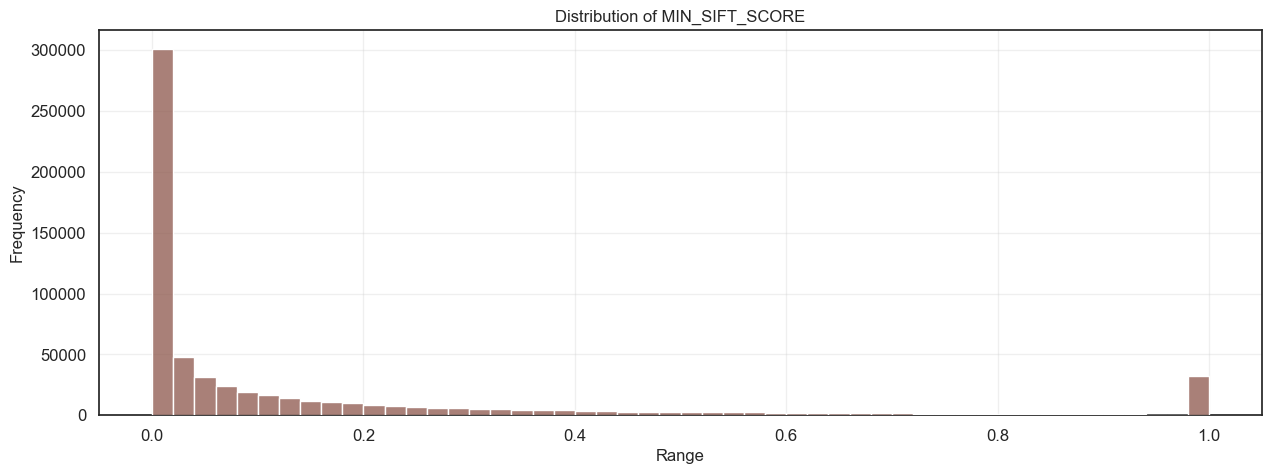

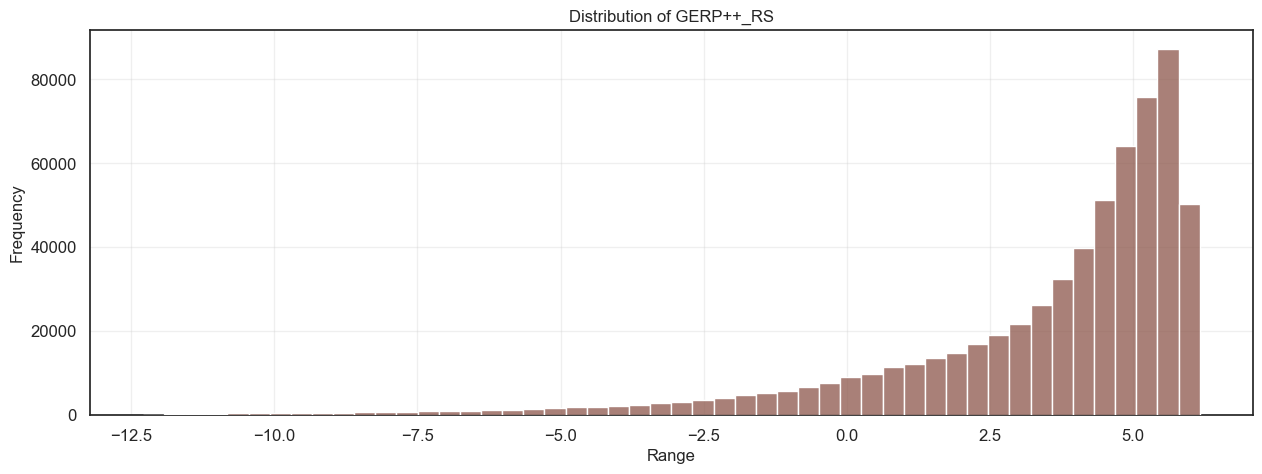

start           end        dna_vaf  MIN_SIFT_SCORE  \
count  8.152020e+05  8.152020e+05  815202.000000   626188.000000   
mean   7.777195e+07  7.777195e+07       0.321661        0.151822   
std    5.731500e+07  5.731500e+07       0.143848        0.263485   
min    1.714500e+04  1.714500e+04       0.100143        0.000000   
25%    3.294769e+07  3.294769e+07       0.212766        0.002000   
50%    6.331857e+07  6.331857e+07       0.307692        0.023000   
75%    1.167718e+08  1.167718e+08       0.403846        0.166000   
max    2.489184e+08  2.489184e+08       1.000000        1.000000   

           GERP++_RS  
count  624273.000000  
mean        3.417513  
std         2.860525  
min       -12.300000  
25%         2.480000  
50%         4.460000  
75%         5.350000  
max         6.170000

In [181]:
visualize_numerical_frequent(df_p_1_merged, "MIN_SIFT_SCORE")
visualize_numerical_frequent(df_p_1_merged, "GERP++_RS")
df_p_1_merged.describe()

**MIN_SIFT_SCORE:**
- **SIFT is a program that uses sequence homology to predict whether an amino acid substitution will affect protein function or not, deleterious or not. SIFT Scores with less than 0.05 are predicted to affect protein function. That score is the normalized probability that the amino acid change is tolerated. There are ways to assess if predictions are likely to be false positives or not but it will be ignored right now for time purposes. It will be checked later on.**
- **The first figure depicts numerical distribution of the SIFT SCORE. According to SIFT, the majority of the records are deletrious mutations - 60% of the data since there are 367412 entries notated as Deleterious in the MIN_SIFT_PRED column. There are some outliers however at the end of the graph, which are entries with close or perfect 1.0 scores. These outliers are neutral substitutions with no serious effect to the protein functionality.**
- **https://pmc.ncbi.nlm.nih.gov/articles/PMC168916/pdf/gkg509.pdf**

**GERP++_RS:**
- **RS or rejected substituions gives a score if the site is conserved or not. It estimates how many substitutions would have been expected at that site if it were evolving neutrally, then substracts number actually observed. So the higher the number the more natural substutions estimated the more conservative the site is so the more deleterious the mutation is. RS > 0 means fewer changes than expected. RS < 0 more change than expected.
According to the Distribution GERP++_RS graph, the majority of the entries are conservative mutations since they have an RS positive score.**
- **FIND A SOURCE FOR THIS.**

**Both graphs are complete opposite of each other, this in fact suggests that both features can have a negative relationship. Correlation analysis should be done.**

   MIN_SIFT_SCORE  GERP++_RS MUTATION_SIGNIFICANCE_TIER   dna_vaf
0           0.018       5.56                          0  0.171053
1           0.256       5.59                          0  0.464286
2           0.008       2.39                          0  0.208333
3           0.204       5.07                          0  0.235294
4           0.000       4.41                          0  0.253846


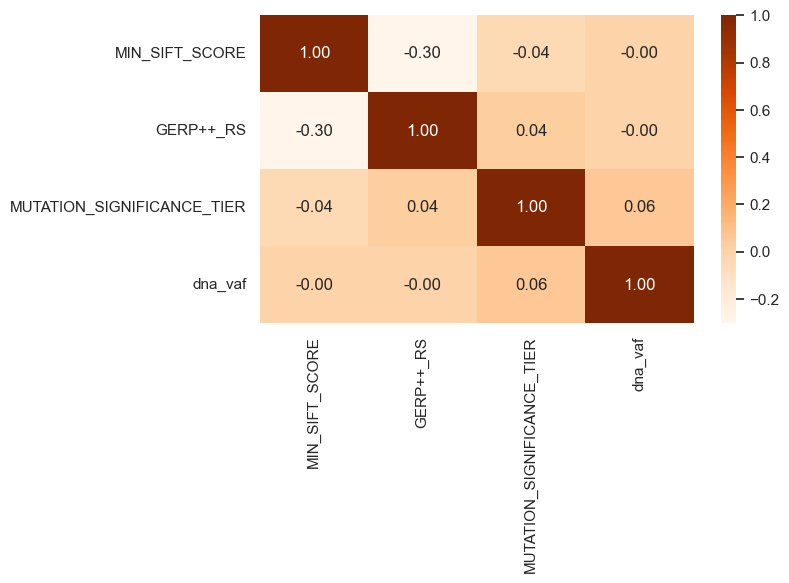

In [182]:
columns_correlation = ["MIN_SIFT_SCORE", "GERP++_RS", "MUTATION_SIGNIFICANCE_TIER", "dna_vaf"]
df_p_1_merged_no_na = df_p_1_merged.dropna(subset=columns_correlation)
df_corr = df_p_1_merged_no_na[columns_correlation]
df_corr.loc[:,"MUTATION_SIGNIFICANCE_TIER"] = pd.to_numeric(df_corr["MUTATION_SIGNIFICANCE_TIER"], errors="coerce")
# Handle outliers for correlation analysis
outer_fence_sift = calculate_fence(df_corr, "MIN_SIFT_SCORE", 3)
df_corr = df_corr[(df_corr["MIN_SIFT_SCORE"] > outer_fence_sift[0]) & (df_corr["MIN_SIFT_SCORE"] < outer_fence_sift[1])]
# Normalize the data for correlation anaylsis
print(df_corr.head())
plt.figure(figsize=(7,4))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="Oranges")
plt.show()

- **The heatmap correlation exhibits a moderate negative relationship between MIN_SIFT_SCORE and GERP++_RS score. This suggests that when there is a positive increase in GERP++_RS score, so when the site is more conservative, SIFT score decreases or the probability, that the amino acid chnage is much less tolerated, decreases. This is in fact in accordance with the previous definitions stated since a more conservative site leads to the conclusion that the mutation is more deleterious.**

In [184]:
df_p_1_pred_nan = df_p_1_merged[df_p_1_merged["MIN_SIFT_PRED"].isnull()]
print(df_p_1_pred_nan.shape)
df_p_1_pred_nan.isna().sum()

(207979, 18)


Sample_ID                          0
gene                               0
chrom                              0
start                              0
end                                0
ref                                0
alt                                0
Amino_Acid_Change                  0
effect                             0
dna_vaf                            0
type                               0
cancer                             0
missense_type                      0
MIN_SIFT_SCORE                189014
MIN_SIFT_PRED                 207979
MUTATION_SIGNIFICANCE_TIER    189014
DNDS_DISEASE_QVAL_SIG         207341
GERP++_RS                     190265
dtype: int64

In [185]:
df_p_1_pred_nan = df_p_1_pred_nan[
    ~((df_p_1_pred_nan["MIN_SIFT_SCORE"].isnull()) & 
    (df_p_1_pred_nan["MIN_SIFT_PRED"].isnull()) & 
    (df_p_1_pred_nan["MUTATION_SIGNIFICANCE_TIER"].isnull()) & 
    (df_p_1_pred_nan["DNDS_DISEASE_QVAL_SIG"].isnull()) &
    (df_p_1_pred_nan["GERP++_RS"].isnull()))
    ]
df_p_1_pred_nan.isna().sum()

Sample_ID                         0
gene                              0
chrom                             0
start                             0
end                               0
ref                               0
alt                               0
Amino_Acid_Change                 0
effect                            0
dna_vaf                           0
type                              0
cancer                            0
missense_type                     0
MIN_SIFT_SCORE                    0
MIN_SIFT_PRED                 18965
MUTATION_SIGNIFICANCE_TIER        0
DNDS_DISEASE_QVAL_SIG         18327
GERP++_RS                      1251
dtype: int64

In [186]:
df_p_1_pred_nan["MIN_SIFT_SCORE"].value_counts()

MIN_SIFT_SCORE
1.0    18965
Name: count, dtype: int64

In [187]:
df_p_1_merged.loc[df_p_1_merged["MIN_SIFT_SCORE"] == 1.0, "MIN_SIFT_PRED"] = "T" # T for Tolerate
df_p_1_nan = df_p_1_merged[df_p_1_merged["MIN_SIFT_PRED"].isnull()]
df_p_1_merged.dropna(subset=["MIN_SIFT_PRED"], inplace=True)
print(df_p_1_merged["MIN_SIFT_PRED"].value_counts())
print(df_p_1_merged.shape)

MIN_SIFT_PRED
D    367412
T    258776
Name: count, dtype: int64
(626188, 18)


In [188]:
df_p_1_merged[df_p_1_merged["MIN_SIFT_PRED"] == "T"]["missense_type"].value_counts()

missense_type
conservative        112629
non-conservative     78730
chance               67417
Name: count, dtype: int64

In [189]:
df_p_1_nan["missense_type"].value_counts()

missense_type
non-conservative    79512
conservative        60261
chance              49241
Name: count, dtype: int64

#### Cluster 2

In [190]:
df_p_2 = df_same_effect_p[df_same_effect_p["Cluster"] == 2].drop(columns=["Cluster"], axis=1)

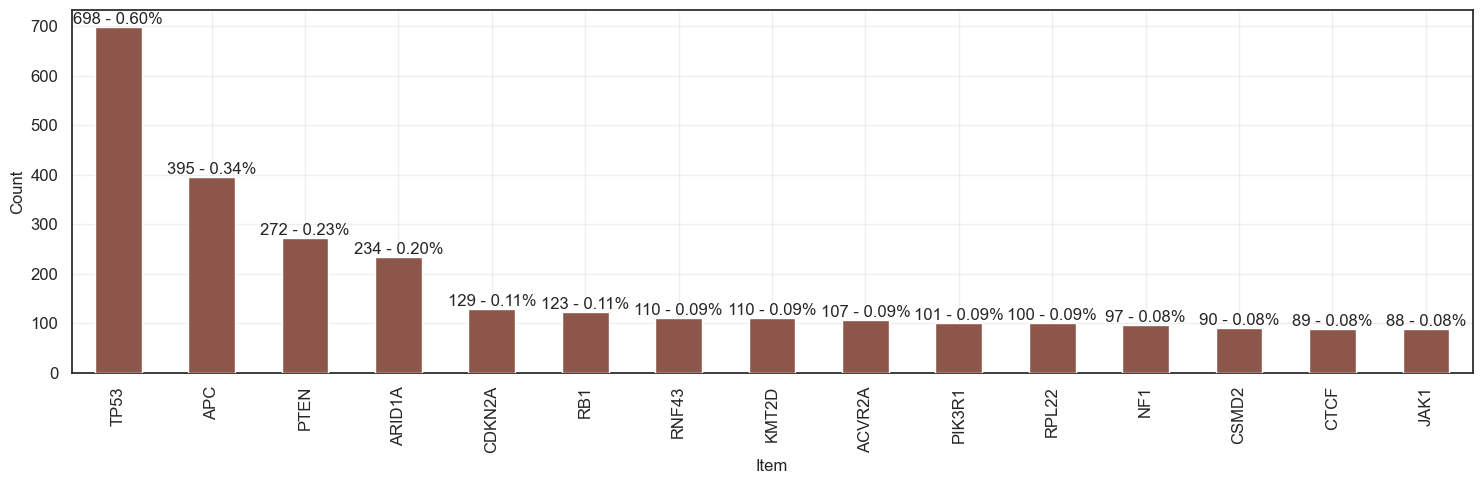

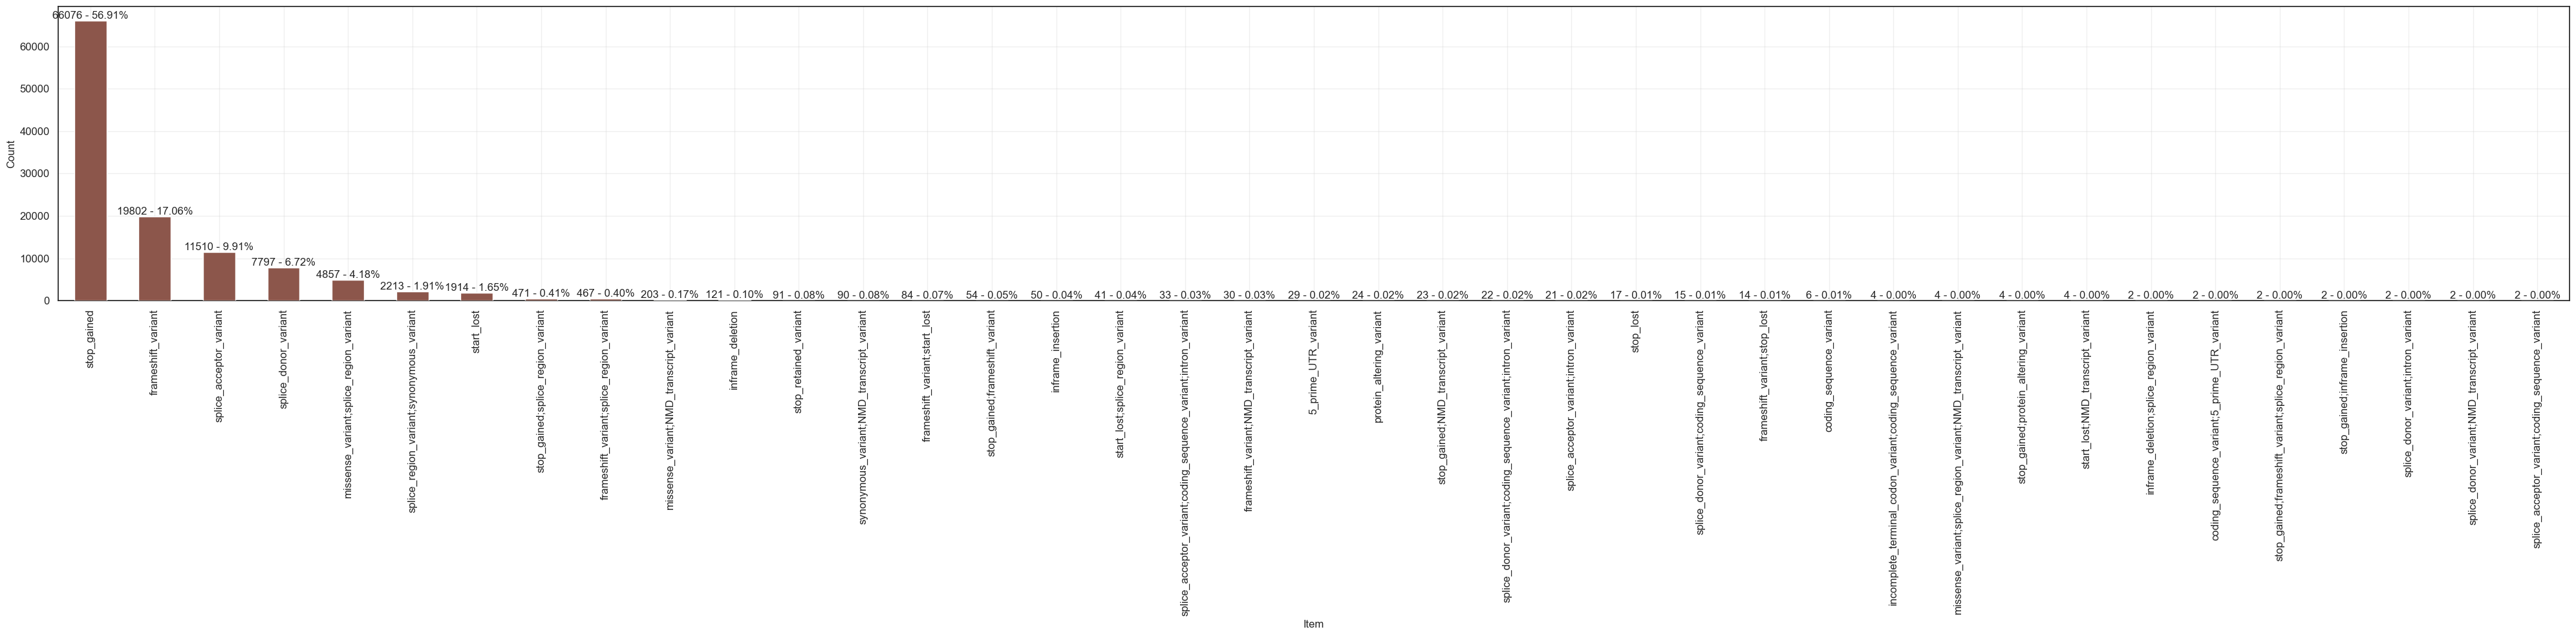

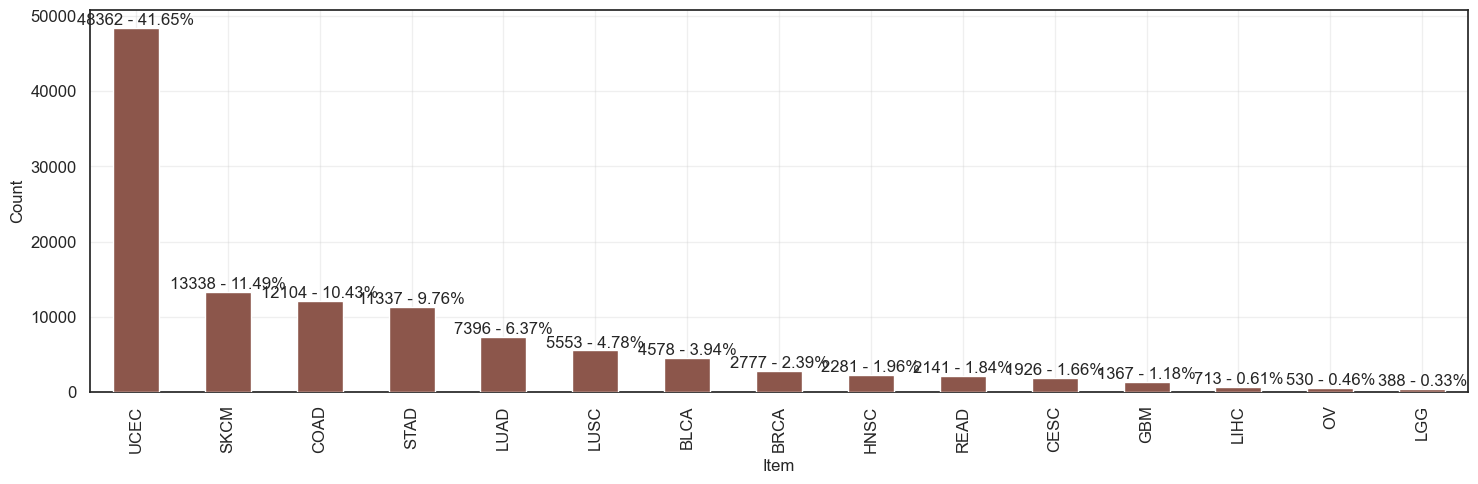

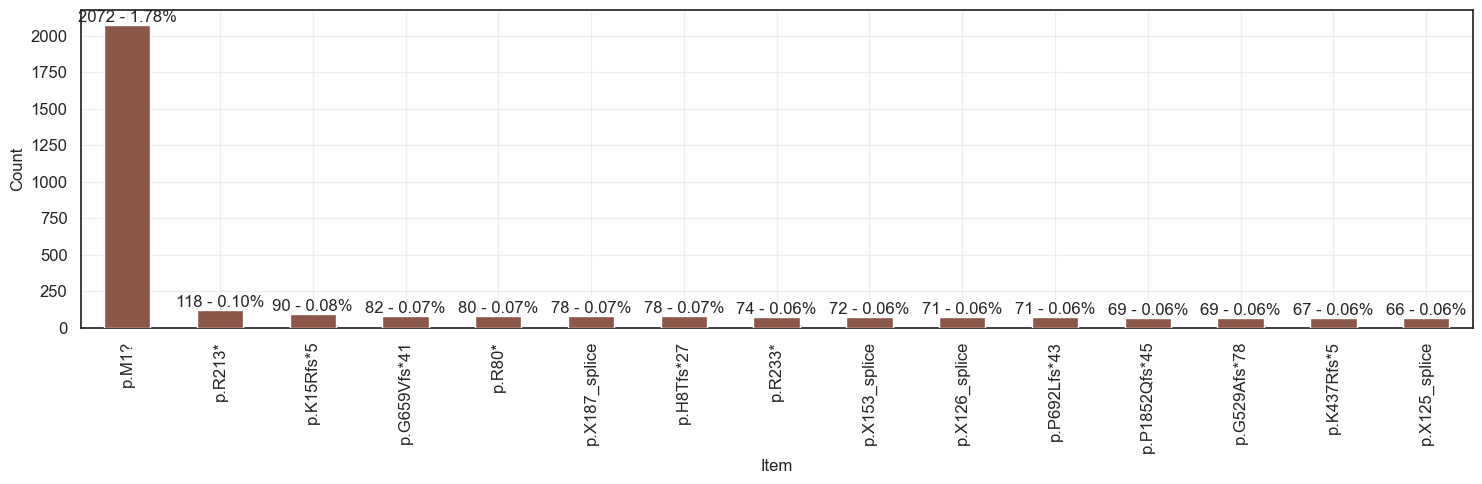

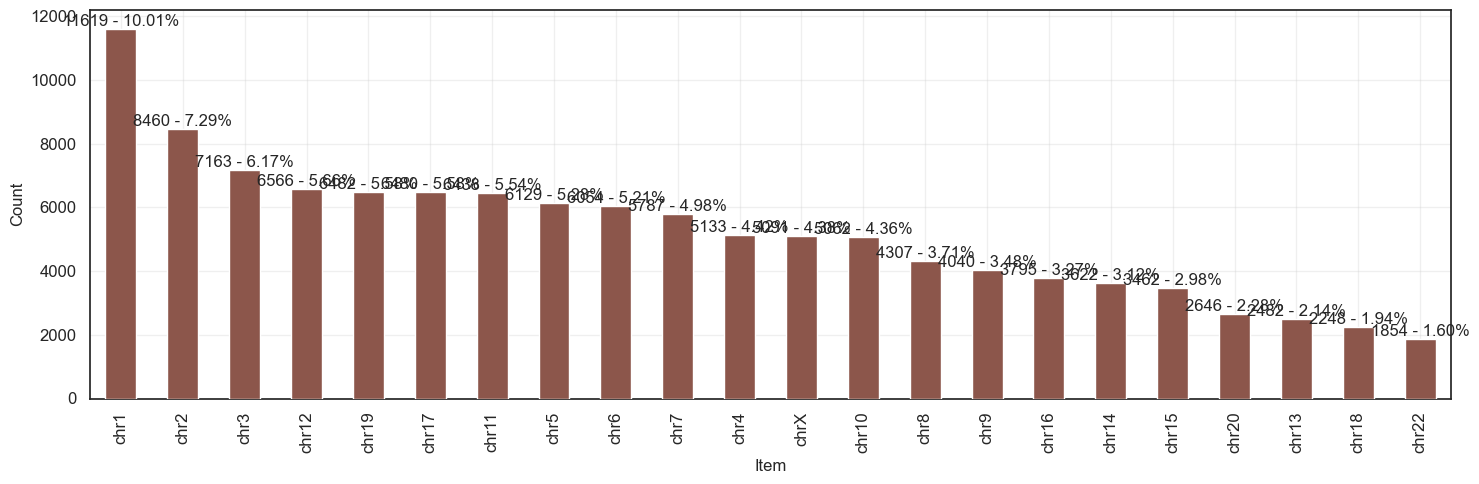

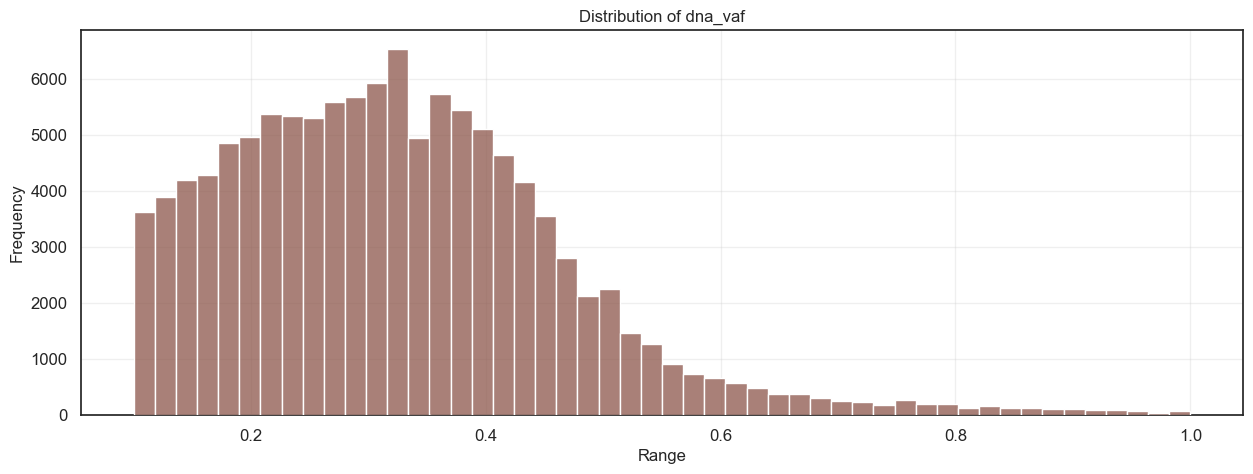

In [191]:
visualize_categorical_frequent(df = df_p_2, feature = "gene", nbr=15)
visualize_categorical_frequent(df = df_p_2, feature = "effect", nbr=39, size=(40,10))
visualize_categorical_frequent(df = df_p_2, feature = "cancer", nbr=15)
visualize_categorical_frequent(df = df_p_2, feature = "Amino_Acid_Change", nbr=15)
visualize_categorical_frequent(df = df_p_2, feature = "chrom", nbr=22)
visualize_numerical_frequent(df = df_p_2, feature = "dna_vaf")

### Non-Protein Based

In [192]:
df_same_effect_np = df_same_effect[df_same_effect.isnull().any(axis=1)]
print(df_same_effect_np.shape)

(522215, 12)


## Gene Undersampling

### TTN Analysis

### MUC16

### TP53

In [193]:
df_filtered[df_filtered["gene"] == "TP53"].shape

(3661, 12)